In [1]:
# %matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import params, trades, feats, plots, models_core, models_custom
importlib.reload(params)
importlib.reload(trades)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)
importlib.reload(models_custom)

<module 'libs.models_custom' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_custom.py'>

In [2]:
# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import pandas as pd
import numpy as np
import math
import re
from re import findall

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import seaborn as sns
from pprint import pprint

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models_core.DayWindowDataset])

# from tqdm.auto import tqdm
from tqdm import tqdm

import io
import os
import json
from PIL import Image
import IPython.display as disp

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.storages import RDBStorage

In [3]:
df_trainval = pd.read_csv(params.trainval_csv, index_col=0, parse_dates=True)
baseline_pnl = round((df_trainval["bid"].iloc[-1] - df_trainval["ask"].iloc[0]) / df_trainval.index.normalize().nunique(),4)
print('baseline profit & loss per day:', baseline_pnl)
df_trainval

baseline profit & loss per day: 0.0366


,dist_low_28,dist_low_60,dist_low_30,in_sess_time,dist_high_60,dist_high_30,dist_high_28,minute_time,hour_time,ret_std_z_90,...,roc_28,ret,eng_ma,roc_60,vwap_dev_pct_z_90,close_raw,signal,pred_signal,ask,bid
2009-01-02 12:30:00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.147157,0.1,0.500000,...,0.504537,0.500548,0.502857,0.503281,0.500000,3.069643,1.624044e-07,0.057928,3.070257,3.069029
2009-01-02 12:31:00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.148829,0.1,0.500000,...,0.504537,0.500548,0.502857,0.503281,0.500000,3.069643,1.840283e-07,0.057924,3.070257,3.069029
2009-01-02 12:32:00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.150502,0.1,0.500000,...,0.504537,0.500548,0.502857,0.503281,0.500000,3.069643,2.085314e-07,0.057702,3.070257,3.069029
2009-01-02 12:33:00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.152174,0.1,0.500000,...,0.504537,0.500548,0.502857,0.503281,0.500000,3.069643,2.362970e-07,0.057463,3.070257,3.069029
2009-01-02 12:34:00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.153846,0.1,0.500000,...,0.504537,0.500548,0.502857,0.503281,0.500000,3.069643,2.677596e-07,0.057207,3.070257,3.069029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23 20:56:00,0.190111,0.131679,0.183189,1.0,0.057014,0.044131,0.045622,0.993311,0.9,0.497293,...,0.574868,0.381398,0.598511,0.517734,0.506818,131.730000,1.177684e-01,0.076478,131.756346,131.703654
2022-12-23 20:57:00,0.218606,0.151416,0.210647,1.0,0.037104,0.016540,0.017098,0.994983,0.9,0.497872,...,0.586577,0.575084,0.604313,0.525328,0.515176,131.805000,5.830165e-02,0.102399,131.831361,131.778639
2022-12-23 20:58:00,0.228097,0.157990,0.219793,1.0,0.030473,0.007350,0.007598,0.996655,0.9,0.498126,...,0.588698,0.525379,0.609390,0.526069,0.515504,131.830000,3.644749e-02,0.107804,131.856366,131.803634
2022-12-23 20:59:00,0.239482,0.165876,0.230763,1.0,0.022518,0.000000,0.000000,0.998328,0.9,0.499176,...,0.586543,0.530340,0.619565,0.524711,0.513793,131.860000,0.000000e+00,0.122011,131.886372,131.833628


In [4]:
# Pre-compute per-day slices once
groups = df_trainval.groupby(df_trainval.index.normalize())
prun_perc = 70
report_interval = 50
_findall = re.compile(r"[+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?").findall

def objective(trial: optuna.Trial) -> float:
    
    sign_smoothwin = trial.suggest_categorical("sign_smoothwin", [3, 5, 10, 20, 30, 45, 60, 90, 120, 180])
    sellmin_idx    = trial.suggest_categorical("sellmin_idx", [None, -1, -2, -3])
    sess_start     = time.fromisoformat(trial.suggest_categorical("sess_start", [params.sess_start_pred.isoformat(), params.sess_start_reg.isoformat()]))
    trailstop_pct  = trial.suggest_float("trailstop_pct", 0.03, 0.3)

    print('-----------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Simulate trading using parameters ==> sign_smoothwin:',sign_smoothwin,'sellmin_idx:',sellmin_idx,'sess_start:','trailstop_pct:',round(trailstop_pct,4))
    
    daily_pnls: List[float] = []
    pbar = tqdm(groups, desc=f"Trial {trial.number}", leave=True)
    for step, (day, df_day) in enumerate(pbar, 1):

        # Causal smoothing of the raw pred_signal
        df_day["predsig_smooth"] = (
            df_day["pred_signal"]
              .rolling(window=sign_smoothwin, min_periods=1)
              .mean()
        )

        # Generate actions on the smoothed column
        df_actions = trades.generate_trade_actions(
            df                = df_day,
            col_signal        = "pred_signal",
            col_price         = "close_raw",
            buy_thresh        = df_day["predsig_smooth"],
            trailstop_pct     = trailstop_pct,
            sellmin_idx       = sellmin_idx,
            sess_start        = sess_start
            )

        # Simulate 1-day P&L
        sim = trades.simulate_trading(
            day               = day,
            df                = df_actions,
            sellmin_idx       = sellmin_idx, 
            sess_start        = sess_start
        )
   
        _, _, stats = next(iter(sim.values()))
        
        strategy_val = float(_findall(stats["STRATEGY"])[-1]) 

        daily_pnls.append(strategy_val)

        # Explicitly delete large locals at the end of each trial (no per-iteration gc.collect)
        del df_actions, sim, stats
        df_day = df_actions = sim = stats = None

        # Rreport for pruning
        if step % report_interval == 0:
            report_step = step // report_interval
            prun_val = float(np.mean(daily_pnls))
            trial.report(prun_val, report_step)
            if trial.should_prune():
                vals = [t.intermediate_values[report_step]
                        for t in trial.study.get_trials(deepcopy=False)
                        if t.state == TrialState.COMPLETE and report_step in t.intermediate_values]
                thr = float(__import__("numpy").percentile(vals, prun_perc))
                print(f"[PRUNE] value={prun_val:.6f} thr={thr:.6f}")
                pbar.close()
                raise optuna.TrialPruned()

    # Average daily P&L
    return float(np.mean(daily_pnls))


-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 10 sellmin_idx: None sess_start: trailstop_pct: 0.255


Trial 0: 100%|██████████| 3520/3520 [00:41<00:00, 85.85it/s]


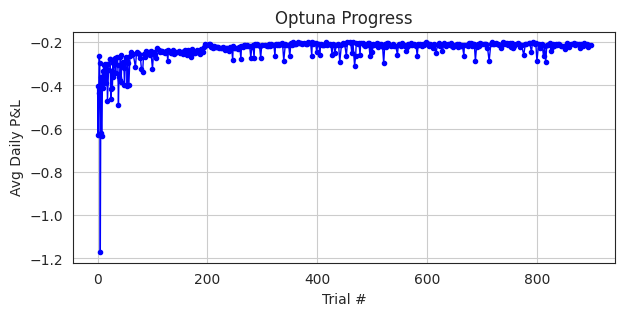

[Results] Trial 0 finished with value: -0.4023. Improvement over baseline: -1199.27%.     Best is trial 0 with value: -0.4023.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: -3 sess_start: trailstop_pct: 0.1522


Trial 1: 100%|██████████| 3520/3520 [00:40<00:00, 87.76it/s]


[Results] Trial 1 finished with value: -0.6277. Improvement over baseline: -1815.02%.     Best is trial 0 with value: -0.4023.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 5 sellmin_idx: -3 sess_start: trailstop_pct: 0.2718


Trial 2: 100%|██████████| 3520/3520 [00:34<00:00, 101.14it/s]


[Results] Trial 2 finished with value: -0.4364. Improvement over baseline: -1292.41%.     Best is trial 0 with value: -0.4023.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.2883


Trial 3: 100%|██████████| 3520/3520 [00:29<00:00, 118.05it/s]


[Results] Trial 3 finished with value: -0.2649. Improvement over baseline: -823.65%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -1 sess_start: trailstop_pct: 0.2977


Trial 4: 100%|██████████| 3520/3520 [00:28<00:00, 123.50it/s]


[Results] Trial 4 finished with value: -0.2948. Improvement over baseline: -905.47%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 5 sellmin_idx: -2 sess_start: trailstop_pct: 0.1031


Trial 5: 100%|██████████| 3520/3520 [00:35<00:00, 98.84it/s] 


[Results] Trial 5 finished with value: -1.1713. Improvement over baseline: -3300.14%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: None sess_start: trailstop_pct: 0.2227


Trial 6: 100%|██████████| 3520/3520 [00:34<00:00, 101.96it/s]


[Results] Trial 6 finished with value: -0.3598. Improvement over baseline: -1083.06%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: -1 sess_start: trailstop_pct: 0.1304


Trial 7: 100%|██████████| 3520/3520 [00:41<00:00, 84.17it/s]


[Results] Trial 7 finished with value: -0.6201. Improvement over baseline: -1794.33%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -3 sess_start: trailstop_pct: 0.0748


Trial 8: 100%|██████████| 3520/3520 [00:38<00:00, 92.57it/s]


[Results] Trial 8 finished with value: -0.6358. Improvement over baseline: -1837.28%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: -2 sess_start: trailstop_pct: 0.2372


Trial 9: 100%|██████████| 3520/3520 [00:35<00:00, 99.85it/s] 


[Results] Trial 9 finished with value: -0.3342. Improvement over baseline: -1013.00%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.187


Trial 10: 100%|██████████| 3520/3520 [00:36<00:00, 95.34it/s] 


[Results] Trial 10 finished with value: -0.4095. Improvement over baseline: -1218.94%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: -1 sess_start: trailstop_pct: 0.297


Trial 11: 100%|██████████| 3520/3520 [00:34<00:00, 101.39it/s]


[Results] Trial 11 finished with value: -0.3061. Improvement over baseline: -936.24%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: -1 sess_start: trailstop_pct: 0.0338


Trial 12:  25%|██▌       | 893/3520 [00:10<00:30, 85.06it/s]


[PRUNE] value=-0.449523 thr=-0.160870
[Results] Trial 12 finished with value: -0.4495. Improvement over baseline: -1328.21%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.1984


Trial 13: 100%|██████████| 3520/3520 [00:36<00:00, 96.28it/s] 


[Results] Trial 13 finished with value: -0.3894. Improvement over baseline: -1163.88%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -1 sess_start: trailstop_pct: 0.2944


Trial 14: 100%|██████████| 3520/3520 [00:33<00:00, 103.60it/s]


[Results] Trial 14 finished with value: -0.2986. Improvement over baseline: -915.73%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 3 sellmin_idx: None sess_start: trailstop_pct: 0.26


Trial 15: 100%|██████████| 3520/3520 [00:37<00:00, 92.89it/s] 


[Results] Trial 15 finished with value: -0.3883. Improvement over baseline: -1160.84%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -1 sess_start: trailstop_pct: 0.217


Trial 16:  25%|██▌       | 889/3520 [00:08<00:26, 99.70it/s] 


[PRUNE] value=-0.278187 thr=-0.160375
[Results] Trial 16 finished with value: -0.2782. Improvement over baseline: -860.07%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: -2 sess_start: trailstop_pct: 0.2989


Trial 17: 100%|██████████| 3520/3520 [00:34<00:00, 100.80it/s]


[Results] Trial 17 finished with value: -0.3018. Improvement over baseline: -924.62%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.1667


Trial 18: 100%|██████████| 3520/3520 [00:37<00:00, 94.97it/s] 


[Results] Trial 18 finished with value: -0.4740. Improvement over baseline: -1395.02%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: -1 sess_start: trailstop_pct: 0.2483


Trial 19:  25%|██▌       | 892/3520 [00:09<00:27, 95.84it/s] 


[PRUNE] value=-0.269751 thr=-0.158769
[Results] Trial 19 finished with value: -0.2698. Improvement over baseline: -837.02%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2022


Trial 20: 100%|██████████| 3520/3520 [00:36<00:00, 97.70it/s] 


[Results] Trial 20 finished with value: -0.3267. Improvement over baseline: -992.55%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -1 sess_start: trailstop_pct: 0.2784


Trial 21:  25%|██▌       | 891/3520 [00:08<00:26, 100.48it/s]


[PRUNE] value=-0.251901 thr=-0.153404
[Results] Trial 21 finished with value: -0.2519. Improvement over baseline: -788.25%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -1 sess_start: trailstop_pct: 0.2812


Trial 22: 100%|██████████| 3520/3520 [00:34<00:00, 102.53it/s]


[Results] Trial 22 finished with value: -0.2761. Improvement over baseline: -854.31%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -1 sess_start: trailstop_pct: 0.2756


Trial 23: 100%|██████████| 3520/3520 [00:34<00:00, 102.45it/s]


[Results] Trial 23 finished with value: -0.2789. Improvement over baseline: -862.01%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 10 sellmin_idx: -1 sess_start: trailstop_pct: 0.2293


Trial 24: 100%|██████████| 3520/3520 [00:36<00:00, 96.01it/s] 


[Results] Trial 24 finished with value: -0.4621. Improvement over baseline: -1362.63%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 3 sellmin_idx: -1 sess_start: trailstop_pct: 0.2721


Trial 25: 100%|██████████| 3520/3520 [00:36<00:00, 97.17it/s] 


[Results] Trial 25 finished with value: -0.4179. Improvement over baseline: -1241.74%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: -2 sess_start: trailstop_pct: 0.2731


Trial 26: 100%|██████████| 3520/3520 [00:34<00:00, 101.74it/s]


[Results] Trial 26 finished with value: -0.3314. Improvement over baseline: -1005.47%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: -3 sess_start: trailstop_pct: 0.2371


Trial 27: 100%|██████████| 3520/3520 [00:35<00:00, 98.62it/s] 


[Results] Trial 27 finished with value: -0.4132. Improvement over baseline: -1229.01%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -1 sess_start: trailstop_pct: 0.2529


Trial 28: 100%|██████████| 3520/3520 [00:34<00:00, 102.74it/s]


[Results] Trial 28 finished with value: -0.2969. Improvement over baseline: -911.33%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 10 sellmin_idx: None sess_start: trailstop_pct: 0.2516


Trial 29: 100%|██████████| 3520/3520 [00:37<00:00, 94.59it/s] 


[Results] Trial 29 finished with value: -0.3628. Improvement over baseline: -1091.29%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2795


Trial 30:  25%|██▌       | 891/3520 [00:09<00:27, 96.02it/s] 


[PRUNE] value=-0.224927 thr=-0.138328
[Results] Trial 30 finished with value: -0.2249. Improvement over baseline: -714.55%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -1 sess_start: trailstop_pct: 0.2901


Trial 31: 100%|██████████| 3520/3520 [00:34<00:00, 103.18it/s]


[Results] Trial 31 finished with value: -0.2716. Improvement over baseline: -842.09%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -1 sess_start: trailstop_pct: 0.2667


Trial 32: 100%|██████████| 3520/3520 [00:34<00:00, 103.30it/s]


[Results] Trial 32 finished with value: -0.2857. Improvement over baseline: -880.71%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: -1 sess_start: trailstop_pct: 0.2795


Trial 33: 100%|██████████| 3520/3520 [00:34<00:00, 101.00it/s]


[Results] Trial 33 finished with value: -0.3422. Improvement over baseline: -1034.98%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -3 sess_start: trailstop_pct: 0.284


Trial 34: 100%|██████████| 3520/3520 [00:34<00:00, 101.10it/s]


[Results] Trial 34 finished with value: -0.2728. Improvement over baseline: -845.31%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -3 sess_start: trailstop_pct: 0.2907


Trial 35: 100%|██████████| 3520/3520 [00:34<00:00, 102.03it/s]


[Results] Trial 35 finished with value: -0.2669. Improvement over baseline: -829.18%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 5 sellmin_idx: -3 sess_start: trailstop_pct: 0.2434


Trial 36:  25%|██▌       | 896/3520 [00:12<00:36, 72.69it/s]


[PRUNE] value=-0.209379 thr=-0.128143
[Results] Trial 36 finished with value: -0.2094. Improvement over baseline: -672.07%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: -3 sess_start: trailstop_pct: 0.2895


Trial 37: 100%|██████████| 3520/3520 [00:42<00:00, 83.26it/s]


[Results] Trial 37 finished with value: -0.3040. Improvement over baseline: -930.50%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -3 sess_start: trailstop_pct: 0.1318


Trial 38: 100%|██████████| 3520/3520 [00:38<00:00, 90.79it/s]


[Results] Trial 38 finished with value: -0.4900. Improvement over baseline: -1438.88%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: -3 sess_start: trailstop_pct: 0.2614


Trial 39: 100%|██████████| 3520/3520 [00:37<00:00, 94.30it/s] 


[Results] Trial 39 finished with value: -0.3593. Improvement over baseline: -1081.59%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: -3 sess_start: trailstop_pct: 0.2165


Trial 40: 100%|██████████| 3520/3520 [00:38<00:00, 92.05it/s]


[Results] Trial 40 finished with value: -0.3747. Improvement over baseline: -1123.81%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -3 sess_start: trailstop_pct: 0.2888


Trial 41: 100%|██████████| 3520/3520 [00:38<00:00, 90.63it/s]


[Results] Trial 41 finished with value: -0.2686. Improvement over baseline: -833.87%.     Best is trial 3 with value: -0.2649.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -3 sess_start: trailstop_pct: 0.2995


Trial 42: 100%|██████████| 3520/3520 [00:39<00:00, 90.16it/s]


[Results] Trial 42 finished with value: -0.2588. Improvement over baseline: -807.03%.     Best is trial 42 with value: -0.2588.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 5 sellmin_idx: -3 sess_start: trailstop_pct: 0.2984


Trial 43: 100%|██████████| 3520/3520 [00:40<00:00, 87.43it/s]


[Results] Trial 43 finished with value: -0.3857. Improvement over baseline: -1153.77%.     Best is trial 42 with value: -0.2588.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -3 sess_start: trailstop_pct: 0.2579


Trial 44: 100%|██████████| 3520/3520 [00:36<00:00, 96.59it/s] 


[Results] Trial 44 finished with value: -0.2968. Improvement over baseline: -910.95%.     Best is trial 42 with value: -0.2588.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: -3 sess_start: trailstop_pct: 0.0971


Trial 45:  25%|██▌       | 891/3520 [00:10<00:29, 88.94it/s]


[PRUNE] value=-0.263468 thr=-0.125951
[Results] Trial 45 finished with value: -0.2635. Improvement over baseline: -819.86%.     Best is trial 42 with value: -0.2588.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: -3 sess_start: trailstop_pct: 0.2887


Trial 46: 100%|██████████| 3520/3520 [00:36<00:00, 97.20it/s] 


[Results] Trial 46 finished with value: -0.3043. Improvement over baseline: -931.42%.     Best is trial 42 with value: -0.2588.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -3 sess_start: trailstop_pct: 0.2651


Trial 47: 100%|██████████| 3520/3520 [00:35<00:00, 97.93it/s] 


[Results] Trial 47 finished with value: -0.2912. Improvement over baseline: -895.56%.     Best is trial 42 with value: -0.2588.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: -2 sess_start: trailstop_pct: 0.2902


Trial 48: 100%|██████████| 3520/3520 [00:36<00:00, 96.41it/s] 


[Results] Trial 48 finished with value: -0.3186. Improvement over baseline: -970.59%.     Best is trial 42 with value: -0.2588.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 3 sellmin_idx: -3 sess_start: trailstop_pct: 0.2999


Trial 49: 100%|██████████| 3520/3520 [00:40<00:00, 87.16it/s]


[Results] Trial 49 finished with value: -0.3976. Improvement over baseline: -1186.37%.     Best is trial 42 with value: -0.2588.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: None sess_start: trailstop_pct: 0.0495


Trial 50:  26%|██▌       | 898/3520 [00:12<00:36, 70.92it/s]


[PRUNE] value=-0.452056 thr=-0.126340
[Results] Trial 50 finished with value: -0.4521. Improvement over baseline: -1335.12%.     Best is trial 42 with value: -0.2588.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -3 sess_start: trailstop_pct: 0.283


Trial 51: 100%|██████████| 3520/3520 [00:38<00:00, 90.41it/s]


[Results] Trial 51 finished with value: -0.2741. Improvement over baseline: -848.79%.     Best is trial 42 with value: -0.2588.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -3 sess_start: trailstop_pct: 0.2878


Trial 52: 100%|██████████| 3520/3520 [00:37<00:00, 93.12it/s]


[Results] Trial 52 finished with value: -0.2694. Improvement over baseline: -836.09%.     Best is trial 42 with value: -0.2588.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -3 sess_start: trailstop_pct: 0.2686


Trial 53: 100%|██████████| 3520/3520 [00:37<00:00, 94.18it/s] 


[Results] Trial 53 finished with value: -0.2869. Improvement over baseline: -883.99%.     Best is trial 42 with value: -0.2588.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -3 sess_start: trailstop_pct: 0.18


Trial 54: 100%|██████████| 3520/3520 [00:40<00:00, 87.35it/s]


[Results] Trial 54 finished with value: -0.4031. Improvement over baseline: -1201.46%.     Best is trial 42 with value: -0.2588.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.2929


Trial 55: 100%|██████████| 3520/3520 [00:40<00:00, 87.58it/s]


[Results] Trial 55 finished with value: -0.2948. Improvement over baseline: -905.47%.     Best is trial 42 with value: -0.2588.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -3 sess_start: trailstop_pct: 0.2454


Trial 56:  25%|██▌       | 893/3520 [00:10<00:29, 88.91it/s]


[PRUNE] value=-0.272799 thr=-0.120702
[Results] Trial 56 finished with value: -0.2728. Improvement over baseline: -845.35%.     Best is trial 42 with value: -0.2588.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: -3 sess_start: trailstop_pct: 0.2323


Trial 57: 100%|██████████| 3520/3520 [00:38<00:00, 91.83it/s]


[Results] Trial 57 finished with value: -0.3976. Improvement over baseline: -1186.37%.     Best is trial 42 with value: -0.2588.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 10 sellmin_idx: -2 sess_start: trailstop_pct: 0.1421


Trial 58:  25%|██▌       | 893/3520 [00:12<00:36, 72.80it/s]


[PRUNE] value=-0.325218 thr=-0.121703
[Results] Trial 58 finished with value: -0.3252. Improvement over baseline: -988.57%.     Best is trial 42 with value: -0.2588.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.261


Trial 59: 100%|██████████| 3520/3520 [00:42<00:00, 82.65it/s]


[Results] Trial 59 finished with value: -0.2637. Improvement over baseline: -820.42%.     Best is trial 42 with value: -0.2588.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2696


Trial 60:  25%|██▌       | 897/3520 [00:11<00:34, 75.82it/s]


[PRUNE] value=-0.250184 thr=-0.120025
[Results] Trial 60 finished with value: -0.2502. Improvement over baseline: -783.56%.     Best is trial 42 with value: -0.2588.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2876


Trial 61: 100%|██████████| 3520/3520 [00:43<00:00, 81.71it/s]


[Results] Trial 61 finished with value: -0.2439. Improvement over baseline: -766.26%.     Best is trial 61 with value: -0.2439.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2998


Trial 62:  25%|██▌       | 897/3520 [00:10<00:29, 88.36it/s]


[PRUNE] value=-0.226609 thr=-0.119222
[Results] Trial 62 finished with value: -0.2266. Improvement over baseline: -719.15%.     Best is trial 61 with value: -0.2439.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2759


Trial 63: 100%|██████████| 3520/3520 [00:42<00:00, 83.55it/s]


[Results] Trial 63 finished with value: -0.2559. Improvement over baseline: -799.05%.     Best is trial 61 with value: -0.2439.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.2586


Trial 64:  26%|██▌       | 899/3520 [00:10<00:29, 88.14it/s]


[PRUNE] value=-0.249354 thr=-0.119009
[Results] Trial 64 finished with value: -0.2494. Improvement over baseline: -781.30%.     Best is trial 61 with value: -0.2439.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2746


Trial 65: 100%|██████████| 3520/3520 [00:37<00:00, 92.84it/s]


[Results] Trial 65 finished with value: -0.2556. Improvement over baseline: -798.48%.     Best is trial 61 with value: -0.2439.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.277


Trial 66:  25%|██▌       | 890/3520 [00:09<00:29, 90.01it/s]


[PRUNE] value=-0.235096 thr=-0.118149
[Results] Trial 66 finished with value: -0.2351. Improvement over baseline: -742.34%.     Best is trial 61 with value: -0.2439.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: None sess_start: trailstop_pct: 0.2525


Trial 67:  25%|██▌       | 895/3520 [00:10<00:29, 88.62it/s]


[PRUNE] value=-0.165620 thr=-0.118149
[Results] Trial 67 finished with value: -0.1656. Improvement over baseline: -552.51%.     Best is trial 61 with value: -0.2439.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 3 sellmin_idx: None sess_start: trailstop_pct: 0.274


Trial 68:  25%|██▌       | 894/3520 [00:10<00:31, 82.15it/s]


[PRUNE] value=-0.181723 thr=-0.118149
[Results] Trial 68 finished with value: -0.1817. Improvement over baseline: -596.51%.     Best is trial 61 with value: -0.2439.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2214


Trial 69: 100%|██████████| 3520/3520 [00:38<00:00, 91.82it/s]


[Results] Trial 69 finished with value: -0.3159. Improvement over baseline: -963.11%.     Best is trial 61 with value: -0.2439.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.2067


Trial 70:  25%|██▌       | 894/3520 [00:10<00:29, 88.69it/s]


[PRUNE] value=-0.302926 thr=-0.118726
[Results] Trial 70 finished with value: -0.3029. Improvement over baseline: -927.67%.     Best is trial 61 with value: -0.2439.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2827


Trial 71: 100%|██████████| 3520/3520 [00:37<00:00, 92.82it/s]


[Results] Trial 71 finished with value: -0.2441. Improvement over baseline: -766.85%.     Best is trial 61 with value: -0.2439.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2639


Trial 72:  25%|██▌       | 890/3520 [00:09<00:29, 90.60it/s]


[PRUNE] value=-0.241106 thr=-0.117380
[Results] Trial 72 finished with value: -0.2411. Improvement over baseline: -758.76%.     Best is trial 61 with value: -0.2439.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2829


Trial 73: 100%|██████████| 3520/3520 [00:36<00:00, 95.20it/s]


[Results] Trial 73 finished with value: -0.2484. Improvement over baseline: -778.65%.     Best is trial 61 with value: -0.2439.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2825


Trial 74:  26%|██▌       | 898/3520 [00:09<00:27, 93.79it/s]


[PRUNE] value=-0.233268 thr=-0.115221
[Results] Trial 74 finished with value: -0.2333. Improvement over baseline: -737.34%.     Best is trial 61 with value: -0.2439.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 5 sellmin_idx: None sess_start: trailstop_pct: 0.241


Trial 75:  25%|██▌       | 892/3520 [00:10<00:30, 85.50it/s]


[PRUNE] value=-0.207353 thr=-0.115221
[Results] Trial 75 finished with value: -0.2074. Improvement over baseline: -666.54%.     Best is trial 61 with value: -0.2439.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2757


Trial 76: 100%|██████████| 3520/3520 [00:36<00:00, 95.91it/s]


[Results] Trial 76 finished with value: -0.2559. Improvement over baseline: -799.30%.     Best is trial 61 with value: -0.2439.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2721


Trial 77:  25%|██▌       | 894/3520 [00:09<00:27, 94.25it/s]


[PRUNE] value=-0.236776 thr=-0.113395
[Results] Trial 77 finished with value: -0.2368. Improvement over baseline: -746.93%.     Best is trial 61 with value: -0.2439.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2565


Trial 78: 100%|██████████| 3520/3520 [00:36<00:00, 96.53it/s] 


[Results] Trial 78 finished with value: -0.2724. Improvement over baseline: -844.39%.     Best is trial 61 with value: -0.2439.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.283


Trial 79:  25%|██▌       | 890/3520 [00:09<00:29, 89.19it/s]


[PRUNE] value=-0.233092 thr=-0.113801
[Results] Trial 79 finished with value: -0.2331. Improvement over baseline: -736.86%.     Best is trial 61 with value: -0.2439.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: None sess_start: trailstop_pct: 0.2493


Trial 80: 100%|██████████| 3520/3520 [00:42<00:00, 83.66it/s]


[Results] Trial 80 finished with value: -0.3254. Improvement over baseline: -989.16%.     Best is trial 61 with value: -0.2439.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2755


Trial 81:  26%|██▌       | 899/3520 [00:11<00:32, 79.64it/s]


[PRUNE] value=-0.235666 thr=-0.114866
[Results] Trial 81 finished with value: -0.2357. Improvement over baseline: -743.89%.     Best is trial 61 with value: -0.2439.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.2655


Trial 82: 100%|██████████| 3520/3520 [00:43<00:00, 81.11it/s]


[Results] Trial 82 finished with value: -0.3379. Improvement over baseline: -1023.24%.     Best is trial 61 with value: -0.2439.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 10 sellmin_idx: None sess_start: trailstop_pct: 0.2951


Trial 83:  25%|██▌       | 897/3520 [00:11<00:34, 76.55it/s]


[PRUNE] value=-0.274734 thr=-0.115931
[Results] Trial 83 finished with value: -0.2747. Improvement over baseline: -850.64%.     Best is trial 61 with value: -0.2439.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2792


Trial 84: 100%|██████████| 3520/3520 [00:43<00:00, 81.11it/s]


[Results] Trial 84 finished with value: -0.2530. Improvement over baseline: -791.37%.     Best is trial 61 with value: -0.2439.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2793


Trial 85:  25%|██▌       | 893/3520 [00:11<00:32, 80.49it/s]


[PRUNE] value=-0.234138 thr=-0.113446
[Results] Trial 85 finished with value: -0.2341. Improvement over baseline: -739.72%.     Best is trial 61 with value: -0.2439.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2613


Trial 86: 100%|██████████| 3520/3520 [00:43<00:00, 81.11it/s]


[Results] Trial 86 finished with value: -0.2683. Improvement over baseline: -833.11%.     Best is trial 61 with value: -0.2439.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2864


Trial 87:  25%|██▌       | 894/3520 [00:11<00:33, 79.49it/s]


[PRUNE] value=-0.231687 thr=-0.114511
[Results] Trial 87 finished with value: -0.2317. Improvement over baseline: -733.02%.     Best is trial 61 with value: -0.2439.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2938


Trial 88: 100%|██████████| 3520/3520 [00:43<00:00, 81.00it/s]


[Results] Trial 88 finished with value: -0.2381. Improvement over baseline: -750.68%.     Best is trial 88 with value: -0.2381.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2939


Trial 89:  26%|██▌       | 898/3520 [00:11<00:33, 77.58it/s]


[PRUNE] value=-0.229677 thr=-0.113344
[Results] Trial 89 finished with value: -0.2297. Improvement over baseline: -727.53%.     Best is trial 88 with value: -0.2381.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: -2 sess_start: trailstop_pct: 0.1029


Trial 90:  25%|██▌       | 890/3520 [00:11<00:34, 76.33it/s]


[PRUNE] value=-0.287424 thr=-0.113344
[Results] Trial 90 finished with value: -0.2874. Improvement over baseline: -885.31%.     Best is trial 88 with value: -0.2381.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2687


Trial 91: 100%|██████████| 3520/3520 [00:43<00:00, 80.11it/s]


[Results] Trial 91 finished with value: -0.2562. Improvement over baseline: -800.06%.     Best is trial 88 with value: -0.2381.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2743


Trial 92:  25%|██▌       | 893/3520 [00:11<00:34, 77.10it/s]


[PRUNE] value=-0.235832 thr=-0.113146
[Results] Trial 92 finished with value: -0.2358. Improvement over baseline: -744.35%.     Best is trial 88 with value: -0.2381.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2839


Trial 93: 100%|██████████| 3520/3520 [00:43<00:00, 81.13it/s]


[Results] Trial 93 finished with value: -0.2468. Improvement over baseline: -774.45%.     Best is trial 88 with value: -0.2381.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2824


Trial 94:  25%|██▌       | 895/3520 [00:11<00:32, 79.78it/s]


[PRUNE] value=-0.233301 thr=-0.112825
[Results] Trial 94 finished with value: -0.2333. Improvement over baseline: -737.43%.     Best is trial 88 with value: -0.2381.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2691


Trial 95: 100%|██████████| 3520/3520 [00:43<00:00, 81.73it/s]


[Results] Trial 95 finished with value: -0.2601. Improvement over baseline: -810.56%.     Best is trial 88 with value: -0.2381.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.2863


Trial 96:  25%|██▌       | 895/3520 [00:11<00:33, 78.03it/s]


[PRUNE] value=-0.235472 thr=-0.112963
[Results] Trial 96 finished with value: -0.2355. Improvement over baseline: -743.37%.     Best is trial 88 with value: -0.2381.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2929


Trial 97: 100%|██████████| 3520/3520 [00:43<00:00, 81.06it/s]


[Results] Trial 97 finished with value: -0.2388. Improvement over baseline: -752.42%.     Best is trial 88 with value: -0.2381.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2933


Trial 98:  25%|██▌       | 892/3520 [00:12<00:35, 73.88it/s]


[PRUNE] value=-0.229783 thr=-0.112726
[Results] Trial 98 finished with value: -0.2298. Improvement over baseline: -727.82%.     Best is trial 88 with value: -0.2381.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 5 sellmin_idx: None sess_start: trailstop_pct: 0.2783


Trial 99:  25%|██▌       | 892/3520 [00:12<00:37, 70.46it/s]


[PRUNE] value=-0.174822 thr=-0.112726
[Results] Trial 99 finished with value: -0.1748. Improvement over baseline: -577.66%.     Best is trial 88 with value: -0.2381.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: None sess_start: trailstop_pct: 0.2935


Trial 100: 100%|██████████| 3520/3520 [00:44<00:00, 78.81it/s]


[Results] Trial 100 finished with value: -0.3229. Improvement over baseline: -982.34%.     Best is trial 88 with value: -0.2381.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.269


Trial 101:  25%|██▌       | 897/3520 [00:11<00:33, 79.41it/s]


[PRUNE] value=-0.239127 thr=-0.112779
[Results] Trial 101 finished with value: -0.2391. Improvement over baseline: -753.35%.     Best is trial 88 with value: -0.2381.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2867


Trial 102: 100%|██████████| 3520/3520 [00:43<00:00, 81.11it/s]


[Results] Trial 102 finished with value: -0.2451. Improvement over baseline: -769.76%.     Best is trial 88 with value: -0.2381.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2869


Trial 103:  26%|██▌       | 898/3520 [00:11<00:33, 78.82it/s]


[PRUNE] value=-0.231519 thr=-0.112712
[Results] Trial 103 finished with value: -0.2315. Improvement over baseline: -732.57%.     Best is trial 88 with value: -0.2381.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2763


Trial 104: 100%|██████████| 3520/3520 [00:43<00:00, 80.38it/s]


[Results] Trial 104 finished with value: -0.2557. Improvement over baseline: -798.71%.     Best is trial 88 with value: -0.2381.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 3 sellmin_idx: None sess_start: trailstop_pct: 0.2814


Trial 105:  25%|██▌       | 895/3520 [00:11<00:34, 75.28it/s]


[PRUNE] value=-0.299648 thr=-0.112645
[Results] Trial 105 finished with value: -0.2996. Improvement over baseline: -918.71%.     Best is trial 88 with value: -0.2381.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2551


Trial 106: 100%|██████████| 3520/3520 [00:44<00:00, 79.68it/s]


[Results] Trial 106 finished with value: -0.2735. Improvement over baseline: -847.24%.     Best is trial 88 with value: -0.2381.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2943


Trial 107:  25%|██▌       | 897/3520 [00:11<00:33, 78.73it/s]


[PRUNE] value=-0.229476 thr=-0.112698
[Results] Trial 107 finished with value: -0.2295. Improvement over baseline: -726.98%.     Best is trial 88 with value: -0.2381.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: None sess_start: trailstop_pct: 0.1673


Trial 108:  25%|██▌       | 897/3520 [00:11<00:34, 75.33it/s]


[PRUNE] value=-0.206102 thr=-0.112698
[Results] Trial 108 finished with value: -0.2061. Improvement over baseline: -663.12%.     Best is trial 88 with value: -0.2381.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2997


Trial 109: 100%|██████████| 3520/3520 [00:44<00:00, 78.92it/s]


[Results] Trial 109 finished with value: -0.2285. Improvement over baseline: -724.18%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: -2 sess_start: trailstop_pct: 0.2991


Trial 110:  26%|██▌       | 899/3520 [00:11<00:33, 78.12it/s]


[PRUNE] value=-0.273786 thr=-0.112574
[Results] Trial 110 finished with value: -0.2738. Improvement over baseline: -848.05%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2887


Trial 111: 100%|██████████| 3520/3520 [00:44<00:00, 79.16it/s]


[Results] Trial 111 finished with value: -0.2371. Improvement over baseline: -747.90%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2901


Trial 112:  25%|██▌       | 893/3520 [00:12<00:35, 74.25it/s]


[PRUNE] value=-0.230696 thr=-0.112494
[Results] Trial 112 finished with value: -0.2307. Improvement over baseline: -730.32%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2844


Trial 113: 100%|██████████| 3520/3520 [00:44<00:00, 79.67it/s]


[Results] Trial 113 finished with value: -0.2463. Improvement over baseline: -772.89%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2858


Trial 114:  25%|██▌       | 896/3520 [00:11<00:32, 79.71it/s]


[PRUNE] value=-0.232119 thr=-0.112452
[Results] Trial 114 finished with value: -0.2321. Improvement over baseline: -734.20%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.29


Trial 115: 100%|██████████| 3520/3520 [00:44<00:00, 78.77it/s]


[Results] Trial 115 finished with value: -0.2416. Improvement over baseline: -759.99%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 10 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 116:  25%|██▌       | 894/3520 [00:11<00:35, 74.50it/s]


[PRUNE] value=-0.271750 thr=-0.112442
[Results] Trial 116 finished with value: -0.2718. Improvement over baseline: -842.49%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2904


Trial 117: 100%|██████████| 3520/3520 [00:43<00:00, 80.42it/s]


[Results] Trial 117 finished with value: -0.2414. Improvement over baseline: -759.46%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2903


Trial 118:  25%|██▌       | 897/3520 [00:11<00:33, 78.91it/s]


[PRUNE] value=-0.230767 thr=-0.112306
[Results] Trial 118 finished with value: -0.2308. Improvement over baseline: -730.51%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.0748


Trial 119:  25%|██▌       | 896/3520 [00:11<00:34, 75.04it/s]


[PRUNE] value=-0.277512 thr=-0.112306
[Results] Trial 119 finished with value: -0.2775. Improvement over baseline: -858.23%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2935


Trial 120: 100%|██████████| 3520/3520 [00:44<00:00, 79.41it/s]


[Results] Trial 120 finished with value: -0.2429. Improvement over baseline: -763.65%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2851


Trial 121:  26%|██▌       | 898/3520 [00:11<00:33, 77.86it/s]


[PRUNE] value=-0.243122 thr=-0.112109
[Results] Trial 121 finished with value: -0.2431. Improvement over baseline: -764.27%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2935


Trial 122: 100%|██████████| 3520/3520 [00:44<00:00, 79.98it/s]


[Results] Trial 122 finished with value: -0.2480. Improvement over baseline: -777.59%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2951


Trial 123:  25%|██▌       | 897/3520 [00:11<00:33, 78.49it/s]


[PRUNE] value=-0.238399 thr=-0.112199
[Results] Trial 123 finished with value: -0.2384. Improvement over baseline: -751.36%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2978


Trial 124: 100%|██████████| 3520/3520 [00:43<00:00, 80.03it/s]


[Results] Trial 124 finished with value: -0.2415. Improvement over baseline: -759.95%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.2889


Trial 125:  25%|██▌       | 893/3520 [00:11<00:34, 76.62it/s]


[PRUNE] value=-0.234663 thr=-0.112279
[Results] Trial 125 finished with value: -0.2347. Improvement over baseline: -741.16%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.3


Trial 126: 100%|██████████| 3520/3520 [00:43<00:00, 81.63it/s]


[Results] Trial 126 finished with value: -0.2385. Improvement over baseline: -751.63%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2981


Trial 127:  25%|██▌       | 893/3520 [00:11<00:32, 80.70it/s]


[PRUNE] value=-0.236856 thr=-0.112359
[Results] Trial 127 finished with value: -0.2369. Improvement over baseline: -747.15%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: -1 sess_start: trailstop_pct: 0.2911


Trial 128: 100%|██████████| 3520/3520 [00:41<00:00, 84.86it/s]


[Results] Trial 128 finished with value: -0.2884. Improvement over baseline: -888.04%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2993


Trial 129: 100%|██████████| 3520/3520 [00:41<00:00, 84.70it/s]


[Results] Trial 129 finished with value: -0.2347. Improvement over baseline: -741.12%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2995


Trial 130:  25%|██▌       | 894/3520 [00:11<00:32, 80.80it/s]


[PRUNE] value=-0.236596 thr=-0.112252
[Results] Trial 130 finished with value: -0.2366. Improvement over baseline: -746.44%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2946


Trial 131: 100%|██████████| 3520/3520 [00:42<00:00, 83.60it/s]


[Results] Trial 131 finished with value: -0.2462. Improvement over baseline: -772.64%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2945


Trial 132:  25%|██▌       | 893/3520 [00:10<00:31, 82.70it/s]


[PRUNE] value=-0.238857 thr=-0.112332
[Results] Trial 132 finished with value: -0.2389. Improvement over baseline: -752.61%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2892


Trial 133: 100%|██████████| 3520/3520 [00:43<00:00, 81.50it/s]


[Results] Trial 133 finished with value: -0.2518. Improvement over baseline: -787.95%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2955


Trial 134:  25%|██▌       | 892/3520 [00:11<00:33, 77.44it/s]


[PRUNE] value=-0.238067 thr=-0.112412
[Results] Trial 134 finished with value: -0.2381. Improvement over baseline: -750.46%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2899


Trial 135: 100%|██████████| 3520/3520 [00:43<00:00, 81.49it/s]


[Results] Trial 135 finished with value: -0.2517. Improvement over baseline: -787.68%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: -2 sess_start: trailstop_pct: 0.2806


Trial 136:  25%|██▌       | 892/3520 [00:11<00:32, 80.00it/s]


[PRUNE] value=-0.266772 thr=-0.112442
[Results] Trial 136 finished with value: -0.2668. Improvement over baseline: -828.89%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.299


Trial 137: 100%|██████████| 3520/3520 [00:42<00:00, 82.00it/s]


[Results] Trial 137 finished with value: -0.2346. Improvement over baseline: -740.97%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2998


Trial 138:  25%|██▌       | 894/3520 [00:11<00:32, 81.06it/s]


[PRUNE] value=-0.229108 thr=-0.112306
[Results] Trial 138 finished with value: -0.2291. Improvement over baseline: -725.98%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2868


Trial 139: 100%|██████████| 3520/3520 [00:41<00:00, 83.94it/s]


[Results] Trial 139 finished with value: -0.2543. Improvement over baseline: -794.73%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2813


Trial 140:  25%|██▌       | 895/3520 [00:10<00:31, 82.75it/s]


[PRUNE] value=-0.244704 thr=-0.112386
[Results] Trial 140 finished with value: -0.2447. Improvement over baseline: -768.59%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2938


Trial 141: 100%|██████████| 3520/3520 [00:42<00:00, 82.38it/s]


[Results] Trial 141 finished with value: -0.2478. Improvement over baseline: -777.16%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 142:  25%|██▌       | 892/3520 [00:11<00:32, 80.17it/s]


[PRUNE] value=-0.236579 thr=-0.112440
[Results] Trial 142 finished with value: -0.2366. Improvement over baseline: -746.39%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2945


Trial 143: 100%|██████████| 3520/3520 [00:43<00:00, 80.19it/s]


[Results] Trial 143 finished with value: -0.2464. Improvement over baseline: -773.09%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2885


Trial 144:  25%|██▌       | 893/3520 [00:11<00:33, 78.68it/s]


[PRUNE] value=-0.241279 thr=-0.112445
[Results] Trial 144 finished with value: -0.2413. Improvement over baseline: -759.23%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: None sess_start: trailstop_pct: 0.1191


Trial 145:  25%|██▌       | 892/3520 [00:12<00:36, 72.95it/s]


[PRUNE] value=-0.321148 thr=-0.112445
[Results] Trial 145 finished with value: -0.3211. Improvement over baseline: -977.45%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 3 sellmin_idx: None sess_start: trailstop_pct: 0.2787


Trial 146:  25%|██▌       | 895/3520 [00:12<00:35, 74.44it/s]


[PRUNE] value=-0.178406 thr=-0.112445
[Results] Trial 146 finished with value: -0.1784. Improvement over baseline: -587.45%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 5 sellmin_idx: None sess_start: trailstop_pct: 0.2927


Trial 147:  25%|██▌       | 895/3520 [00:12<00:35, 73.73it/s]


[PRUNE] value=-0.162821 thr=-0.112445
[Results] Trial 147 finished with value: -0.1628. Improvement over baseline: -544.87%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 148: 100%|██████████| 3520/3520 [00:42<00:00, 81.88it/s]


[Results] Trial 148 finished with value: -0.2384. Improvement over baseline: -751.49%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.2998


Trial 149:  25%|██▌       | 893/3520 [00:11<00:33, 79.13it/s]


[PRUNE] value=-0.245760 thr=-0.112449
[Results] Trial 149 finished with value: -0.2458. Improvement over baseline: -771.48%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: -1 sess_start: trailstop_pct: 0.272


Trial 150:  25%|██▌       | 892/3520 [00:11<00:33, 78.95it/s]


[PRUNE] value=-0.155294 thr=-0.112449
[Results] Trial 150 finished with value: -0.1553. Improvement over baseline: -524.30%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2846


Trial 151: 100%|██████████| 3520/3520 [00:42<00:00, 82.58it/s]


[Results] Trial 151 finished with value: -0.2517. Improvement over baseline: -787.77%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2915


Trial 152:  25%|██▌       | 894/3520 [00:11<00:32, 79.72it/s]


[PRUNE] value=-0.240317 thr=-0.112439
[Results] Trial 152 finished with value: -0.2403. Improvement over baseline: -756.60%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2959


Trial 153: 100%|██████████| 3520/3520 [00:42<00:00, 81.92it/s]


[Results] Trial 153 finished with value: -0.2453. Improvement over baseline: -770.35%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2858


Trial 154:  25%|██▌       | 897/3520 [00:11<00:32, 79.50it/s]


[PRUNE] value=-0.242838 thr=-0.112443
[Results] Trial 154 finished with value: -0.2428. Improvement over baseline: -763.49%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2885


Trial 155: 100%|██████████| 3520/3520 [00:43<00:00, 81.77it/s]


[Results] Trial 155 finished with value: -0.2523. Improvement over baseline: -789.41%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.2955


Trial 156:  25%|██▌       | 897/3520 [00:11<00:33, 79.48it/s]


[PRUNE] value=-0.253437 thr=-0.112448
[Results] Trial 156 finished with value: -0.2534. Improvement over baseline: -792.45%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 10 sellmin_idx: None sess_start: trailstop_pct: 0.2804


Trial 157:  25%|██▌       | 897/3520 [00:11<00:33, 77.90it/s]


[PRUNE] value=-0.161661 thr=-0.112448
[Results] Trial 157 finished with value: -0.1617. Improvement over baseline: -541.70%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2997


Trial 158: 100%|██████████| 3520/3520 [00:42<00:00, 82.62it/s]


[Results] Trial 158 finished with value: -0.2399. Improvement over baseline: -755.35%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -2 sess_start: trailstop_pct: 0.2899


Trial 159:  25%|██▌       | 897/3520 [00:10<00:30, 84.96it/s]


[PRUNE] value=-0.247210 thr=-0.112452
[Results] Trial 159 finished with value: -0.2472. Improvement over baseline: -775.44%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2991


Trial 160: 100%|██████████| 3520/3520 [00:43<00:00, 81.22it/s]


[Results] Trial 160 finished with value: -0.2344. Improvement over baseline: -740.57%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2988


Trial 161:  25%|██▌       | 892/3520 [00:11<00:32, 80.17it/s]


[PRUNE] value=-0.236907 thr=-0.112442
[Results] Trial 161 finished with value: -0.2369. Improvement over baseline: -747.29%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2844


Trial 162: 100%|██████████| 3520/3520 [00:44<00:00, 79.57it/s]


[Results] Trial 162 finished with value: -0.2579. Improvement over baseline: -804.51%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.1899


Trial 163:  26%|██▌       | 898/3520 [00:11<00:33, 77.35it/s]


[PRUNE] value=-0.297868 thr=-0.112446
[Results] Trial 163 finished with value: -0.2979. Improvement over baseline: -913.85%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2997


Trial 164: 100%|██████████| 3520/3520 [00:43<00:00, 80.20it/s]


[Results] Trial 164 finished with value: -0.2348. Improvement over baseline: -741.51%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.299


Trial 165:  26%|██▌       | 899/3520 [00:11<00:33, 78.26it/s]


[PRUNE] value=-0.236793 thr=-0.112386
[Results] Trial 165 finished with value: -0.2368. Improvement over baseline: -746.98%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2925


Trial 166: 100%|██████████| 3520/3520 [00:43<00:00, 80.60it/s]


[Results] Trial 166 finished with value: -0.2490. Improvement over baseline: -780.34%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2996


Trial 167:  25%|██▌       | 897/3520 [00:11<00:32, 79.60it/s]


[PRUNE] value=-0.236523 thr=-0.112440
[Results] Trial 167 finished with value: -0.2365. Improvement over baseline: -746.24%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2917


Trial 168: 100%|██████████| 3520/3520 [00:42<00:00, 82.58it/s]


[Results] Trial 168 finished with value: -0.2492. Improvement over baseline: -780.95%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.2945


Trial 169:  25%|██▌       | 897/3520 [00:11<00:32, 80.53it/s]


[PRUNE] value=-0.232252 thr=-0.112445
[Results] Trial 169 finished with value: -0.2323. Improvement over baseline: -734.57%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2768


Trial 170: 100%|██████████| 3520/3520 [00:43<00:00, 81.85it/s]


[Results] Trial 170 finished with value: -0.2678. Improvement over baseline: -831.65%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2873


Trial 171:  25%|██▌       | 896/3520 [00:11<00:32, 80.13it/s]


[PRUNE] value=-0.231544 thr=-0.112449
[Results] Trial 171 finished with value: -0.2315. Improvement over baseline: -732.64%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.3


Trial 172: 100%|██████████| 3520/3520 [00:43<00:00, 81.59it/s]


[Results] Trial 172 finished with value: -0.2328. Improvement over baseline: -736.08%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2947


Trial 173:  25%|██▌       | 894/3520 [00:11<00:32, 80.45it/s]


[PRUNE] value=-0.229158 thr=-0.112439
[Results] Trial 173 finished with value: -0.2292. Improvement over baseline: -726.11%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.3


Trial 174: 100%|██████████| 3520/3520 [00:42<00:00, 82.16it/s]


[Results] Trial 174 finished with value: -0.2385. Improvement over baseline: -751.69%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2996


Trial 175:  25%|██▌       | 891/3520 [00:11<00:34, 76.40it/s]


[PRUNE] value=-0.236548 thr=-0.112443
[Results] Trial 175 finished with value: -0.2365. Improvement over baseline: -746.31%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2904


Trial 176: 100%|██████████| 3520/3520 [00:42<00:00, 82.17it/s]


[Results] Trial 176 finished with value: -0.2512. Improvement over baseline: -786.39%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2996


Trial 177:  26%|██▌       | 899/3520 [00:11<00:33, 78.06it/s]


[PRUNE] value=-0.236523 thr=-0.112448
[Results] Trial 177 finished with value: -0.2365. Improvement over baseline: -746.24%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2937


Trial 178: 100%|██████████| 3520/3520 [00:42<00:00, 82.47it/s]


[Results] Trial 178 finished with value: -0.2479. Improvement over baseline: -777.20%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: None sess_start: trailstop_pct: 0.2894


Trial 179:  25%|██▌       | 893/3520 [00:11<00:33, 77.84it/s]


[PRUNE] value=-0.264722 thr=-0.112452
[Results] Trial 179 finished with value: -0.2647. Improvement over baseline: -823.28%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 3 sellmin_idx: None sess_start: trailstop_pct: 0.2834


Trial 180:  25%|██▌       | 892/3520 [00:12<00:37, 70.39it/s]


[PRUNE] value=-0.174532 thr=-0.112452
[Results] Trial 180 finished with value: -0.1745. Improvement over baseline: -576.86%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2951


Trial 181: 100%|██████████| 3520/3520 [00:44<00:00, 79.79it/s]


[Results] Trial 181 finished with value: -0.2374. Improvement over baseline: -748.51%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2952


Trial 182:  25%|██▌       | 895/3520 [00:12<00:35, 74.26it/s]


[PRUNE] value=-0.228761 thr=-0.112442
[Results] Trial 182 finished with value: -0.2288. Improvement over baseline: -725.03%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 5 sellmin_idx: None sess_start: trailstop_pct: 0.2993


Trial 183:  25%|██▌       | 892/3520 [00:13<00:39, 65.92it/s]


[PRUNE] value=-0.157402 thr=-0.112442
[Results] Trial 183 finished with value: -0.1574. Improvement over baseline: -530.06%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2905


Trial 184: 100%|██████████| 3520/3520 [00:43<00:00, 80.11it/s]


[Results] Trial 184 finished with value: -0.2508. Improvement over baseline: -785.20%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2941


Trial 185:  26%|██▌       | 899/3520 [00:11<00:32, 79.96it/s]


[PRUNE] value=-0.229583 thr=-0.112446
[Results] Trial 185 finished with value: -0.2296. Improvement over baseline: -727.28%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.287


Trial 186: 100%|██████████| 3520/3520 [00:43<00:00, 81.12it/s]


[Results] Trial 186 finished with value: -0.2544. Improvement over baseline: -795.07%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.0356


Trial 187:  25%|██▌       | 892/3520 [00:12<00:36, 71.27it/s]


[PRUNE] value=-0.539487 thr=-0.112450
[Results] Trial 187 finished with value: -0.5395. Improvement over baseline: -1574.01%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2945


Trial 188: 100%|██████████| 3520/3520 [00:43<00:00, 81.78it/s]


[Results] Trial 188 finished with value: -0.2323. Improvement over baseline: -734.60%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -1 sess_start: trailstop_pct: 0.2998


Trial 189:  25%|██▌       | 891/3520 [00:11<00:33, 78.94it/s]


[PRUNE] value=-0.250650 thr=-0.112440
[Results] Trial 189 finished with value: -0.2506. Improvement over baseline: -784.84%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: None sess_start: trailstop_pct: 0.2939


Trial 190: 100%|██████████| 3520/3520 [00:43<00:00, 81.17it/s]


[Results] Trial 190 finished with value: -0.2393. Improvement over baseline: -753.71%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: None sess_start: trailstop_pct: 0.2945


Trial 191:  25%|██▌       | 891/3520 [00:11<00:34, 76.06it/s]


[PRUNE] value=-0.244548 thr=-0.112279
[Results] Trial 191 finished with value: -0.2445. Improvement over baseline: -768.16%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: None sess_start: trailstop_pct: 0.2909


Trial 192: 100%|██████████| 3520/3520 [00:43<00:00, 81.15it/s]


[Results] Trial 192 finished with value: -0.2473. Improvement over baseline: -775.62%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: None sess_start: trailstop_pct: 0.2998


Trial 193:  25%|██▌       | 894/3520 [00:11<00:33, 79.28it/s]


[PRUNE] value=-0.234021 thr=-0.112359
[Results] Trial 193 finished with value: -0.2340. Improvement over baseline: -739.40%.     Best is trial 109 with value: -0.2285.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2946


Trial 194: 100%|██████████| 3520/3520 [00:42<00:00, 82.16it/s]


[Results] Trial 194 finished with value: -0.2200. Improvement over baseline: -700.98%.     Best is trial 194 with value: -0.2200.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: None sess_start: trailstop_pct: 0.2823


Trial 195:  25%|██▌       | 892/3520 [00:11<00:33, 78.65it/s]


[PRUNE] value=-0.241989 thr=-0.112172
[Results] Trial 195 finished with value: -0.2420. Improvement over baseline: -761.17%.     Best is trial 194 with value: -0.2200.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.295


Trial 196: 100%|██████████| 3520/3520 [00:43<00:00, 81.41it/s]


[Results] Trial 196 finished with value: -0.2093. Improvement over baseline: -671.94%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.2945


Trial 197:  25%|██▌       | 896/3520 [00:11<00:33, 77.64it/s]


[PRUNE] value=-0.243531 thr=-0.111951
[Results] Trial 197 finished with value: -0.2435. Improvement over baseline: -765.39%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 10 sellmin_idx: -2 sess_start: trailstop_pct: 0.2996


Trial 198:  25%|██▌       | 894/3520 [00:11<00:33, 79.47it/s]


[PRUNE] value=-0.156122 thr=-0.111951
[Results] Trial 198 finished with value: -0.1561. Improvement over baseline: -526.56%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.1577


Trial 199:  25%|██▌       | 891/3520 [00:11<00:35, 74.73it/s]


[PRUNE] value=-0.168850 thr=-0.111951
[Results] Trial 199 finished with value: -0.1688. Improvement over baseline: -561.34%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2855


Trial 200: 100%|██████████| 3520/3520 [00:42<00:00, 82.98it/s]


[Results] Trial 200 finished with value: -0.2131. Improvement over baseline: -682.14%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2863


Trial 201:  25%|██▌       | 895/3520 [00:11<00:33, 78.25it/s]


[PRUNE] value=-0.222498 thr=-0.111797
[Results] Trial 201 finished with value: -0.2225. Improvement over baseline: -707.92%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2948


Trial 202: 100%|██████████| 3520/3520 [00:41<00:00, 84.46it/s]


[Results] Trial 202 finished with value: -0.2096. Improvement over baseline: -672.61%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2892


Trial 203:  25%|██▌       | 894/3520 [00:11<00:32, 79.98it/s]


[PRUNE] value=-0.222254 thr=-0.111645
[Results] Trial 203 finished with value: -0.2223. Improvement over baseline: -707.25%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2945


Trial 204: 100%|██████████| 3520/3520 [00:41<00:00, 85.56it/s]


[Results] Trial 204 finished with value: -0.2096. Improvement over baseline: -672.79%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2941


Trial 205:  25%|██▌       | 890/3520 [00:10<00:30, 84.88it/s]


[PRUNE] value=-0.220602 thr=-0.111190
[Results] Trial 205 finished with value: -0.2206. Improvement over baseline: -702.74%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2832


Trial 206: 100%|██████████| 3520/3520 [00:40<00:00, 86.11it/s]


[Results] Trial 206 finished with value: -0.2207. Improvement over baseline: -703.05%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2803


Trial 207:  25%|██▌       | 896/3520 [00:10<00:30, 85.04it/s]


[PRUNE] value=-0.224599 thr=-0.111021
[Results] Trial 207 finished with value: -0.2246. Improvement over baseline: -713.66%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2848


Trial 208: 100%|██████████| 3520/3520 [00:41<00:00, 85.54it/s]


[Results] Trial 208 finished with value: -0.2182. Improvement over baseline: -696.08%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2842


Trial 209:  26%|██▌       | 899/3520 [00:10<00:31, 83.38it/s]


[PRUNE] value=-0.223220 thr=-0.110777
[Results] Trial 209 finished with value: -0.2232. Improvement over baseline: -709.89%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2779


Trial 210: 100%|██████████| 3520/3520 [00:41<00:00, 85.24it/s]


[Results] Trial 210 finished with value: -0.2249. Improvement over baseline: -714.55%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2777


Trial 211:  25%|██▌       | 891/3520 [00:10<00:31, 83.42it/s]


[PRUNE] value=-0.225563 thr=-0.110060
[Results] Trial 211 finished with value: -0.2256. Improvement over baseline: -716.29%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2868


Trial 212: 100%|██████████| 3520/3520 [00:41<00:00, 84.84it/s]


[Results] Trial 212 finished with value: -0.2172. Improvement over baseline: -693.47%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2858


Trial 213:  25%|██▌       | 893/3520 [00:10<00:32, 82.05it/s]


[PRUNE] value=-0.222831 thr=-0.109650
[Results] Trial 213 finished with value: -0.2228. Improvement over baseline: -708.83%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2815


Trial 214: 100%|██████████| 3520/3520 [00:41<00:00, 84.32it/s]


[Results] Trial 214 finished with value: -0.2222. Improvement over baseline: -707.14%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2746


Trial 215:  25%|██▌       | 897/3520 [00:11<00:33, 79.37it/s]


[PRUNE] value=-0.226510 thr=-0.109381
[Results] Trial 215 finished with value: -0.2265. Improvement over baseline: -718.88%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2804


Trial 216: 100%|██████████| 3520/3520 [00:41<00:00, 84.55it/s]


[Results] Trial 216 finished with value: -0.2229. Improvement over baseline: -708.90%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2695


Trial 217:  26%|██▌       | 899/3520 [00:11<00:34, 76.29it/s]


[PRUNE] value=-0.229058 thr=-0.109231
[Results] Trial 217 finished with value: -0.2291. Improvement over baseline: -725.84%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2808


Trial 218: 100%|██████████| 3520/3520 [00:43<00:00, 80.60it/s]


[Results] Trial 218 finished with value: -0.2226. Improvement over baseline: -708.07%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2748


Trial 219:  26%|██▌       | 899/3520 [00:11<00:34, 76.66it/s]


[PRUNE] value=-0.226416 thr=-0.109198
[Results] Trial 219 finished with value: -0.2264. Improvement over baseline: -718.62%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2802


Trial 220: 100%|██████████| 3520/3520 [00:43<00:00, 80.33it/s]


[Results] Trial 220 finished with value: -0.2233. Improvement over baseline: -710.05%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2808


Trial 221:  26%|██▌       | 899/3520 [00:11<00:32, 80.40it/s]


[PRUNE] value=-0.224547 thr=-0.108859
[Results] Trial 221 finished with value: -0.2245. Improvement over baseline: -713.52%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2773


Trial 222: 100%|██████████| 3520/3520 [00:43<00:00, 80.86it/s]


[Results] Trial 222 finished with value: -0.2248. Improvement over baseline: -714.09%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2652


Trial 223:  25%|██▌       | 897/3520 [00:11<00:32, 81.27it/s]


[PRUNE] value=-0.230818 thr=-0.108357
[Results] Trial 223 finished with value: -0.2308. Improvement over baseline: -730.65%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2718


Trial 224: 100%|██████████| 3520/3520 [00:42<00:00, 82.64it/s]


[Results] Trial 224 finished with value: -0.2275. Improvement over baseline: -721.62%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2707


Trial 225:  25%|██▌       | 897/3520 [00:10<00:32, 81.62it/s]


[PRUNE] value=-0.228083 thr=-0.108264
[Results] Trial 225 finished with value: -0.2281. Improvement over baseline: -723.18%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2773


Trial 226: 100%|██████████| 3520/3520 [00:42<00:00, 82.52it/s]


[Results] Trial 226 finished with value: -0.2246. Improvement over baseline: -713.73%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2738


Trial 227:  25%|██▌       | 891/3520 [00:11<00:32, 80.23it/s]


[PRUNE] value=-0.226740 thr=-0.108131
[Results] Trial 227 finished with value: -0.2267. Improvement over baseline: -719.51%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.279


Trial 228: 100%|██████████| 3520/3520 [00:43<00:00, 81.20it/s]


[Results] Trial 228 finished with value: -0.2242. Improvement over baseline: -712.45%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -1 sess_start: trailstop_pct: 0.2774


Trial 229:  26%|██▌       | 898/3520 [00:10<00:31, 83.80it/s]


[PRUNE] value=-0.252321 thr=-0.107977
[Results] Trial 229 finished with value: -0.2523. Improvement over baseline: -789.40%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2676


Trial 230: 100%|██████████| 3520/3520 [00:43<00:00, 80.34it/s]


[Results] Trial 230 finished with value: -0.2263. Improvement over baseline: -718.38%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.269


Trial 231:  26%|██▌       | 899/3520 [00:11<00:33, 77.71it/s]


[PRUNE] value=-0.229378 thr=-0.107811
[Results] Trial 231 finished with value: -0.2294. Improvement over baseline: -726.72%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.261


Trial 232: 100%|██████████| 3520/3520 [00:43<00:00, 80.97it/s]


[Results] Trial 232 finished with value: -0.2381. Improvement over baseline: -750.53%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2771


Trial 233:  25%|██▌       | 893/3520 [00:11<00:33, 79.39it/s]


[PRUNE] value=-0.225793 thr=-0.107882
[Results] Trial 233 finished with value: -0.2258. Improvement over baseline: -716.92%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2726


Trial 234: 100%|██████████| 3520/3520 [00:43<00:00, 81.84it/s]


[Results] Trial 234 finished with value: -0.2273. Improvement over baseline: -721.11%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2648


Trial 235:  25%|██▌       | 893/3520 [00:11<00:32, 81.17it/s]


[PRUNE] value=-0.231094 thr=-0.107737
[Results] Trial 235 finished with value: -0.2311. Improvement over baseline: -731.41%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2718


Trial 236: 100%|██████████| 3520/3520 [00:43<00:00, 81.72it/s]


[Results] Trial 236 finished with value: -0.2277. Improvement over baseline: -722.14%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2718


Trial 237:  25%|██▌       | 892/3520 [00:10<00:32, 81.17it/s]


[PRUNE] value=-0.227268 thr=-0.107618
[Results] Trial 237 finished with value: -0.2273. Improvement over baseline: -720.95%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2663


Trial 238: 100%|██████████| 3520/3520 [00:42<00:00, 83.33it/s]


[Results] Trial 238 finished with value: -0.2332. Improvement over baseline: -737.27%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2661


Trial 239:  25%|██▌       | 892/3520 [00:11<00:33, 78.09it/s]


[PRUNE] value=-0.230414 thr=-0.107605
[Results] Trial 239 finished with value: -0.2304. Improvement over baseline: -729.55%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2593


Trial 240: 100%|██████████| 3520/3520 [00:42<00:00, 82.85it/s]


[Results] Trial 240 finished with value: -0.2394. Improvement over baseline: -754.04%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.272


Trial 241:  25%|██▌       | 893/3520 [00:11<00:33, 79.12it/s]


[PRUNE] value=-0.227232 thr=-0.107611
[Results] Trial 241 finished with value: -0.2272. Improvement over baseline: -720.85%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2795


Trial 242: 100%|██████████| 3520/3520 [00:42<00:00, 82.93it/s]


[Results] Trial 242 finished with value: -0.2242. Improvement over baseline: -712.51%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2778


Trial 243:  25%|██▌       | 891/3520 [00:11<00:33, 79.45it/s]


[PRUNE] value=-0.225669 thr=-0.107568
[Results] Trial 243 finished with value: -0.2257. Improvement over baseline: -716.58%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2806


Trial 244: 100%|██████████| 3520/3520 [00:43<00:00, 81.22it/s]


[Results] Trial 244 finished with value: -0.2229. Improvement over baseline: -708.94%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2797


Trial 245:  25%|██▌       | 893/3520 [00:11<00:33, 78.93it/s]


[PRUNE] value=-0.224574 thr=-0.107346
[Results] Trial 245 finished with value: -0.2246. Improvement over baseline: -713.59%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -2 sess_start: trailstop_pct: 0.274


Trial 246: 100%|██████████| 3520/3520 [00:41<00:00, 84.79it/s]


[Results] Trial 246 finished with value: -0.2806. Improvement over baseline: -866.59%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2816


Trial 247: 100%|██████████| 3520/3520 [00:42<00:00, 82.02it/s]


[Results] Trial 247 finished with value: -0.2168. Improvement over baseline: -692.25%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.281


Trial 248:  25%|██▌       | 896/3520 [00:10<00:32, 81.76it/s]


[PRUNE] value=-0.224533 thr=-0.107215
[Results] Trial 248 finished with value: -0.2245. Improvement over baseline: -713.48%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2742


Trial 249: 100%|██████████| 3520/3520 [00:42<00:00, 82.15it/s]


[Results] Trial 249 finished with value: -0.2262. Improvement over baseline: -718.06%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2724


Trial 250:  26%|██▌       | 899/3520 [00:11<00:32, 81.14it/s]


[PRUNE] value=-0.227118 thr=-0.106980
[Results] Trial 250 finished with value: -0.2271. Improvement over baseline: -720.54%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2761


Trial 251: 100%|██████████| 3520/3520 [00:43<00:00, 80.33it/s]


[Results] Trial 251 finished with value: -0.2261. Improvement over baseline: -717.85%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2779


Trial 252:  25%|██▌       | 891/3520 [00:11<00:33, 79.61it/s]


[PRUNE] value=-0.225610 thr=-0.106885
[Results] Trial 252 finished with value: -0.2256. Improvement over baseline: -716.42%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2729


Trial 253: 100%|██████████| 3520/3520 [00:42<00:00, 83.45it/s]


[Results] Trial 253 finished with value: -0.2270. Improvement over baseline: -720.31%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2799


Trial 254:  25%|██▌       | 894/3520 [00:10<00:31, 82.10it/s]


[PRUNE] value=-0.224612 thr=-0.106775
[Results] Trial 254 finished with value: -0.2246. Improvement over baseline: -713.69%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2664


Trial 255: 100%|██████████| 3520/3520 [00:41<00:00, 84.68it/s]


[Results] Trial 255 finished with value: -0.2332. Improvement over baseline: -737.04%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2753


Trial 256:  25%|██▌       | 891/3520 [00:11<00:34, 75.46it/s]


[PRUNE] value=-0.226574 thr=-0.106843
[Results] Trial 256 finished with value: -0.2266. Improvement over baseline: -719.06%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2821


Trial 257: 100%|██████████| 3520/3520 [00:42<00:00, 83.44it/s]


[Results] Trial 257 finished with value: -0.2216. Improvement over baseline: -705.39%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2826


Trial 258:  26%|██▌       | 898/3520 [00:11<00:34, 77.09it/s]


[PRUNE] value=-0.224090 thr=-0.106683
[Results] Trial 258 finished with value: -0.2241. Improvement over baseline: -712.27%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2827


Trial 259: 100%|██████████| 3520/3520 [00:42<00:00, 82.35it/s]


[Results] Trial 259 finished with value: -0.2210. Improvement over baseline: -703.87%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2827


Trial 260:  25%|██▌       | 896/3520 [00:10<00:31, 82.32it/s]


[PRUNE] value=-0.224039 thr=-0.106242
[Results] Trial 260 finished with value: -0.2240. Improvement over baseline: -712.13%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -3 sess_start: trailstop_pct: 0.2823


Trial 261: 100%|██████████| 3520/3520 [00:41<00:00, 84.51it/s]


[Results] Trial 261 finished with value: -0.2781. Improvement over baseline: -859.72%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2776


Trial 262: 100%|██████████| 3520/3520 [00:42<00:00, 82.19it/s]


[Results] Trial 262 finished with value: -0.2196. Improvement over baseline: -700.00%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2788


Trial 263:  25%|██▌       | 896/3520 [00:11<00:32, 80.64it/s]


[PRUNE] value=-0.225206 thr=-0.105870
[Results] Trial 263 finished with value: -0.2252. Improvement over baseline: -715.32%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.283


Trial 264: 100%|██████████| 3520/3520 [00:42<00:00, 83.77it/s]


[Results] Trial 264 finished with value: -0.2207. Improvement over baseline: -703.08%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -1 sess_start: trailstop_pct: 0.2841


Trial 265:  25%|██▌       | 894/3520 [00:10<00:31, 84.14it/s]


[PRUNE] value=-0.249722 thr=-0.104895
[Results] Trial 265 finished with value: -0.2497. Improvement over baseline: -782.30%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2842


Trial 266: 100%|██████████| 3520/3520 [00:42<00:00, 83.32it/s]


[Results] Trial 266 finished with value: -0.2142. Improvement over baseline: -685.33%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.2114


Trial 267:  26%|██▌       | 898/3520 [00:11<00:33, 78.43it/s]


[PRUNE] value=-0.265058 thr=-0.104106
[Results] Trial 267 finished with value: -0.2651. Improvement over baseline: -824.20%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2852


Trial 268: 100%|██████████| 3520/3520 [00:42<00:00, 82.32it/s]


[Results] Trial 268 finished with value: -0.2133. Improvement over baseline: -682.88%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.285


Trial 269:  25%|██▌       | 893/3520 [00:11<00:34, 77.24it/s]


[PRUNE] value=-0.223220 thr=-0.104105
[Results] Trial 269 finished with value: -0.2232. Improvement over baseline: -709.89%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2853


Trial 270: 100%|██████████| 3520/3520 [00:42<00:00, 82.25it/s]


[Results] Trial 270 finished with value: -0.2183. Improvement over baseline: -696.36%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -2 sess_start: trailstop_pct: 0.2849


Trial 271:  25%|██▌       | 897/3520 [00:11<00:32, 80.61it/s]


[PRUNE] value=-0.248107 thr=-0.104035
[Results] Trial 271 finished with value: -0.2481. Improvement over baseline: -777.89%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2851


Trial 272: 100%|██████████| 3520/3520 [00:42<00:00, 83.30it/s]


[Results] Trial 272 finished with value: -0.2134. Improvement over baseline: -683.08%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 3 sellmin_idx: None sess_start: trailstop_pct: 0.2859


Trial 273:  25%|██▌       | 897/3520 [00:11<00:34, 75.49it/s]


[PRUNE] value=-0.282262 thr=-0.103941
[Results] Trial 273 finished with value: -0.2823. Improvement over baseline: -871.21%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2854


Trial 274: 100%|██████████| 3520/3520 [00:42<00:00, 83.45it/s]


[Results] Trial 274 finished with value: -0.2183. Improvement over baseline: -696.37%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: None sess_start: trailstop_pct: 0.2865


Trial 275:  25%|██▌       | 896/3520 [00:11<00:32, 79.66it/s]


[PRUNE] value=-0.255054 thr=-0.103829
[Results] Trial 275 finished with value: -0.2551. Improvement over baseline: -796.87%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 5 sellmin_idx: None sess_start: trailstop_pct: 0.2826


Trial 276:  25%|██▌       | 891/3520 [00:11<00:35, 75.07it/s]


[PRUNE] value=-0.158721 thr=-0.103829
[Results] Trial 276 finished with value: -0.1587. Improvement over baseline: -533.66%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2859


Trial 277: 100%|██████████| 3520/3520 [00:41<00:00, 84.22it/s]


[Results] Trial 277 finished with value: -0.2182. Improvement over baseline: -696.21%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2873


Trial 278:  25%|██▌       | 897/3520 [00:11<00:32, 80.87it/s]


[PRUNE] value=-0.222322 thr=-0.103497
[Results] Trial 278 finished with value: -0.2223. Improvement over baseline: -707.44%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.287


Trial 279: 100%|██████████| 3520/3520 [00:43<00:00, 81.22it/s]


[Results] Trial 279 finished with value: -0.2709. Improvement over baseline: -840.19%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2883


Trial 280:  26%|██▌       | 899/3520 [00:11<00:32, 80.69it/s]


[PRUNE] value=-0.222097 thr=-0.103639
[Results] Trial 280 finished with value: -0.2221. Improvement over baseline: -706.82%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2824


Trial 281: 100%|██████████| 3520/3520 [00:42<00:00, 81.96it/s]


[Results] Trial 281 finished with value: -0.2208. Improvement over baseline: -703.33%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.2833


Trial 282:  25%|██▌       | 895/3520 [00:11<00:33, 78.68it/s]


[PRUNE] value=-0.249357 thr=-0.103348
[Results] Trial 282 finished with value: -0.2494. Improvement over baseline: -781.30%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2889


Trial 283: 100%|██████████| 3520/3520 [00:43<00:00, 81.67it/s]


[Results] Trial 283 finished with value: -0.2146. Improvement over baseline: -686.23%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 10 sellmin_idx: None sess_start: trailstop_pct: 0.2869


Trial 284:  25%|██▌       | 897/3520 [00:11<00:33, 77.18it/s]


[PRUNE] value=-0.267266 thr=-0.103304
[Results] Trial 284 finished with value: -0.2673. Improvement over baseline: -830.23%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -3 sess_start: trailstop_pct: 0.2893


Trial 285: 100%|██████████| 3520/3520 [00:41<00:00, 85.70it/s]


[Results] Trial 285 finished with value: -0.2706. Improvement over baseline: -839.47%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2885


Trial 286: 100%|██████████| 3520/3520 [00:43<00:00, 81.22it/s]


[Results] Trial 286 finished with value: -0.2100. Improvement over baseline: -673.83%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2889


Trial 287:  26%|██▌       | 898/3520 [00:10<00:32, 81.86it/s]


[PRUNE] value=-0.222193 thr=-0.103245
[Results] Trial 287 finished with value: -0.2222. Improvement over baseline: -707.09%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2894


Trial 288: 100%|██████████| 3520/3520 [00:42<00:00, 83.52it/s]


[Results] Trial 288 finished with value: -0.2148. Improvement over baseline: -686.95%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -1 sess_start: trailstop_pct: 0.2898


Trial 289:  26%|██▌       | 898/3520 [00:10<00:30, 85.59it/s]


[PRUNE] value=-0.248788 thr=-0.103082
[Results] Trial 289 finished with value: -0.2488. Improvement over baseline: -779.75%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2896


Trial 290: 100%|██████████| 3520/3520 [00:41<00:00, 84.72it/s]


[Results] Trial 290 finished with value: -0.2095. Improvement over baseline: -672.53%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2898


Trial 291:  25%|██▌       | 895/3520 [00:11<00:32, 80.19it/s]


[PRUNE] value=-0.222007 thr=-0.102835
[Results] Trial 291 finished with value: -0.2220. Improvement over baseline: -706.58%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.1738


Trial 292:  25%|██▌       | 896/3520 [00:10<00:31, 82.23it/s]


[PRUNE] value=-0.155117 thr=-0.102835
[Results] Trial 292 finished with value: -0.1551. Improvement over baseline: -523.82%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2854


Trial 293: 100%|██████████| 3520/3520 [00:42<00:00, 82.84it/s]


[Results] Trial 293 finished with value: -0.2132. Improvement over baseline: -682.55%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2898


Trial 294:  26%|██▌       | 899/3520 [00:11<00:32, 80.18it/s]


[PRUNE] value=-0.222017 thr=-0.102680
[Results] Trial 294 finished with value: -0.2220. Improvement over baseline: -706.60%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2861


Trial 295: 100%|██████████| 3520/3520 [00:42<00:00, 83.42it/s]


[Results] Trial 295 finished with value: -0.2180. Improvement over baseline: -695.67%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2915


Trial 296:  26%|██▌       | 898/3520 [00:11<00:33, 77.62it/s]


[PRUNE] value=-0.221382 thr=-0.102668
[Results] Trial 296 finished with value: -0.2214. Improvement over baseline: -704.87%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2293


Trial 297: 100%|██████████| 3520/3520 [00:42<00:00, 82.58it/s]


[Results] Trial 297 finished with value: -0.2729. Improvement over baseline: -845.57%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -2 sess_start: trailstop_pct: 0.2871


Trial 298:  25%|██▌       | 895/3520 [00:11<00:32, 81.23it/s]


[PRUNE] value=-0.247510 thr=-0.102673
[Results] Trial 298 finished with value: -0.2475. Improvement over baseline: -776.26%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2862


Trial 299: 100%|██████████| 3520/3520 [00:42<00:00, 83.39it/s]


[Results] Trial 299 finished with value: -0.2129. Improvement over baseline: -681.81%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2917


Trial 300:  25%|██▌       | 897/3520 [00:11<00:33, 79.35it/s]


[PRUNE] value=-0.221297 thr=-0.102571
[Results] Trial 300 finished with value: -0.2213. Improvement over baseline: -704.64%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.1987


Trial 301:  25%|██▌       | 897/3520 [00:11<00:33, 78.29it/s]


[PRUNE] value=-0.140146 thr=-0.102571
[Results] Trial 301 finished with value: -0.1401. Improvement over baseline: -482.91%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.1341


Trial 302:  25%|██▌       | 893/3520 [00:11<00:32, 80.07it/s]


[PRUNE] value=-0.179834 thr=-0.102571
[Results] Trial 302 finished with value: -0.1798. Improvement over baseline: -591.35%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: None sess_start: trailstop_pct: 0.0621


Trial 303:  25%|██▌       | 893/3520 [00:12<00:35, 73.07it/s]


[PRUNE] value=-0.386447 thr=-0.102571
[Results] Trial 303 finished with value: -0.3864. Improvement over baseline: -1155.87%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 5 sellmin_idx: None sess_start: trailstop_pct: 0.2864


Trial 304:  25%|██▌       | 891/3520 [00:11<00:33, 77.33it/s]


[PRUNE] value=-0.136099 thr=-0.102571
[Results] Trial 304 finished with value: -0.1361. Improvement over baseline: -471.85%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2917


Trial 305: 100%|██████████| 3520/3520 [00:42<00:00, 82.36it/s]


[Results] Trial 305 finished with value: -0.2126. Improvement over baseline: -680.83%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2917


Trial 306:  25%|██▌       | 895/3520 [00:10<00:31, 82.65it/s]


[PRUNE] value=-0.221198 thr=-0.102376
[Results] Trial 306 finished with value: -0.2212. Improvement over baseline: -704.37%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 3 sellmin_idx: None sess_start: trailstop_pct: 0.292


Trial 307:  25%|██▌       | 895/3520 [00:11<00:33, 79.05it/s]


[PRUNE] value=-0.153541 thr=-0.102376
[Results] Trial 307 finished with value: -0.1535. Improvement over baseline: -519.51%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2872


Trial 308: 100%|██████████| 3520/3520 [00:42<00:00, 83.80it/s]


[Results] Trial 308 finished with value: -0.2165. Improvement over baseline: -691.56%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.2909


Trial 309:  25%|██▌       | 894/3520 [00:10<00:32, 81.39it/s]


[PRUNE] value=-0.241180 thr=-0.102023
[Results] Trial 309 finished with value: -0.2412. Improvement over baseline: -758.96%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2868


Trial 310: 100%|██████████| 3520/3520 [00:41<00:00, 84.29it/s]


[Results] Trial 310 finished with value: -0.2175. Improvement over baseline: -694.14%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -3 sess_start: trailstop_pct: 0.2929


Trial 311:  25%|██▌       | 894/3520 [00:10<00:31, 82.47it/s]


[PRUNE] value=-0.246809 thr=-0.101829
[Results] Trial 311 finished with value: -0.2468. Improvement over baseline: -774.34%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2887


Trial 312: 100%|██████████| 3520/3520 [00:42<00:00, 82.39it/s]


[Results] Trial 312 finished with value: -0.2095. Improvement over baseline: -672.31%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2871


Trial 313:  25%|██▌       | 896/3520 [00:11<00:32, 80.77it/s]


[PRUNE] value=-0.222306 thr=-0.101671
[Results] Trial 313 finished with value: -0.2223. Improvement over baseline: -707.39%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2866


Trial 314: 100%|██████████| 3520/3520 [00:42<00:00, 82.06it/s]


[Results] Trial 314 finished with value: -0.2174. Improvement over baseline: -694.08%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -1 sess_start: trailstop_pct: 0.2882


Trial 315:  25%|██▌       | 896/3520 [00:10<00:31, 82.75it/s]


[PRUNE] value=-0.248866 thr=-0.101441
[Results] Trial 315 finished with value: -0.2489. Improvement over baseline: -779.96%.     Best is trial 196 with value: -0.2093.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.291


Trial 316: 100%|██████████| 3520/3520 [00:42<00:00, 82.85it/s]


[Results] Trial 316 finished with value: -0.2082. Improvement over baseline: -668.89%.     Best is trial 316 with value: -0.2082.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2929


Trial 317:  25%|██▌       | 895/3520 [00:10<00:31, 82.58it/s]


[PRUNE] value=-0.220877 thr=-0.101398
[Results] Trial 317 finished with value: -0.2209. Improvement over baseline: -703.49%.     Best is trial 316 with value: -0.2082.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2888


Trial 318: 100%|██████████| 3520/3520 [00:41<00:00, 84.71it/s]


[Results] Trial 318 finished with value: -0.2147. Improvement over baseline: -686.69%.     Best is trial 316 with value: -0.2082.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.2936


Trial 319:  25%|██▌       | 896/3520 [00:11<00:34, 76.72it/s]


[PRUNE] value=-0.244059 thr=-0.101384
[Results] Trial 319 finished with value: -0.2441. Improvement over baseline: -766.83%.     Best is trial 316 with value: -0.2082.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 10 sellmin_idx: None sess_start: trailstop_pct: 0.2896


Trial 320:  25%|██▌       | 896/3520 [00:11<00:33, 79.23it/s]


[PRUNE] value=-0.142828 thr=-0.101384
[Results] Trial 320 finished with value: -0.1428. Improvement over baseline: -490.24%.     Best is trial 316 with value: -0.2082.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2935


Trial 321: 100%|██████████| 3520/3520 [00:41<00:00, 84.80it/s]


[Results] Trial 321 finished with value: -0.2104. Improvement over baseline: -674.90%.     Best is trial 316 with value: -0.2082.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2949


Trial 322:  25%|██▌       | 897/3520 [00:10<00:31, 82.11it/s]


[PRUNE] value=-0.220246 thr=-0.101367
[Results] Trial 322 finished with value: -0.2202. Improvement over baseline: -701.76%.     Best is trial 316 with value: -0.2082.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -2 sess_start: trailstop_pct: 0.2928


Trial 323: 100%|██████████| 3520/3520 [00:41<00:00, 84.04it/s]


[Results] Trial 323 finished with value: -0.2642. Improvement over baseline: -821.77%.     Best is trial 316 with value: -0.2082.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2893


Trial 324: 100%|██████████| 3520/3520 [00:41<00:00, 84.23it/s]


[Results] Trial 324 finished with value: -0.2096. Improvement over baseline: -672.77%.     Best is trial 316 with value: -0.2082.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2949


Trial 325:  26%|██▌       | 898/3520 [00:10<00:31, 82.44it/s]


[PRUNE] value=-0.220247 thr=-0.101366
[Results] Trial 325 finished with value: -0.2202. Improvement over baseline: -701.77%.     Best is trial 316 with value: -0.2082.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2896


Trial 326: 100%|██████████| 3520/3520 [00:42<00:00, 82.76it/s]


[Results] Trial 326 finished with value: -0.2146. Improvement over baseline: -686.39%.     Best is trial 316 with value: -0.2082.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2906


Trial 327:  25%|██▌       | 893/3520 [00:11<00:32, 80.18it/s]


[PRUNE] value=-0.221353 thr=-0.101354
[Results] Trial 327 finished with value: -0.2214. Improvement over baseline: -704.79%.     Best is trial 316 with value: -0.2082.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2944


Trial 328: 100%|██████████| 3520/3520 [00:42<00:00, 83.13it/s]


[Results] Trial 328 finished with value: -0.2096. Improvement over baseline: -672.60%.     Best is trial 316 with value: -0.2082.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2952


Trial 329:  25%|██▌       | 891/3520 [00:10<00:32, 81.09it/s]


[PRUNE] value=-0.220080 thr=-0.101280
[Results] Trial 329 finished with value: -0.2201. Improvement over baseline: -701.31%.     Best is trial 316 with value: -0.2082.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2934


Trial 330: 100%|██████████| 3520/3520 [00:41<00:00, 84.32it/s]


[Results] Trial 330 finished with value: -0.2104. Improvement over baseline: -674.99%.     Best is trial 316 with value: -0.2082.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2949


Trial 331:  25%|██▌       | 893/3520 [00:10<00:32, 81.55it/s]


[PRUNE] value=-0.220233 thr=-0.101197
[Results] Trial 331 finished with value: -0.2202. Improvement over baseline: -701.73%.     Best is trial 316 with value: -0.2082.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2946


Trial 332: 100%|██████████| 3520/3520 [00:42<00:00, 83.54it/s]


[Results] Trial 332 finished with value: -0.2093. Improvement over baseline: -671.91%.     Best is trial 316 with value: -0.2082.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.2958


Trial 333:  26%|██▌       | 899/3520 [00:11<00:32, 79.83it/s]


[PRUNE] value=-0.223559 thr=-0.101097
[Results] Trial 333 finished with value: -0.2236. Improvement over baseline: -710.82%.     Best is trial 316 with value: -0.2082.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.1125


Trial 334:  26%|██▌       | 898/3520 [00:11<00:33, 78.65it/s]


[PRUNE] value=-0.211177 thr=-0.101097
[Results] Trial 334 finished with value: -0.2112. Improvement over baseline: -676.99%.     Best is trial 316 with value: -0.2082.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2948


Trial 335: 100%|██████████| 3520/3520 [00:42<00:00, 83.65it/s]


[Results] Trial 335 finished with value: -0.2045. Improvement over baseline: -658.74%.     Best is trial 335 with value: -0.2045.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2949


Trial 336:  25%|██▌       | 892/3520 [00:10<00:32, 81.19it/s]


[PRUNE] value=-0.220233 thr=-0.100962
[Results] Trial 336 finished with value: -0.2202. Improvement over baseline: -701.73%.     Best is trial 335 with value: -0.2045.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2917


Trial 337: 100%|██████████| 3520/3520 [00:41<00:00, 84.75it/s]


[Results] Trial 337 finished with value: -0.2126. Improvement over baseline: -680.83%.     Best is trial 335 with value: -0.2045.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -3 sess_start: trailstop_pct: 0.09


Trial 338:  25%|██▌       | 894/3520 [00:11<00:32, 81.17it/s]


[PRUNE] value=-0.376053 thr=-0.100922
[Results] Trial 338 finished with value: -0.3761. Improvement over baseline: -1127.47%.     Best is trial 335 with value: -0.2045.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: None sess_start: trailstop_pct: 0.295


Trial 339: 100%|██████████| 3520/3520 [00:43<00:00, 80.63it/s]


[Results] Trial 339 finished with value: -0.2851. Improvement over baseline: -879.07%.     Best is trial 335 with value: -0.2045.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2913


Trial 340:  25%|██▌       | 892/3520 [00:11<00:32, 80.34it/s]


[PRUNE] value=-0.221334 thr=-0.100932
[Results] Trial 340 finished with value: -0.2213. Improvement over baseline: -704.74%.     Best is trial 335 with value: -0.2045.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 3 sellmin_idx: -1 sess_start: trailstop_pct: 0.2954


Trial 341:  26%|██▌       | 898/3520 [00:11<00:32, 79.61it/s]


[PRUNE] value=-0.173162 thr=-0.100932
[Results] Trial 341 finished with value: -0.1732. Improvement over baseline: -573.12%.     Best is trial 335 with value: -0.2045.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2912


Trial 342: 100%|██████████| 3520/3520 [00:42<00:00, 82.19it/s]


[Results] Trial 342 finished with value: -0.2083. Improvement over baseline: -669.22%.     Best is trial 335 with value: -0.2045.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 5 sellmin_idx: None sess_start: trailstop_pct: 0.2958


Trial 343:  25%|██▌       | 892/3520 [00:11<00:34, 76.64it/s]


[PRUNE] value=-0.270400 thr=-0.100908
[Results] Trial 343 finished with value: -0.2704. Improvement over baseline: -838.80%.     Best is trial 335 with value: -0.2045.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2913


Trial 344: 100%|██████████| 3520/3520 [00:42<00:00, 83.24it/s]


[Results] Trial 344 finished with value: -0.2131. Improvement over baseline: -682.16%.     Best is trial 335 with value: -0.2045.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2956


Trial 345:  25%|██▌       | 891/3520 [00:11<00:32, 79.95it/s]


[PRUNE] value=-0.219892 thr=-0.100825
[Results] Trial 345 finished with value: -0.2199. Improvement over baseline: -700.80%.     Best is trial 335 with value: -0.2045.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2916


Trial 346: 100%|██████████| 3520/3520 [00:42<00:00, 83.20it/s]


[Results] Trial 346 finished with value: -0.2126. Improvement over baseline: -680.80%.     Best is trial 335 with value: -0.2045.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2994


Trial 347:  25%|██▌       | 895/3520 [00:11<00:32, 79.90it/s]


[PRUNE] value=-0.217891 thr=-0.100746
[Results] Trial 347 finished with value: -0.2179. Improvement over baseline: -695.33%.     Best is trial 335 with value: -0.2045.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2924


Trial 348: 100%|██████████| 3520/3520 [00:41<00:00, 85.15it/s]


[Results] Trial 348 finished with value: -0.2122. Improvement over baseline: -679.87%.     Best is trial 335 with value: -0.2045.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: -2 sess_start: trailstop_pct: 0.2947


Trial 349:  26%|██▌       | 898/3520 [00:11<00:32, 80.68it/s]


[PRUNE] value=-0.262183 thr=-0.100662
[Results] Trial 349 finished with value: -0.2622. Improvement over baseline: -816.35%.     Best is trial 335 with value: -0.2045.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.2924


Trial 350: 100%|██████████| 3520/3520 [00:42<00:00, 82.76it/s]


[Results] Trial 350 finished with value: -0.2657. Improvement over baseline: -825.97%.     Best is trial 335 with value: -0.2045.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2962


Trial 351:  25%|██▌       | 893/3520 [00:10<00:31, 82.60it/s]


[PRUNE] value=-0.219472 thr=-0.100703
[Results] Trial 351 finished with value: -0.2195. Improvement over baseline: -699.65%.     Best is trial 335 with value: -0.2045.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 352: 100%|██████████| 3520/3520 [00:42<00:00, 83.35it/s]


[Results] Trial 352 finished with value: -0.2057. Improvement over baseline: -661.90%.     Best is trial 335 with value: -0.2045.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2997


Trial 353:  25%|██▌       | 897/3520 [00:11<00:32, 80.76it/s]


[PRUNE] value=-0.217872 thr=-0.100586
[Results] Trial 353 finished with value: -0.2179. Improvement over baseline: -695.28%.     Best is trial 335 with value: -0.2045.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.292


Trial 354: 100%|██████████| 3520/3520 [00:42<00:00, 82.72it/s]


[Results] Trial 354 finished with value: -0.2124. Improvement over baseline: -680.36%.     Best is trial 335 with value: -0.2045.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.1464


Trial 355:  26%|██▌       | 898/3520 [00:11<00:33, 78.32it/s]


[PRUNE] value=-0.300213 thr=-0.100420
[Results] Trial 355 finished with value: -0.3002. Improvement over baseline: -920.26%.     Best is trial 335 with value: -0.2045.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 356: 100%|██████████| 3520/3520 [00:41<00:00, 83.97it/s]


[Results] Trial 356 finished with value: -0.1999. Improvement over baseline: -646.12%.     Best is trial 356 with value: -0.1999.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.3


Trial 357:  25%|██▌       | 891/3520 [00:10<00:31, 82.52it/s]


[PRUNE] value=-0.217822 thr=-0.100172
[Results] Trial 357 finished with value: -0.2178. Improvement over baseline: -695.14%.     Best is trial 356 with value: -0.1999.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2997


Trial 358: 100%|██████████| 3520/3520 [00:41<00:00, 83.89it/s]


[Results] Trial 358 finished with value: -0.2060. Improvement over baseline: -662.89%.     Best is trial 356 with value: -0.1999.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 10 sellmin_idx: None sess_start: trailstop_pct: 0.3


Trial 359:  25%|██▌       | 894/3520 [00:11<00:33, 79.34it/s]


[PRUNE] value=-0.258604 thr=-0.100009
[Results] Trial 359 finished with value: -0.2586. Improvement over baseline: -806.57%.     Best is trial 356 with value: -0.1999.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2957


Trial 360: 100%|██████████| 3520/3520 [00:41<00:00, 84.98it/s]


[Results] Trial 360 finished with value: -0.2089. Improvement over baseline: -670.78%.     Best is trial 356 with value: -0.1999.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2998


Trial 361:  25%|██▌       | 896/3520 [00:10<00:31, 83.19it/s]


[PRUNE] value=-0.217888 thr=-0.099919
[Results] Trial 361 finished with value: -0.2179. Improvement over baseline: -695.32%.     Best is trial 356 with value: -0.1999.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2948


Trial 362: 100%|██████████| 3520/3520 [00:41<00:00, 84.53it/s]


[Results] Trial 362 finished with value: -0.2096. Improvement over baseline: -672.64%.     Best is trial 356 with value: -0.1999.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2953


Trial 363:  25%|██▌       | 895/3520 [00:10<00:31, 82.68it/s]


[PRUNE] value=-0.219908 thr=-0.099907
[Results] Trial 363 finished with value: -0.2199. Improvement over baseline: -700.84%.     Best is trial 356 with value: -0.1999.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.1885


Trial 364:  25%|██▌       | 895/3520 [00:10<00:31, 82.09it/s]


[PRUNE] value=-0.146899 thr=-0.099907
[Results] Trial 364 finished with value: -0.1469. Improvement over baseline: -501.36%.     Best is trial 356 with value: -0.1999.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 365: 100%|██████████| 3520/3520 [00:41<00:00, 84.86it/s]


[Results] Trial 365 finished with value: -0.2006. Improvement over baseline: -648.19%.     Best is trial 356 with value: -0.1999.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: -3 sess_start: trailstop_pct: 0.2958


Trial 366:  25%|██▌       | 894/3520 [00:10<00:30, 85.04it/s]


[PRUNE] value=-0.259920 thr=-0.099886
[Results] Trial 366 finished with value: -0.2599. Improvement over baseline: -810.16%.     Best is trial 356 with value: -0.1999.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2956


Trial 367: 100%|██████████| 3520/3520 [00:41<00:00, 85.34it/s]


[Results] Trial 367 finished with value: -0.2045. Improvement over baseline: -658.62%.     Best is trial 356 with value: -0.1999.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: -1 sess_start: trailstop_pct: 0.2997


Trial 368:  25%|██▌       | 894/3520 [00:10<00:30, 84.86it/s]


[PRUNE] value=-0.248136 thr=-0.099781
[Results] Trial 368 finished with value: -0.2481. Improvement over baseline: -777.97%.     Best is trial 356 with value: -0.1999.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2957


Trial 369: 100%|██████████| 3520/3520 [00:41<00:00, 84.33it/s]


[Results] Trial 369 finished with value: -0.2038. Improvement over baseline: -656.94%.     Best is trial 356 with value: -0.1999.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2961


Trial 370:  25%|██▌       | 896/3520 [00:11<00:33, 79.15it/s]


[PRUNE] value=-0.219573 thr=-0.099633
[Results] Trial 370 finished with value: -0.2196. Improvement over baseline: -699.93%.     Best is trial 356 with value: -0.1999.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2996


Trial 371: 100%|██████████| 3520/3520 [00:41<00:00, 85.10it/s]


[Results] Trial 371 finished with value: -0.2057. Improvement over baseline: -662.07%.     Best is trial 356 with value: -0.1999.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2998


Trial 372:  25%|██▌       | 897/3520 [00:10<00:31, 82.20it/s]


[PRUNE] value=-0.217899 thr=-0.099612
[Results] Trial 372 finished with value: -0.2179. Improvement over baseline: -695.35%.     Best is trial 356 with value: -0.1999.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.3


Trial 373: 100%|██████████| 3520/3520 [00:42<00:00, 82.11it/s]


[Results] Trial 373 finished with value: -0.2058. Improvement over baseline: -662.20%.     Best is trial 356 with value: -0.1999.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 3 sellmin_idx: None sess_start: trailstop_pct: 0.3


Trial 374:  25%|██▌       | 896/3520 [00:11<00:34, 76.96it/s]


[PRUNE] value=-0.270471 thr=-0.099494
[Results] Trial 374 finished with value: -0.2705. Improvement over baseline: -838.99%.     Best is trial 356 with value: -0.1999.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 5 sellmin_idx: None sess_start: trailstop_pct: 0.2959


Trial 375:  26%|██▌       | 899/3520 [00:11<00:34, 76.17it/s]


[PRUNE] value=-0.147169 thr=-0.099494
[Results] Trial 375 finished with value: -0.1472. Improvement over baseline: -502.10%.     Best is trial 356 with value: -0.1999.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2996


Trial 376: 100%|██████████| 3520/3520 [00:41<00:00, 83.91it/s]


[Results] Trial 376 finished with value: -0.2058. Improvement over baseline: -662.16%.     Best is trial 356 with value: -0.1999.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2998


Trial 377:  25%|██▌       | 894/3520 [00:11<00:32, 81.03it/s]


[PRUNE] value=-0.217888 thr=-0.099354
[Results] Trial 377 finished with value: -0.2179. Improvement over baseline: -695.32%.     Best is trial 356 with value: -0.1999.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: None sess_start: trailstop_pct: 0.2995


Trial 378:  25%|██▌       | 892/3520 [00:11<00:34, 75.92it/s]


[PRUNE] value=-0.123841 thr=-0.099354
[Results] Trial 378 finished with value: -0.1238. Improvement over baseline: -438.36%.     Best is trial 356 with value: -0.1999.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2955


Trial 379: 100%|██████████| 3520/3520 [00:41<00:00, 84.36it/s]


[Results] Trial 379 finished with value: -0.2095. Improvement over baseline: -672.39%.     Best is trial 356 with value: -0.1999.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.296


Trial 380:  26%|██▌       | 898/3520 [00:11<00:33, 78.05it/s]


[PRUNE] value=-0.239168 thr=-0.099253
[Results] Trial 380 finished with value: -0.2392. Improvement over baseline: -753.46%.     Best is trial 356 with value: -0.1999.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2995


Trial 381: 100%|██████████| 3520/3520 [00:41<00:00, 84.30it/s]


[Results] Trial 381 finished with value: -0.2060. Improvement over baseline: -662.71%.     Best is trial 356 with value: -0.1999.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -2 sess_start: trailstop_pct: 0.2998


Trial 382:  25%|██▌       | 895/3520 [00:10<00:31, 84.24it/s]


[PRUNE] value=-0.242999 thr=-0.099218
[Results] Trial 382 finished with value: -0.2430. Improvement over baseline: -763.93%.     Best is trial 356 with value: -0.1999.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 383: 100%|██████████| 3520/3520 [00:43<00:00, 81.76it/s]


[Results] Trial 383 finished with value: -0.2006. Improvement over baseline: -648.07%.     Best is trial 356 with value: -0.1999.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 384:  25%|██▌       | 894/3520 [00:10<00:31, 82.91it/s]


[PRUNE] value=-0.217838 thr=-0.099201
[Results] Trial 384 finished with value: -0.2178. Improvement over baseline: -695.19%.     Best is trial 356 with value: -0.1999.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.2998


Trial 385:  27%|██▋       | 947/3520 [00:12<00:32, 78.87it/s]


[PRUNE] value=-0.115912 thr=-0.097642
[Results] Trial 385 finished with value: -0.1159. Improvement over baseline: -416.70%.     Best is trial 356 with value: -0.1999.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2946


Trial 386: 100%|██████████| 3520/3520 [00:41<00:00, 84.32it/s]


[Results] Trial 386 finished with value: -0.2042. Improvement over baseline: -657.95%.     Best is trial 356 with value: -0.1999.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 10 sellmin_idx: None sess_start: trailstop_pct: 0.2956


Trial 387:  25%|██▌       | 895/3520 [00:11<00:33, 78.08it/s]


[PRUNE] value=-0.261530 thr=-0.099197
[Results] Trial 387 finished with value: -0.2615. Improvement over baseline: -814.56%.     Best is trial 356 with value: -0.1999.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2998


Trial 388: 100%|██████████| 3520/3520 [00:41<00:00, 84.94it/s]


[Results] Trial 388 finished with value: -0.2054. Improvement over baseline: -661.20%.     Best is trial 356 with value: -0.1999.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2946


Trial 389:  25%|██▌       | 896/3520 [00:10<00:31, 83.81it/s]


[PRUNE] value=-0.220336 thr=-0.099170
[Results] Trial 389 finished with value: -0.2203. Improvement over baseline: -702.01%.     Best is trial 356 with value: -0.1999.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -3 sess_start: trailstop_pct: 0.2993


Trial 390: 100%|██████████| 3520/3520 [00:40<00:00, 86.21it/s]


[Results] Trial 390 finished with value: -0.2615. Improvement over baseline: -814.40%.     Best is trial 356 with value: -0.1999.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2998


Trial 391: 100%|██████████| 3520/3520 [00:41<00:00, 85.55it/s]


[Results] Trial 391 finished with value: -0.1998. Improvement over baseline: -646.04%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2994


Trial 392:  25%|██▌       | 893/3520 [00:10<00:31, 84.12it/s]


[PRUNE] value=-0.217964 thr=-0.099158
[Results] Trial 392 finished with value: -0.2180. Improvement over baseline: -695.53%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2952


Trial 393: 100%|██████████| 3520/3520 [00:41<00:00, 84.48it/s]


[Results] Trial 393 finished with value: -0.2094. Improvement over baseline: -672.01%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -1 sess_start: trailstop_pct: 0.2956


Trial 394:  25%|██▌       | 897/3520 [00:10<00:30, 86.75it/s]


[PRUNE] value=-0.246439 thr=-0.099154
[Results] Trial 394 finished with value: -0.2464. Improvement over baseline: -773.33%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2955


Trial 395: 100%|██████████| 3520/3520 [00:42<00:00, 82.58it/s]


[Results] Trial 395 finished with value: -0.2046. Improvement over baseline: -659.03%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2996


Trial 396:  25%|██▌       | 895/3520 [00:11<00:32, 80.24it/s]


[PRUNE] value=-0.217887 thr=-0.099125
[Results] Trial 396 finished with value: -0.2179. Improvement over baseline: -695.32%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 397: 100%|██████████| 3520/3520 [00:41<00:00, 85.34it/s]


[Results] Trial 397 finished with value: -0.2049. Improvement over baseline: -659.92%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2995


Trial 398:  25%|██▌       | 892/3520 [00:11<00:33, 78.43it/s]


[PRUNE] value=-0.217914 thr=-0.099085
[Results] Trial 398 finished with value: -0.2179. Improvement over baseline: -695.39%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: None sess_start: trailstop_pct: 0.2948


Trial 399: 100%|██████████| 3520/3520 [00:42<00:00, 83.27it/s]


[Results] Trial 399 finished with value: -0.2444. Improvement over baseline: -767.87%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2998


Trial 400:  25%|██▌       | 894/3520 [00:11<00:32, 80.72it/s]


[PRUNE] value=-0.217894 thr=-0.099103
[Results] Trial 400 finished with value: -0.2179. Improvement over baseline: -695.34%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2943


Trial 401: 100%|██████████| 3520/3520 [00:42<00:00, 82.67it/s]


[Results] Trial 401 finished with value: -0.2095. Improvement over baseline: -672.51%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.295


Trial 402:  25%|██▌       | 897/3520 [00:10<00:31, 82.32it/s]


[PRUNE] value=-0.220183 thr=-0.099060
[Results] Trial 402 finished with value: -0.2202. Improvement over baseline: -701.59%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.3


Trial 403: 100%|██████████| 3520/3520 [00:42<00:00, 82.95it/s]


[Results] Trial 403 finished with value: -0.2058. Improvement over baseline: -662.20%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.2929


Trial 404:  25%|██▌       | 893/3520 [00:11<00:32, 80.95it/s]


[PRUNE] value=-0.225149 thr=-0.099034
[Results] Trial 404 finished with value: -0.2251. Improvement over baseline: -715.16%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -2 sess_start: trailstop_pct: 0.2993


Trial 405: 100%|██████████| 3520/3520 [00:40<00:00, 86.07it/s]


[Results] Trial 405 finished with value: -0.2589. Improvement over baseline: -807.28%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2908


Trial 406: 100%|██████████| 3520/3520 [00:41<00:00, 84.73it/s]


[Results] Trial 406 finished with value: -0.2083. Improvement over baseline: -669.13%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: None sess_start: trailstop_pct: 0.2997


Trial 407:  25%|██▌       | 895/3520 [00:10<00:31, 82.66it/s]


[PRUNE] value=-0.246881 thr=-0.099033
[Results] Trial 407 finished with value: -0.2469. Improvement over baseline: -774.54%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2928


Trial 408: 100%|██████████| 3520/3520 [00:40<00:00, 86.28it/s]


[Results] Trial 408 finished with value: -0.2110. Improvement over baseline: -676.51%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2997


Trial 409:  25%|██▌       | 892/3520 [00:10<00:32, 81.40it/s]


[PRUNE] value=-0.217864 thr=-0.098695
[Results] Trial 409 finished with value: -0.2179. Improvement over baseline: -695.26%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2915


Trial 410: 100%|██████████| 3520/3520 [00:40<00:00, 85.96it/s]


[Results] Trial 410 finished with value: -0.2127. Improvement over baseline: -681.25%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 3 sellmin_idx: None sess_start: trailstop_pct: 0.2401


Trial 411:  25%|██▌       | 891/3520 [00:11<00:35, 74.60it/s]


[PRUNE] value=-0.322822 thr=-0.098227
[Results] Trial 411 finished with value: -0.3228. Improvement over baseline: -982.03%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2915


Trial 412: 100%|██████████| 3520/3520 [00:41<00:00, 85.20it/s]


[Results] Trial 412 finished with value: -0.2127. Improvement over baseline: -681.08%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 5 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 413:  25%|██▌       | 895/3520 [00:11<00:34, 76.30it/s]


[PRUNE] value=-0.267709 thr=-0.098223
[Results] Trial 413 finished with value: -0.2677. Improvement over baseline: -831.45%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2947


Trial 414: 100%|██████████| 3520/3520 [00:41<00:00, 84.28it/s]


[Results] Trial 414 finished with value: -0.2094. Improvement over baseline: -672.06%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: -3 sess_start: trailstop_pct: 0.2912


Trial 415:  26%|██▌       | 898/3520 [00:10<00:30, 84.74it/s]


[PRUNE] value=-0.264161 thr=-0.098205
[Results] Trial 415 finished with value: -0.2642. Improvement over baseline: -821.75%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2996


Trial 416: 100%|██████████| 3520/3520 [00:41<00:00, 84.17it/s]


[Results] Trial 416 finished with value: -0.2009. Improvement over baseline: -648.79%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2954


Trial 417:  25%|██▌       | 894/3520 [00:10<00:32, 82.06it/s]


[PRUNE] value=-0.219864 thr=-0.098189
[Results] Trial 417 finished with value: -0.2199. Improvement over baseline: -700.72%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2904


Trial 418: 100%|██████████| 3520/3520 [00:42<00:00, 82.61it/s]


[Results] Trial 418 finished with value: -0.2141. Improvement over baseline: -685.01%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.2992


Trial 419:  25%|██▌       | 894/3520 [00:11<00:33, 78.97it/s]


[PRUNE] value=-0.240503 thr=-0.098192
[Results] Trial 419 finished with value: -0.2405. Improvement over baseline: -757.11%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2952


Trial 420: 100%|██████████| 3520/3520 [00:42<00:00, 83.43it/s]


[Results] Trial 420 finished with value: -0.2094. Improvement over baseline: -672.11%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.3


Trial 421:  25%|██▌       | 891/3520 [00:10<00:31, 82.91it/s]


[PRUNE] value=-0.217813 thr=-0.098189
[Results] Trial 421 finished with value: -0.2178. Improvement over baseline: -695.12%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 10 sellmin_idx: -1 sess_start: trailstop_pct: 0.2999


Trial 422:  25%|██▌       | 892/3520 [00:11<00:32, 80.83it/s]


[PRUNE] value=-0.157491 thr=-0.098189
[Results] Trial 422 finished with value: -0.1575. Improvement over baseline: -530.30%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2898


Trial 423: 100%|██████████| 3520/3520 [00:41<00:00, 84.66it/s]


[Results] Trial 423 finished with value: -0.2094. Improvement over baseline: -672.10%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 424:  25%|██▌       | 897/3520 [00:10<00:31, 82.93it/s]


[PRUNE] value=-0.217831 thr=-0.098173
[Results] Trial 424 finished with value: -0.2178. Improvement over baseline: -695.17%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2916


Trial 425: 100%|██████████| 3520/3520 [00:41<00:00, 84.89it/s]


[Results] Trial 425 finished with value: -0.2126. Improvement over baseline: -680.82%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2947


Trial 426:  26%|██▌       | 899/3520 [00:10<00:30, 85.01it/s]


[PRUNE] value=-0.220303 thr=-0.098136
[Results] Trial 426 finished with value: -0.2203. Improvement over baseline: -701.92%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -2 sess_start: trailstop_pct: 0.3


Trial 427: 100%|██████████| 3520/3520 [00:39<00:00, 88.45it/s]


[Results] Trial 427 finished with value: -0.2580. Improvement over baseline: -805.05%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2903


Trial 428: 100%|██████████| 3520/3520 [00:40<00:00, 86.11it/s]


[Results] Trial 428 finished with value: -0.2091. Improvement over baseline: -671.40%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2912


Trial 429:  25%|██▌       | 896/3520 [00:10<00:31, 82.75it/s]


[PRUNE] value=-0.221098 thr=-0.098127
[Results] Trial 429 finished with value: -0.2211. Improvement over baseline: -704.09%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2886


Trial 430: 100%|██████████| 3520/3520 [00:41<00:00, 83.93it/s]


[Results] Trial 430 finished with value: -0.2146. Improvement over baseline: -686.23%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2948


Trial 431:  25%|██▌       | 894/3520 [00:10<00:31, 82.49it/s]


[PRUNE] value=-0.220271 thr=-0.098133
[Results] Trial 431 finished with value: -0.2203. Improvement over baseline: -701.83%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: None sess_start: trailstop_pct: 0.2899


Trial 432: 100%|██████████| 3520/3520 [00:41<00:00, 84.68it/s]


[Results] Trial 432 finished with value: -0.2486. Improvement over baseline: -779.33%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2951


Trial 433:  25%|██▌       | 896/3520 [00:10<00:31, 83.84it/s]


[PRUNE] value=-0.220107 thr=-0.098146
[Results] Trial 433 finished with value: -0.2201. Improvement over baseline: -701.38%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2225


Trial 434:  25%|██▌       | 891/3520 [00:11<00:32, 80.77it/s]


[PRUNE] value=-0.126699 thr=-0.098146
[Results] Trial 434 finished with value: -0.1267. Improvement over baseline: -446.17%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.2998


Trial 435: 100%|██████████| 3520/3520 [00:41<00:00, 85.16it/s]


[Results] Trial 435 finished with value: -0.2127. Improvement over baseline: -681.16%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2897


Trial 436:  25%|██▌       | 894/3520 [00:10<00:31, 83.69it/s]


[PRUNE] value=-0.222124 thr=-0.098162
[Results] Trial 436 finished with value: -0.2221. Improvement over baseline: -706.90%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2949


Trial 437: 100%|██████████| 3520/3520 [00:42<00:00, 83.26it/s]


[Results] Trial 437 finished with value: -0.2095. Improvement over baseline: -672.28%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 438:  25%|██▌       | 897/3520 [00:11<00:32, 80.33it/s]


[PRUNE] value=-0.217888 thr=-0.098131
[Results] Trial 438 finished with value: -0.2179. Improvement over baseline: -695.32%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2902


Trial 439: 100%|██████████| 3520/3520 [00:42<00:00, 83.57it/s]


[Results] Trial 439 finished with value: -0.2144. Improvement over baseline: -685.85%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -3 sess_start: trailstop_pct: 0.2943


Trial 440:  25%|██▌       | 894/3520 [00:10<00:30, 85.44it/s]


[PRUNE] value=-0.246354 thr=-0.098141
[Results] Trial 440 finished with value: -0.2464. Improvement over baseline: -773.10%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: None sess_start: trailstop_pct: 0.289


Trial 441: 100%|██████████| 3520/3520 [00:42<00:00, 82.98it/s]


[Results] Trial 441 finished with value: -0.2907. Improvement over baseline: -894.17%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 3 sellmin_idx: None sess_start: trailstop_pct: 0.2955


Trial 442:  26%|██▌       | 898/3520 [00:11<00:33, 78.81it/s]


[PRUNE] value=-0.273584 thr=-0.098157
[Results] Trial 442 finished with value: -0.2736. Improvement over baseline: -847.50%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 5 sellmin_idx: None sess_start: trailstop_pct: 0.2998


Trial 443:  26%|██▌       | 898/3520 [00:11<00:32, 80.42it/s]


[PRUNE] value=-0.144548 thr=-0.098157
[Results] Trial 443 finished with value: -0.1445. Improvement over baseline: -494.94%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2894


Trial 444: 100%|██████████| 3520/3520 [00:40<00:00, 86.42it/s]


[Results] Trial 444 finished with value: -0.2149. Improvement over baseline: -687.05%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -1 sess_start: trailstop_pct: 0.3


Trial 445:  25%|██▌       | 894/3520 [00:10<00:30, 85.46it/s]


[PRUNE] value=-0.244423 thr=-0.098173
[Results] Trial 445 finished with value: -0.2444. Improvement over baseline: -767.82%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2944


Trial 446: 100%|██████████| 3520/3520 [00:41<00:00, 85.74it/s]


[Results] Trial 446 finished with value: -0.2046. Improvement over baseline: -658.90%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2866


Trial 447:  25%|██▌       | 893/3520 [00:10<00:31, 82.70it/s]


[PRUNE] value=-0.222348 thr=-0.098136
[Results] Trial 447 finished with value: -0.2223. Improvement over baseline: -707.51%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2942


Trial 448: 100%|██████████| 3520/3520 [00:41<00:00, 85.58it/s]


[Results] Trial 448 finished with value: -0.2097. Improvement over baseline: -672.96%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.2907


Trial 449:  25%|██▌       | 895/3520 [00:10<00:31, 82.07it/s]


[PRUNE] value=-0.241274 thr=-0.098120
[Results] Trial 449 finished with value: -0.2413. Improvement over baseline: -759.22%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2952


Trial 450: 100%|██████████| 3520/3520 [00:42<00:00, 83.72it/s]


[Results] Trial 450 finished with value: -0.2094. Improvement over baseline: -672.11%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2855


Trial 451:  26%|██▌       | 899/3520 [00:11<00:33, 79.02it/s]


[PRUNE] value=-0.222917 thr=-0.098111
[Results] Trial 451 finished with value: -0.2229. Improvement over baseline: -709.06%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.041


Trial 452:  25%|██▌       | 896/3520 [00:11<00:33, 79.00it/s]


[PRUNE] value=-0.283834 thr=-0.098111
[Results] Trial 452 finished with value: -0.2838. Improvement over baseline: -875.50%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.2941


Trial 453: 100%|██████████| 3520/3520 [00:41<00:00, 84.32it/s]


[Results] Trial 453 finished with value: -0.2632. Improvement over baseline: -819.03%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 10 sellmin_idx: -2 sess_start: trailstop_pct: 0.2895


Trial 454:  25%|██▌       | 891/3520 [00:10<00:31, 83.96it/s]


[PRUNE] value=-0.286262 thr=-0.098113
[Results] Trial 454 finished with value: -0.2863. Improvement over baseline: -882.14%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.3


Trial 455: 100%|██████████| 3520/3520 [00:41<00:00, 85.55it/s]


[Results] Trial 455 finished with value: -0.2007. Improvement over baseline: -648.37%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2956


Trial 456:  25%|██▌       | 895/3520 [00:11<00:33, 77.91it/s]


[PRUNE] value=-0.219849 thr=-0.098108
[Results] Trial 456 finished with value: -0.2198. Improvement over baseline: -700.68%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.1551


Trial 457:  25%|██▌       | 895/3520 [00:11<00:32, 80.77it/s]


[PRUNE] value=-0.169933 thr=-0.098108
[Results] Trial 457 finished with value: -0.1699. Improvement over baseline: -564.30%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.1647


Trial 458:  25%|██▌       | 894/3520 [00:11<00:32, 80.07it/s]


[PRUNE] value=-0.142806 thr=-0.098108
[Results] Trial 458 finished with value: -0.1428. Improvement over baseline: -490.18%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2994


Trial 459: 100%|██████████| 3520/3520 [00:42<00:00, 83.44it/s]


[Results] Trial 459 finished with value: -0.2009. Improvement over baseline: -648.90%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2971


Trial 460:  25%|██▌       | 895/3520 [00:10<00:31, 82.41it/s]


[PRUNE] value=-0.218899 thr=-0.098022
[Results] Trial 460 finished with value: -0.2189. Improvement over baseline: -698.08%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 461: 100%|██████████| 3520/3520 [00:41<00:00, 84.08it/s]


[Results] Trial 461 finished with value: -0.2049. Improvement over baseline: -659.97%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 462:  25%|██▌       | 893/3520 [00:10<00:32, 81.61it/s]


[PRUNE] value=-0.217838 thr=-0.097927
[Results] Trial 462 finished with value: -0.2178. Improvement over baseline: -695.19%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2471


Trial 463: 100%|██████████| 3520/3520 [00:42<00:00, 82.91it/s]


[Results] Trial 463 finished with value: -0.2495. Improvement over baseline: -781.82%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.0774


Trial 464:  25%|██▌       | 892/3520 [00:11<00:34, 75.70it/s]


[PRUNE] value=-0.369652 thr=-0.097954
[Results] Trial 464 finished with value: -0.3697. Improvement over baseline: -1109.98%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2992


Trial 465: 100%|██████████| 3520/3520 [00:41<00:00, 83.84it/s]


[Results] Trial 465 finished with value: -0.2009. Improvement over baseline: -648.81%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: None sess_start: trailstop_pct: 0.2998


Trial 466:  25%|██▌       | 891/3520 [00:11<00:33, 78.05it/s]


[PRUNE] value=-0.234018 thr=-0.097909
[Results] Trial 466 finished with value: -0.2340. Improvement over baseline: -739.39%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -3 sess_start: trailstop_pct: 0.2997


Trial 467:  27%|██▋       | 946/3520 [00:12<00:33, 76.75it/s]


[PRUNE] value=-0.120298 thr=-0.096320
[Results] Trial 467 finished with value: -0.1203. Improvement over baseline: -428.68%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.2077


Trial 468: 100%|██████████| 3520/3520 [00:43<00:00, 80.97it/s]


[Results] Trial 468 finished with value: -0.3088. Improvement over baseline: -943.75%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.1822


Trial 469:  25%|██▌       | 897/3520 [00:10<00:31, 82.16it/s]


[PRUNE] value=-0.272778 thr=-0.097923
[Results] Trial 469 finished with value: -0.2728. Improvement over baseline: -845.29%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -1 sess_start: trailstop_pct: 0.2949


Trial 470: 100%|██████████| 3520/3520 [00:41<00:00, 85.65it/s]


[Results] Trial 470 finished with value: -0.2613. Improvement over baseline: -814.05%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2958


Trial 471: 100%|██████████| 3520/3520 [00:41<00:00, 84.71it/s]


[Results] Trial 471 finished with value: -0.2031. Improvement over baseline: -654.79%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2997


Trial 472:  25%|██▌       | 894/3520 [00:10<00:32, 81.62it/s]


[PRUNE] value=-0.217872 thr=-0.097904
[Results] Trial 472 finished with value: -0.2179. Improvement over baseline: -695.28%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: None sess_start: trailstop_pct: 0.2997


Trial 473:  25%|██▌       | 897/3520 [00:11<00:32, 79.64it/s]


[PRUNE] value=-0.123710 thr=-0.097904
[Results] Trial 473 finished with value: -0.1237. Improvement over baseline: -438.01%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2942


Trial 474: 100%|██████████| 3520/3520 [00:41<00:00, 84.29it/s]


[Results] Trial 474 finished with value: -0.2097. Improvement over baseline: -673.01%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 3 sellmin_idx: None sess_start: trailstop_pct: 0.2998


Trial 475:  26%|██▌       | 898/3520 [00:11<00:33, 78.36it/s]


[PRUNE] value=-0.270469 thr=-0.097877
[Results] Trial 475 finished with value: -0.2705. Improvement over baseline: -838.99%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2998


Trial 476: 100%|██████████| 3520/3520 [00:42<00:00, 83.65it/s]


[Results] Trial 476 finished with value: -0.2055. Improvement over baseline: -661.40%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 5 sellmin_idx: None sess_start: trailstop_pct: 0.2949


Trial 477:  26%|██▌       | 898/3520 [00:11<00:33, 78.08it/s]


[PRUNE] value=-0.271058 thr=-0.097827
[Results] Trial 477 finished with value: -0.2711. Improvement over baseline: -840.60%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -2 sess_start: trailstop_pct: 0.2998


Trial 478: 100%|██████████| 3520/3520 [00:40<00:00, 85.88it/s]


[Results] Trial 478 finished with value: -0.2581. Improvement over baseline: -805.29%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.295


Trial 479: 100%|██████████| 3520/3520 [00:41<00:00, 83.94it/s]


[Results] Trial 479 finished with value: -0.2043. Improvement over baseline: -658.24%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2856


Trial 480:  26%|██▌       | 898/3520 [00:10<00:31, 83.79it/s]


[PRUNE] value=-0.222902 thr=-0.097704
[Results] Trial 480 finished with value: -0.2229. Improvement over baseline: -709.02%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.2925


Trial 481:  27%|██▋       | 948/3520 [00:11<00:31, 81.79it/s]


[PRUNE] value=-0.115179 thr=-0.096137
[Results] Trial 481 finished with value: -0.1152. Improvement over baseline: -414.70%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.1238


Trial 482:  26%|██▌       | 898/3520 [00:11<00:32, 80.46it/s]


[PRUNE] value=-0.179363 thr=-0.097704
[Results] Trial 482 finished with value: -0.1794. Improvement over baseline: -590.06%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2945


Trial 483: 100%|██████████| 3520/3520 [00:41<00:00, 84.45it/s]


[Results] Trial 483 finished with value: -0.2044. Improvement over baseline: -658.60%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2861


Trial 484:  26%|██▌       | 899/3520 [00:11<00:32, 80.94it/s]


[PRUNE] value=-0.222544 thr=-0.097545
[Results] Trial 484 finished with value: -0.2225. Improvement over baseline: -708.04%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2914


Trial 485: 100%|██████████| 3520/3520 [00:41<00:00, 84.36it/s]


[Results] Trial 485 finished with value: -0.2128. Improvement over baseline: -681.54%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.2931


Trial 486:  25%|██▌       | 891/3520 [00:10<00:31, 82.82it/s]


[PRUNE] value=-0.244134 thr=-0.097581
[Results] Trial 486 finished with value: -0.2441. Improvement over baseline: -767.03%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2868


Trial 487: 100%|██████████| 3520/3520 [00:41<00:00, 84.78it/s]


[Results] Trial 487 finished with value: -0.2172. Improvement over baseline: -693.49%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2948


Trial 488:  25%|██▌       | 895/3520 [00:11<00:32, 80.72it/s]


[PRUNE] value=-0.220351 thr=-0.097673
[Results] Trial 488 finished with value: -0.2204. Improvement over baseline: -702.05%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 10 sellmin_idx: None sess_start: trailstop_pct: 0.2933


Trial 489:  25%|██▌       | 894/3520 [00:11<00:33, 79.57it/s]


[PRUNE] value=-0.139556 thr=-0.097673
[Results] Trial 489 finished with value: -0.1396. Improvement over baseline: -481.30%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2897


Trial 490: 100%|██████████| 3520/3520 [00:40<00:00, 85.87it/s]


[Results] Trial 490 finished with value: -0.2143. Improvement over baseline: -685.64%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2947


Trial 491:  25%|██▌       | 894/3520 [00:10<00:31, 84.36it/s]


[PRUNE] value=-0.220303 thr=-0.097765
[Results] Trial 491 finished with value: -0.2203. Improvement over baseline: -701.92%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 492: 100%|██████████| 3520/3520 [00:40<00:00, 86.13it/s]


[Results] Trial 492 finished with value: -0.2057. Improvement over baseline: -662.04%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -3 sess_start: trailstop_pct: 0.2845


Trial 493:  25%|██▌       | 896/3520 [00:10<00:30, 86.05it/s]


[PRUNE] value=-0.248980 thr=-0.097550
[Results] Trial 493 finished with value: -0.2490. Improvement over baseline: -780.27%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2954


Trial 494: 100%|██████████| 3520/3520 [00:40<00:00, 86.86it/s]


[Results] Trial 494 finished with value: -0.2046. Improvement over baseline: -658.95%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -1 sess_start: trailstop_pct: 0.288


Trial 495:  25%|██▌       | 893/3520 [00:10<00:32, 81.92it/s]


[PRUNE] value=-0.248888 thr=-0.097533
[Results] Trial 495 finished with value: -0.2489. Improvement over baseline: -780.02%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2325


Trial 496: 100%|██████████| 3520/3520 [00:41<00:00, 84.08it/s]


[Results] Trial 496 finished with value: -0.2638. Improvement over baseline: -820.69%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2948


Trial 497:  25%|██▌       | 895/3520 [00:11<00:33, 79.44it/s]


[PRUNE] value=-0.220308 thr=-0.097540
[Results] Trial 497 finished with value: -0.2203. Improvement over baseline: -701.93%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2838


Trial 498: 100%|██████████| 3520/3520 [00:42<00:00, 83.22it/s]


[Results] Trial 498 finished with value: -0.2195. Improvement over baseline: -699.65%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2906


Trial 499:  25%|██▌       | 892/3520 [00:10<00:32, 81.62it/s]


[PRUNE] value=-0.221367 thr=-0.097548
[Results] Trial 499 finished with value: -0.2214. Improvement over baseline: -704.83%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: None sess_start: trailstop_pct: 0.2952


Trial 500: 100%|██████████| 3520/3520 [00:41<00:00, 84.33it/s]


[Results] Trial 500 finished with value: -0.2444. Improvement over baseline: -767.74%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.2905


Trial 501:  25%|██▌       | 891/3520 [00:10<00:31, 82.78it/s]


[PRUNE] value=-0.225713 thr=-0.097612
[Results] Trial 501 finished with value: -0.2257. Improvement over baseline: -716.70%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2953


Trial 502: 100%|██████████| 3520/3520 [00:41<00:00, 85.57it/s]


[Results] Trial 502 finished with value: -0.2094. Improvement over baseline: -672.27%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -2 sess_start: trailstop_pct: 0.2839


Trial 503:  25%|██▌       | 894/3520 [00:10<00:31, 84.70it/s]


[PRUNE] value=-0.248417 thr=-0.097538
[Results] Trial 503 finished with value: -0.2484. Improvement over baseline: -778.73%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2881


Trial 504: 100%|██████████| 3520/3520 [00:42<00:00, 83.63it/s]


[Results] Trial 504 finished with value: -0.2110. Improvement over baseline: -676.53%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2945


Trial 505:  25%|██▌       | 896/3520 [00:11<00:32, 80.51it/s]


[PRUNE] value=-0.220429 thr=-0.097513
[Results] Trial 505 finished with value: -0.2204. Improvement over baseline: -702.26%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: None sess_start: trailstop_pct: 0.2949


Trial 506:  26%|██▌       | 898/3520 [00:11<00:32, 79.94it/s]


[PRUNE] value=-0.126863 thr=-0.097513
[Results] Trial 506 finished with value: -0.1269. Improvement over baseline: -446.62%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.3


Trial 507: 100%|██████████| 3520/3520 [00:41<00:00, 85.53it/s]


[Results] Trial 507 finished with value: -0.2058. Improvement over baseline: -662.21%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 3 sellmin_idx: None sess_start: trailstop_pct: 0.2881


Trial 508:  25%|██▌       | 896/3520 [00:11<00:33, 78.27it/s]


[PRUNE] value=-0.280139 thr=-0.097470
[Results] Trial 508 finished with value: -0.2801. Improvement over baseline: -865.41%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 509: 100%|██████████| 3520/3520 [00:41<00:00, 85.14it/s]


[Results] Trial 509 finished with value: -0.2049. Improvement over baseline: -659.92%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2911


Trial 510:  25%|██▌       | 895/3520 [00:10<00:32, 81.92it/s]


[PRUNE] value=-0.221162 thr=-0.097451
[Results] Trial 510 finished with value: -0.2212. Improvement over baseline: -704.27%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2836


Trial 511: 100%|██████████| 3520/3520 [00:41<00:00, 85.27it/s]


[Results] Trial 511 finished with value: -0.2198. Improvement over baseline: -700.58%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.215


Trial 512:  25%|██▌       | 895/3520 [00:10<00:31, 84.09it/s]


[PRUNE] value=-0.253197 thr=-0.097457
[Results] Trial 512 finished with value: -0.2532. Improvement over baseline: -791.79%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.295


Trial 513: 100%|██████████| 3520/3520 [00:41<00:00, 83.97it/s]


[Results] Trial 513 finished with value: -0.2093. Improvement over baseline: -671.94%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 5 sellmin_idx: None sess_start: trailstop_pct: 0.2949


Trial 514:  25%|██▌       | 896/3520 [00:11<00:34, 77.14it/s]


[PRUNE] value=-0.271082 thr=-0.097442
[Results] Trial 514 finished with value: -0.2711. Improvement over baseline: -840.66%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.2887


Trial 515:  25%|██▌       | 896/3520 [00:10<00:32, 81.65it/s]


[PRUNE] value=-0.119237 thr=-0.097442
[Results] Trial 515 finished with value: -0.1192. Improvement over baseline: -425.78%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -3 sess_start: trailstop_pct: 0.2998


Trial 516:  25%|██▌       | 896/3520 [00:10<00:30, 84.79it/s]


[PRUNE] value=-0.120631 thr=-0.097442
[Results] Trial 516 finished with value: -0.1206. Improvement over baseline: -429.59%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2909


Trial 517: 100%|██████████| 3520/3520 [00:42<00:00, 83.57it/s]


[Results] Trial 517 finished with value: -0.2081. Improvement over baseline: -668.67%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 518:  25%|██▌       | 894/3520 [00:11<00:33, 79.53it/s]


[PRUNE] value=-0.240153 thr=-0.097378
[Results] Trial 518 finished with value: -0.2402. Improvement over baseline: -756.16%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2827


Trial 519: 100%|██████████| 3520/3520 [00:41<00:00, 85.45it/s]


[Results] Trial 519 finished with value: -0.2210. Improvement over baseline: -703.86%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -1 sess_start: trailstop_pct: 0.295


Trial 520:  25%|██▌       | 897/3520 [00:10<00:29, 87.63it/s]


[PRUNE] value=-0.246659 thr=-0.097406
[Results] Trial 520 finished with value: -0.2467. Improvement over baseline: -773.93%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 10 sellmin_idx: None sess_start: trailstop_pct: 0.2891


Trial 521: 100%|██████████| 3520/3520 [00:43<00:00, 81.23it/s]


[Results] Trial 521 finished with value: -0.2983. Improvement over baseline: -914.91%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.295


Trial 522:  25%|██▌       | 896/3520 [00:10<00:31, 82.44it/s]


[PRUNE] value=-0.220173 thr=-0.097433
[Results] Trial 522 finished with value: -0.2202. Improvement over baseline: -701.57%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2949


Trial 523: 100%|██████████| 3520/3520 [00:41<00:00, 85.26it/s]


[Results] Trial 523 finished with value: -0.2095. Improvement over baseline: -672.38%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2875


Trial 524:  25%|██▌       | 893/3520 [00:10<00:31, 84.69it/s]


[PRUNE] value=-0.222224 thr=-0.097369
[Results] Trial 524 finished with value: -0.2222. Improvement over baseline: -707.17%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2822


Trial 525: 100%|██████████| 3520/3520 [00:40<00:00, 86.91it/s]


[Results] Trial 525 finished with value: -0.2214. Improvement over baseline: -704.94%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 526:  25%|██▌       | 897/3520 [00:11<00:32, 81.44it/s]


[PRUNE] value=-0.217899 thr=-0.097397
[Results] Trial 526 finished with value: -0.2179. Improvement over baseline: -695.35%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 527: 100%|██████████| 3520/3520 [00:40<00:00, 86.89it/s]


[Results] Trial 527 finished with value: -0.2049. Improvement over baseline: -659.92%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -2 sess_start: trailstop_pct: 0.2906


Trial 528:  25%|██▌       | 893/3520 [00:10<00:30, 85.33it/s]


[PRUNE] value=-0.246789 thr=-0.097332
[Results] Trial 528 finished with value: -0.2468. Improvement over baseline: -774.29%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2944


Trial 529: 100%|██████████| 3520/3520 [00:41<00:00, 84.59it/s]


[Results] Trial 529 finished with value: -0.2045. Improvement over baseline: -658.79%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: None sess_start: trailstop_pct: 0.2845


Trial 530:  26%|██▌       | 898/3520 [00:11<00:32, 80.62it/s]


[PRUNE] value=-0.240460 thr=-0.097263
[Results] Trial 530 finished with value: -0.2405. Improvement over baseline: -756.99%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2909


Trial 531: 100%|██████████| 3520/3520 [00:41<00:00, 85.47it/s]


[Results] Trial 531 finished with value: -0.2132. Improvement over baseline: -682.65%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2943


Trial 532:  26%|██▌       | 898/3520 [00:10<00:30, 84.87it/s]


[PRUNE] value=-0.220512 thr=-0.097292
[Results] Trial 532 finished with value: -0.2205. Improvement over baseline: -702.49%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.1934


Trial 533:  25%|██▌       | 891/3520 [00:10<00:31, 82.46it/s]


[PRUNE] value=-0.142841 thr=-0.097292
[Results] Trial 533 finished with value: -0.1428. Improvement over baseline: -490.28%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.2877


Trial 534: 100%|██████████| 3520/3520 [00:42<00:00, 83.22it/s]


[Results] Trial 534 finished with value: -0.2196. Improvement over baseline: -699.88%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2949


Trial 535:  25%|██▌       | 892/3520 [00:10<00:32, 81.65it/s]


[PRUNE] value=-0.220201 thr=-0.097253
[Results] Trial 535 finished with value: -0.2202. Improvement over baseline: -701.64%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.29


Trial 536: 100%|██████████| 3520/3520 [00:41<00:00, 84.03it/s]


[Results] Trial 536 finished with value: -0.2144. Improvement over baseline: -685.73%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2823


Trial 537:  25%|██▌       | 895/3520 [00:11<00:32, 81.14it/s]


[PRUNE] value=-0.224048 thr=-0.097253
[Results] Trial 537 finished with value: -0.2240. Improvement over baseline: -712.15%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2949


Trial 538: 100%|██████████| 3520/3520 [00:41<00:00, 84.82it/s]


[Results] Trial 538 finished with value: -0.2095. Improvement over baseline: -672.41%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 539:  26%|██▌       | 899/3520 [00:11<00:32, 81.40it/s]


[PRUNE] value=-0.246827 thr=-0.097252
[Results] Trial 539 finished with value: -0.2468. Improvement over baseline: -774.39%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2866


Trial 540: 100%|██████████| 3520/3520 [00:43<00:00, 81.00it/s]


[Results] Trial 540 finished with value: -0.2175. Improvement over baseline: -694.17%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2937


Trial 541:  25%|██▌       | 892/3520 [00:10<00:32, 81.80it/s]


[PRUNE] value=-0.220722 thr=-0.097252
[Results] Trial 541 finished with value: -0.2207. Improvement over baseline: -703.07%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 3 sellmin_idx: -3 sess_start: trailstop_pct: 0.1024


Trial 542:  25%|██▌       | 897/3520 [00:13<00:38, 68.75it/s]


[PRUNE] value=-0.545327 thr=-0.097252
[Results] Trial 542 finished with value: -0.5453. Improvement over baseline: -1589.96%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2802


Trial 543: 100%|██████████| 3520/3520 [00:41<00:00, 84.93it/s]


[Results] Trial 543 finished with value: -0.2182. Improvement over baseline: -696.16%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 5 sellmin_idx: None sess_start: trailstop_pct: 0.2909


Trial 544:  25%|██▌       | 891/3520 [00:11<00:33, 77.78it/s]


[PRUNE] value=-0.274806 thr=-0.097243
[Results] Trial 544 finished with value: -0.2748. Improvement over baseline: -850.83%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -1 sess_start: trailstop_pct: 0.1399


Trial 545:  26%|██▌       | 899/3520 [00:10<00:31, 83.10it/s]


[PRUNE] value=-0.205631 thr=-0.097243
[Results] Trial 545 finished with value: -0.2056. Improvement over baseline: -661.83%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.2953


Trial 546: 100%|██████████| 3520/3520 [00:42<00:00, 82.59it/s]


[Results] Trial 546 finished with value: -0.2569. Improvement over baseline: -801.97%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.295


Trial 547:  25%|██▌       | 894/3520 [00:10<00:32, 81.74it/s]


[PRUNE] value=-0.220184 thr=-0.097184
[Results] Trial 547 finished with value: -0.2202. Improvement over baseline: -701.60%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.3


Trial 548: 100%|██████████| 3520/3520 [00:41<00:00, 84.52it/s]


[Results] Trial 548 finished with value: -0.2058. Improvement over baseline: -662.20%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.288


Trial 549:  25%|██▌       | 894/3520 [00:10<00:31, 82.32it/s]


[PRUNE] value=-0.222101 thr=-0.097163
[Results] Trial 549 finished with value: -0.2221. Improvement over baseline: -706.83%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2911


Trial 550: 100%|██████████| 3520/3520 [00:41<00:00, 84.03it/s]


[Results] Trial 550 finished with value: -0.2133. Improvement over baseline: -682.70%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.3


Trial 551:  26%|██▌       | 899/3520 [00:11<00:33, 79.23it/s]


[PRUNE] value=-0.240144 thr=-0.097166
[Results] Trial 551 finished with value: -0.2401. Improvement over baseline: -756.13%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2856


Trial 552: 100%|██████████| 3520/3520 [00:41<00:00, 84.01it/s]


[Results] Trial 552 finished with value: -0.2182. Improvement over baseline: -696.09%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 10 sellmin_idx: -2 sess_start: trailstop_pct: 0.2944


Trial 553:  26%|██▌       | 898/3520 [00:11<00:32, 80.30it/s]


[PRUNE] value=-0.282102 thr=-0.097176
[Results] Trial 553 finished with value: -0.2821. Improvement over baseline: -870.77%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2948


Trial 554: 100%|██████████| 3520/3520 [00:42<00:00, 83.53it/s]


[Results] Trial 554 finished with value: -0.2045. Improvement over baseline: -658.79%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2817


Trial 555:  25%|██▌       | 893/3520 [00:11<00:32, 80.67it/s]


[PRUNE] value=-0.224450 thr=-0.097162
[Results] Trial 555 finished with value: -0.2244. Improvement over baseline: -713.25%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2902


Trial 556: 100%|██████████| 3520/3520 [00:40<00:00, 86.26it/s]


[Results] Trial 556 finished with value: -0.2144. Improvement over baseline: -685.85%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2854


Trial 557:  25%|██▌       | 890/3520 [00:10<00:32, 81.71it/s]


[PRUNE] value=-0.223069 thr=-0.097165
[Results] Trial 557 finished with value: -0.2231. Improvement over baseline: -709.48%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2914


Trial 558: 100%|██████████| 3520/3520 [00:41<00:00, 85.58it/s]


[Results] Trial 558 finished with value: -0.2128. Improvement over baseline: -681.36%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2947


Trial 559:  25%|██▌       | 895/3520 [00:10<00:31, 82.49it/s]


[PRUNE] value=-0.220342 thr=-0.097168
[Results] Trial 559 finished with value: -0.2203. Improvement over baseline: -702.03%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2867


Trial 560: 100%|██████████| 3520/3520 [00:41<00:00, 83.93it/s]


[Results] Trial 560 finished with value: -0.2174. Improvement over baseline: -694.08%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.058


Trial 561:  25%|██▌       | 893/3520 [00:11<00:33, 78.51it/s]


[PRUNE] value=-0.392306 thr=-0.097193
[Results] Trial 561 finished with value: -0.3923. Improvement over baseline: -1171.87%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: None sess_start: trailstop_pct: 0.2952


Trial 562: 100%|██████████| 3520/3520 [00:42<00:00, 82.91it/s]


[Results] Trial 562 finished with value: -0.2393. Improvement over baseline: -753.95%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2907


Trial 563:  25%|██▌       | 892/3520 [00:10<00:32, 81.34it/s]


[PRUNE] value=-0.221329 thr=-0.097164
[Results] Trial 563 finished with value: -0.2213. Improvement over baseline: -704.72%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2798


Trial 564: 100%|██████████| 3520/3520 [00:41<00:00, 84.08it/s]


[Results] Trial 564 finished with value: -0.2240. Improvement over baseline: -712.04%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.3


Trial 565:  25%|██▌       | 895/3520 [00:10<00:32, 81.57it/s]


[PRUNE] value=-0.222153 thr=-0.097167
[Results] Trial 565 finished with value: -0.2222. Improvement over baseline: -706.98%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2955


Trial 566: 100%|██████████| 3520/3520 [00:41<00:00, 84.34it/s]


[Results] Trial 566 finished with value: -0.2095. Improvement over baseline: -672.39%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -3 sess_start: trailstop_pct: 0.2903


Trial 567:  25%|██▌       | 897/3520 [00:10<00:30, 85.88it/s]


[PRUNE] value=-0.247642 thr=-0.097160
[Results] Trial 567 finished with value: -0.2476. Improvement over baseline: -776.62%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2843


Trial 568: 100%|██████████| 3520/3520 [00:41<00:00, 84.82it/s]


[Results] Trial 568 finished with value: -0.2137. Improvement over baseline: -683.78%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -1 sess_start: trailstop_pct: 0.2949


Trial 569:  25%|██▌       | 891/3520 [00:10<00:30, 85.16it/s]


[PRUNE] value=-0.246766 thr=-0.097150
[Results] Trial 569 finished with value: -0.2468. Improvement over baseline: -774.22%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2946


Trial 570: 100%|██████████| 3520/3520 [00:41<00:00, 85.21it/s]


[Results] Trial 570 finished with value: -0.2042. Improvement over baseline: -657.92%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2802


Trial 571:  26%|██▌       | 899/3520 [00:10<00:31, 83.51it/s]


[PRUNE] value=-0.224570 thr=-0.097142
[Results] Trial 571 finished with value: -0.2246. Improvement over baseline: -713.58%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: None sess_start: trailstop_pct: 0.2874


Trial 572:  25%|██▌       | 896/3520 [00:11<00:32, 79.60it/s]


[PRUNE] value=-0.131011 thr=-0.097142
[Results] Trial 572 finished with value: -0.1310. Improvement over baseline: -457.95%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2916


Trial 573: 100%|██████████| 3520/3520 [00:42<00:00, 83.26it/s]


[Results] Trial 573 finished with value: -0.2126. Improvement over baseline: -680.88%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 5 sellmin_idx: None sess_start: trailstop_pct: 0.2874


Trial 574:  25%|██▌       | 895/3520 [00:11<00:33, 77.68it/s]


[PRUNE] value=-0.278111 thr=-0.097144
[Results] Trial 574 finished with value: -0.2781. Improvement over baseline: -859.87%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 3 sellmin_idx: None sess_start: trailstop_pct: 0.2947


Trial 575:  26%|██▌       | 898/3520 [00:11<00:33, 78.79it/s]


[PRUNE] value=-0.151087 thr=-0.097144
[Results] Trial 575 finished with value: -0.1511. Improvement over baseline: -512.81%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.3


Trial 576: 100%|██████████| 3520/3520 [00:42<00:00, 83.65it/s]


[Results] Trial 576 finished with value: -0.2058. Improvement over baseline: -662.21%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2832


Trial 577:  25%|██▌       | 892/3520 [00:11<00:32, 80.50it/s]


[PRUNE] value=-0.223821 thr=-0.097141
[Results] Trial 577 finished with value: -0.2238. Improvement over baseline: -711.53%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2911


Trial 578: 100%|██████████| 3520/3520 [00:42<00:00, 83.74it/s]


[Results] Trial 578 finished with value: -0.2132. Improvement over baseline: -682.64%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.295


Trial 579:  25%|██▌       | 891/3520 [00:10<00:30, 84.95it/s]


[PRUNE] value=-0.220172 thr=-0.097142
[Results] Trial 579 finished with value: -0.2202. Improvement over baseline: -701.56%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2872


Trial 580: 100%|██████████| 3520/3520 [00:40<00:00, 86.92it/s]


[Results] Trial 580 finished with value: -0.2165. Improvement over baseline: -691.58%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -2 sess_start: trailstop_pct: 0.2954


Trial 581:  25%|██▌       | 893/3520 [00:10<00:31, 82.89it/s]


[PRUNE] value=-0.244952 thr=-0.097142
[Results] Trial 581 finished with value: -0.2450. Improvement over baseline: -769.27%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.29


Trial 582: 100%|██████████| 3520/3520 [00:41<00:00, 84.43it/s]


[Results] Trial 582 finished with value: -0.2619. Improvement over baseline: -815.51%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.2799


Trial 583:  25%|██▌       | 897/3520 [00:11<00:33, 78.70it/s]


[PRUNE] value=-0.250572 thr=-0.097147
[Results] Trial 583 finished with value: -0.2506. Improvement over baseline: -784.62%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2942


Trial 584: 100%|██████████| 3520/3520 [00:41<00:00, 85.60it/s]


[Results] Trial 584 finished with value: -0.2097. Improvement over baseline: -672.98%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.295


Trial 585:  26%|██▌       | 899/3520 [00:10<00:31, 83.01it/s]


[PRUNE] value=-0.220173 thr=-0.097152
[Results] Trial 585 finished with value: -0.2202. Improvement over baseline: -701.57%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2903


Trial 586: 100%|██████████| 3520/3520 [00:41<00:00, 84.95it/s]


[Results] Trial 586 finished with value: -0.2143. Improvement over baseline: -685.58%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 10 sellmin_idx: None sess_start: trailstop_pct: 0.2851


Trial 587:  25%|██▌       | 893/3520 [00:11<00:33, 77.88it/s]


[PRUNE] value=-0.268476 thr=-0.097156
[Results] Trial 587 finished with value: -0.2685. Improvement over baseline: -833.54%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2959


Trial 588: 100%|██████████| 3520/3520 [00:42<00:00, 83.45it/s]


[Results] Trial 588 finished with value: -0.2080. Improvement over baseline: -668.41%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2954


Trial 589:  25%|██▌       | 894/3520 [00:10<00:32, 81.79it/s]


[PRUNE] value=-0.219916 thr=-0.097145
[Results] Trial 589 finished with value: -0.2199. Improvement over baseline: -700.86%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -3 sess_start: trailstop_pct: 0.2898


Trial 590:  26%|██▌       | 899/3520 [00:10<00:30, 85.14it/s]


[PRUNE] value=-0.124859 thr=-0.097145
[Results] Trial 590 finished with value: -0.1249. Improvement over baseline: -441.14%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2777


Trial 591: 100%|██████████| 3520/3520 [00:41<00:00, 84.59it/s]


[Results] Trial 591 finished with value: -0.2196. Improvement over baseline: -700.07%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2998


Trial 592:  25%|██▌       | 895/3520 [00:10<00:31, 82.49it/s]


[PRUNE] value=-0.217888 thr=-0.097141
[Results] Trial 592 finished with value: -0.2179. Improvement over baseline: -695.32%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2997


Trial 593: 100%|██████████| 3520/3520 [00:41<00:00, 84.35it/s]


[Results] Trial 593 finished with value: -0.2060. Improvement over baseline: -662.77%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: None sess_start: trailstop_pct: 0.2849


Trial 594:  25%|██▌       | 897/3520 [00:10<00:31, 82.71it/s]


[PRUNE] value=-0.240471 thr=-0.097138
[Results] Trial 594 finished with value: -0.2405. Improvement over baseline: -757.02%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2909


Trial 595: 100%|██████████| 3520/3520 [00:42<00:00, 83.68it/s]


[Results] Trial 595 finished with value: -0.2133. Improvement over baseline: -682.76%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2948


Trial 596:  26%|██▌       | 898/3520 [00:10<00:31, 82.95it/s]


[PRUNE] value=-0.220351 thr=-0.097140
[Results] Trial 596 finished with value: -0.2204. Improvement over baseline: -702.05%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -1 sess_start: trailstop_pct: 0.2867


Trial 597:  25%|██▌       | 897/3520 [00:10<00:30, 86.06it/s]


[PRUNE] value=-0.125899 thr=-0.097140
[Results] Trial 597 finished with value: -0.1259. Improvement over baseline: -443.99%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2997


Trial 598: 100%|██████████| 3520/3520 [00:42<00:00, 83.53it/s]


[Results] Trial 598 finished with value: -0.2007. Improvement over baseline: -648.47%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.2523


Trial 599:  25%|██▌       | 893/3520 [00:10<00:32, 81.46it/s]


[PRUNE] value=-0.242593 thr=-0.097135
[Results] Trial 599 finished with value: -0.2426. Improvement over baseline: -762.82%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2998


Trial 600: 100%|██████████| 3520/3520 [00:41<00:00, 85.77it/s] 


[Results] Trial 600 finished with value: -0.2050. Improvement over baseline: -660.19%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.291


Trial 601:  25%|██▌       | 893/3520 [00:08<00:25, 103.31it/s]


[PRUNE] value=-0.221107 thr=-0.097128
[Results] Trial 601 finished with value: -0.2211. Improvement over baseline: -704.12%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -2 sess_start: trailstop_pct: 0.2947


Trial 602:  25%|██▌       | 896/3520 [00:08<00:24, 105.80it/s]


[PRUNE] value=-0.122170 thr=-0.097128
[Results] Trial 602 finished with value: -0.1222. Improvement over baseline: -433.80%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2825


Trial 603: 100%|██████████| 3520/3520 [00:33<00:00, 104.03it/s]


[Results] Trial 603 finished with value: -0.2153. Improvement over baseline: -688.32%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: None sess_start: trailstop_pct: 0.2907


Trial 604:  25%|██▌       | 895/3520 [00:09<00:27, 96.93it/s] 


[PRUNE] value=-0.251832 thr=-0.097120
[Results] Trial 604 finished with value: -0.2518. Improvement over baseline: -788.07%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.295


Trial 605: 100%|██████████| 3520/3520 [00:38<00:00, 90.32it/s] 


[Results] Trial 605 finished with value: -0.2094. Improvement over baseline: -672.17%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.3


Trial 606:  26%|██▌       | 899/3520 [00:11<00:32, 81.16it/s]


[PRUNE] value=-0.217813 thr=-0.097088
[Results] Trial 606 finished with value: -0.2178. Improvement over baseline: -695.12%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 5 sellmin_idx: None sess_start: trailstop_pct: 0.2865


Trial 607:  25%|██▌       | 889/3520 [00:11<00:34, 76.56it/s] 


[PRUNE] value=-0.155696 thr=-0.097088
[Results] Trial 607 finished with value: -0.1557. Improvement over baseline: -525.40%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 3 sellmin_idx: None sess_start: trailstop_pct: 0.2949


Trial 608:  26%|██▌       | 898/3520 [00:11<00:32, 79.68it/s]


[PRUNE] value=-0.150862 thr=-0.097088
[Results] Trial 608 finished with value: -0.1509. Improvement over baseline: -512.19%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2905


Trial 609: 100%|██████████| 3520/3520 [00:40<00:00, 86.91it/s]


[Results] Trial 609 finished with value: -0.2139. Improvement over baseline: -684.41%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2998


Trial 610:  25%|██▌       | 894/3520 [00:10<00:31, 82.45it/s]


[PRUNE] value=-0.217896 thr=-0.097102
[Results] Trial 610 finished with value: -0.2179. Improvement over baseline: -695.34%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2785


Trial 611: 100%|██████████| 3520/3520 [00:40<00:00, 86.76it/s]


[Results] Trial 611 finished with value: -0.2245. Improvement over baseline: -713.52%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2862


Trial 612:  26%|██▌       | 898/3520 [00:10<00:31, 84.45it/s]


[PRUNE] value=-0.222498 thr=-0.097115
[Results] Trial 612 finished with value: -0.2225. Improvement over baseline: -707.92%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2937


Trial 613: 100%|██████████| 3520/3520 [00:40<00:00, 86.01it/s]


[Results] Trial 613 finished with value: -0.2103. Improvement over baseline: -674.71%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: -3 sess_start: trailstop_pct: 0.2912


Trial 614:  26%|██▌       | 899/3520 [00:10<00:31, 82.82it/s]


[PRUNE] value=-0.269487 thr=-0.097122
[Results] Trial 614 finished with value: -0.2695. Improvement over baseline: -836.30%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.094


Trial 615:  25%|██▌       | 896/3520 [00:10<00:31, 83.33it/s]


[PRUNE] value=-0.210689 thr=-0.097122
[Results] Trial 615 finished with value: -0.2107. Improvement over baseline: -675.65%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 616: 100%|██████████| 3520/3520 [00:43<00:00, 80.69it/s]


[Results] Trial 616 finished with value: -0.2506. Improvement over baseline: -784.79%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 10 sellmin_idx: None sess_start: trailstop_pct: 0.2947


Trial 617:  26%|██▌       | 899/3520 [00:11<00:32, 80.43it/s]


[PRUNE] value=-0.261923 thr=-0.097097
[Results] Trial 617 finished with value: -0.2619. Improvement over baseline: -815.64%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -1 sess_start: trailstop_pct: 0.2999


Trial 618:  25%|██▌       | 897/3520 [00:10<00:29, 89.30it/s]


[PRUNE] value=-0.121278 thr=-0.097097
[Results] Trial 618 finished with value: -0.1213. Improvement over baseline: -431.36%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2838


Trial 619: 100%|██████████| 3520/3520 [00:40<00:00, 86.08it/s]


[Results] Trial 619 finished with value: -0.2144. Improvement over baseline: -685.81%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2895


Trial 620:  26%|██▌       | 899/3520 [00:10<00:31, 83.88it/s]


[PRUNE] value=-0.222297 thr=-0.097070
[Results] Trial 620 finished with value: -0.2223. Improvement over baseline: -707.37%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.0836


Trial 621:  25%|██▌       | 891/3520 [00:11<00:32, 80.50it/s]


[PRUNE] value=-0.240410 thr=-0.097070
[Results] Trial 621 finished with value: -0.2404. Improvement over baseline: -756.86%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.295


Trial 622: 100%|██████████| 3520/3520 [00:40<00:00, 86.13it/s]


[Results] Trial 622 finished with value: -0.2043. Improvement over baseline: -658.24%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2821


Trial 623:  25%|██▌       | 890/3520 [00:10<00:31, 84.30it/s]


[PRUNE] value=-0.224282 thr=-0.097055
[Results] Trial 623 finished with value: -0.2243. Improvement over baseline: -712.79%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2875


Trial 624: 100%|██████████| 3520/3520 [00:41<00:00, 84.94it/s]


[Results] Trial 624 finished with value: -0.2164. Improvement over baseline: -691.24%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2922


Trial 625:  25%|██▌       | 896/3520 [00:11<00:32, 80.80it/s]


[PRUNE] value=-0.220970 thr=-0.097062
[Results] Trial 625 finished with value: -0.2210. Improvement over baseline: -703.74%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -2 sess_start: trailstop_pct: 0.2774


Trial 626:  25%|██▌       | 891/3520 [00:10<00:30, 85.67it/s]


[PRUNE] value=-0.127596 thr=-0.097062
[Results] Trial 626 finished with value: -0.1276. Improvement over baseline: -448.62%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.1153


Trial 627:  26%|██▌       | 899/3520 [00:11<00:32, 81.16it/s]


[PRUNE] value=-0.188402 thr=-0.097062
[Results] Trial 627 finished with value: -0.1884. Improvement over baseline: -614.76%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: None sess_start: trailstop_pct: 0.2949


Trial 628: 100%|██████████| 3520/3520 [00:41<00:00, 84.84it/s]


[Results] Trial 628 finished with value: -0.2395. Improvement over baseline: -754.33%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2875


Trial 629:  25%|██▌       | 892/3520 [00:10<00:31, 83.12it/s]


[PRUNE] value=-0.222236 thr=-0.097040
[Results] Trial 629 finished with value: -0.2222. Improvement over baseline: -707.20%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.1746


Trial 630:  25%|██▌       | 893/3520 [00:11<00:32, 80.92it/s]


[PRUNE] value=-0.164721 thr=-0.097040
[Results] Trial 630 finished with value: -0.1647. Improvement over baseline: -550.06%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2946


Trial 631: 100%|██████████| 3520/3520 [00:40<00:00, 86.52it/s]


[Results] Trial 631 finished with value: -0.2042. Improvement over baseline: -657.92%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2835


Trial 632:  25%|██▌       | 895/3520 [00:10<00:31, 82.27it/s]


[PRUNE] value=-0.223761 thr=-0.097010
[Results] Trial 632 finished with value: -0.2238. Improvement over baseline: -711.37%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2909


Trial 633: 100%|██████████| 3520/3520 [00:42<00:00, 83.69it/s]


[Results] Trial 633 finished with value: -0.2132. Improvement over baseline: -682.65%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2802


Trial 634:  25%|██▌       | 897/3520 [00:10<00:31, 83.49it/s]


[PRUNE] value=-0.224570 thr=-0.097023
[Results] Trial 634 finished with value: -0.2246. Improvement over baseline: -713.58%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.287


Trial 635: 100%|██████████| 3520/3520 [00:42<00:00, 83.65it/s]


[Results] Trial 635 finished with value: -0.2171. Improvement over baseline: -693.05%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.295


Trial 636:  25%|██▌       | 891/3520 [00:10<00:31, 83.45it/s]


[PRUNE] value=-0.220173 thr=-0.097036
[Results] Trial 636 finished with value: -0.2202. Improvement over baseline: -701.57%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: None sess_start: trailstop_pct: 0.2904


Trial 637:  25%|██▌       | 895/3520 [00:10<00:32, 81.96it/s]


[PRUNE] value=-0.128813 thr=-0.097036
[Results] Trial 637 finished with value: -0.1288. Improvement over baseline: -451.95%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2936


Trial 638: 100%|██████████| 3520/3520 [00:41<00:00, 84.56it/s]


[Results] Trial 638 finished with value: -0.2101. Improvement over baseline: -674.18%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 3 sellmin_idx: -3 sess_start: trailstop_pct: 0.2853


Trial 639:  25%|██▌       | 890/3520 [00:10<00:31, 82.58it/s]


[PRUNE] value=-0.304056 thr=-0.097049
[Results] Trial 639 finished with value: -0.3041. Improvement over baseline: -930.75%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 5 sellmin_idx: None sess_start: trailstop_pct: 0.2948


Trial 640:  25%|██▌       | 895/3520 [00:11<00:32, 80.39it/s]


[PRUNE] value=-0.128227 thr=-0.097049
[Results] Trial 640 finished with value: -0.1282. Improvement over baseline: -450.35%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2892


Trial 641: 100%|██████████| 3520/3520 [00:40<00:00, 86.88it/s]


[Results] Trial 641 finished with value: -0.2148. Improvement over baseline: -686.83%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2947


Trial 642:  25%|██▌       | 891/3520 [00:10<00:31, 84.37it/s]


[PRUNE] value=-0.220351 thr=-0.097058
[Results] Trial 642 finished with value: -0.2204. Improvement over baseline: -702.05%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: -1 sess_start: trailstop_pct: 0.2828


Trial 643:  25%|██▌       | 893/3520 [00:10<00:30, 85.77it/s]


[PRUNE] value=-0.145983 thr=-0.097058
[Results] Trial 643 finished with value: -0.1460. Improvement over baseline: -498.86%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2955


Trial 644: 100%|██████████| 3520/3520 [00:40<00:00, 86.27it/s]


[Results] Trial 644 finished with value: -0.2046. Improvement over baseline: -659.03%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2775


Trial 645:  25%|██▌       | 895/3520 [00:10<00:31, 83.81it/s]


[PRUNE] value=-0.225668 thr=-0.097032
[Results] Trial 645 finished with value: -0.2257. Improvement over baseline: -716.58%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2877


Trial 646: 100%|██████████| 3520/3520 [00:41<00:00, 85.14it/s]


[Results] Trial 646 finished with value: -0.2161. Improvement over baseline: -690.40%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2912


Trial 647:  25%|██▌       | 891/3520 [00:10<00:31, 84.37it/s]


[PRUNE] value=-0.221118 thr=-0.097045
[Results] Trial 647 finished with value: -0.2211. Improvement over baseline: -704.15%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2831


Trial 648: 100%|██████████| 3520/3520 [00:40<00:00, 86.63it/s]


[Results] Trial 648 finished with value: -0.2208. Improvement over baseline: -703.28%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.2949


Trial 649:  25%|██▌       | 892/3520 [00:11<00:34, 76.61it/s]


[PRUNE] value=-0.243347 thr=-0.097055
[Results] Trial 649 finished with value: -0.2433. Improvement over baseline: -764.88%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2898


Trial 650: 100%|██████████| 3520/3520 [00:50<00:00, 70.31it/s]


[Results] Trial 650 finished with value: -0.2144. Improvement over baseline: -685.66%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 10 sellmin_idx: -2 sess_start: trailstop_pct: 0.2945


Trial 651:  26%|██▌       | 898/3520 [00:12<00:37, 70.43it/s]


[PRUNE] value=-0.282156 thr=-0.097062
[Results] Trial 651 finished with value: -0.2822. Improvement over baseline: -870.92%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2873


Trial 652: 100%|██████████| 3520/3520 [00:49<00:00, 71.71it/s]


[Results] Trial 652 finished with value: -0.2113. Improvement over baseline: -677.30%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2755


Trial 653:  25%|██▌       | 893/3520 [00:12<00:37, 70.45it/s]


[PRUNE] value=-0.226261 thr=-0.097040
[Results] Trial 653 finished with value: -0.2263. Improvement over baseline: -718.20%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2955


Trial 654: 100%|██████████| 3520/3520 [00:47<00:00, 73.46it/s]


[Results] Trial 654 finished with value: -0.2096. Improvement over baseline: -672.69%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2912


Trial 655:  25%|██▌       | 894/3520 [00:12<00:37, 70.16it/s]


[PRUNE] value=-0.221129 thr=-0.097010
[Results] Trial 655 finished with value: -0.2211. Improvement over baseline: -704.18%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.283


Trial 656: 100%|██████████| 3520/3520 [00:47<00:00, 73.98it/s]


[Results] Trial 656 finished with value: -0.2207. Improvement over baseline: -703.07%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2951


Trial 657:  25%|██▌       | 893/3520 [00:12<00:35, 73.03it/s]


[PRUNE] value=-0.220083 thr=-0.097023
[Results] Trial 657 finished with value: -0.2201. Improvement over baseline: -701.32%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2955


Trial 658: 100%|██████████| 3520/3520 [00:46<00:00, 75.20it/s]


[Results] Trial 658 finished with value: -0.2095. Improvement over baseline: -672.40%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 659:  25%|██▌       | 895/3520 [00:12<00:36, 72.60it/s]


[PRUNE] value=-0.217838 thr=-0.097010
[Results] Trial 659 finished with value: -0.2178. Improvement over baseline: -695.19%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2873


Trial 660: 100%|██████████| 3520/3520 [00:47<00:00, 74.36it/s]


[Results] Trial 660 finished with value: -0.2164. Improvement over baseline: -691.17%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: None sess_start: trailstop_pct: 0.1485


Trial 661:  26%|██▌       | 899/3520 [00:13<00:39, 65.83it/s]


[PRUNE] value=-0.333546 thr=-0.097010
[Results] Trial 661 finished with value: -0.3335. Improvement over baseline: -1011.33%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.2908


Trial 662: 100%|██████████| 3520/3520 [00:48<00:00, 72.03it/s]


[Results] Trial 662 finished with value: -0.2169. Improvement over baseline: -692.51%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.3


Trial 663:  25%|██▌       | 892/3520 [00:12<00:37, 69.96it/s]


[PRUNE] value=-0.217822 thr=-0.097010
[Results] Trial 663 finished with value: -0.2178. Improvement over baseline: -695.14%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2909


Trial 664: 100%|██████████| 3520/3520 [00:48<00:00, 73.06it/s]


[Results] Trial 664 finished with value: -0.2133. Improvement over baseline: -682.68%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2833


Trial 665:  26%|██▌       | 899/3520 [00:12<00:37, 69.66it/s]


[PRUNE] value=-0.223851 thr=-0.097010
[Results] Trial 665 finished with value: -0.2239. Improvement over baseline: -711.62%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -3 sess_start: trailstop_pct: 0.2957


Trial 666:  25%|██▌       | 892/3520 [00:12<00:36, 72.59it/s]


[PRUNE] value=-0.122518 thr=-0.097010
[Results] Trial 666 finished with value: -0.1225. Improvement over baseline: -434.75%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -1 sess_start: trailstop_pct: 0.2954


Trial 667: 100%|██████████| 3520/3520 [00:47<00:00, 73.69it/s]


[Results] Trial 667 finished with value: -0.2614. Improvement over baseline: -814.25%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2872


Trial 668: 100%|██████████| 3520/3520 [00:48<00:00, 72.38it/s]


[Results] Trial 668 finished with value: -0.2114. Improvement over baseline: -677.56%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 3 sellmin_idx: None sess_start: trailstop_pct: 0.2799


Trial 669:  25%|██▌       | 897/3520 [00:13<00:38, 68.98it/s]


[PRUNE] value=-0.286161 thr=-0.097010
[Results] Trial 669 finished with value: -0.2862. Improvement over baseline: -881.86%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: None sess_start: trailstop_pct: 0.2285


Trial 670:  26%|██▌       | 898/3520 [00:13<00:38, 68.77it/s]


[PRUNE] value=-0.167687 thr=-0.097010
[Results] Trial 670 finished with value: -0.1677. Improvement over baseline: -558.16%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2908


Trial 671: 100%|██████████| 3520/3520 [00:47<00:00, 74.12it/s]


[Results] Trial 671 finished with value: -0.2132. Improvement over baseline: -682.49%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2954


Trial 672:  26%|██▌       | 898/3520 [00:12<00:36, 71.37it/s]


[PRUNE] value=-0.219819 thr=-0.097010
[Results] Trial 672 finished with value: -0.2198. Improvement over baseline: -700.60%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 5 sellmin_idx: None sess_start: trailstop_pct: 0.2998


Trial 673:  25%|██▌       | 896/3520 [00:13<00:38, 68.83it/s]


[PRUNE] value=-0.144548 thr=-0.097010
[Results] Trial 673 finished with value: -0.1445. Improvement over baseline: -494.94%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2853


Trial 674: 100%|██████████| 3520/3520 [00:46<00:00, 75.21it/s]


[Results] Trial 674 finished with value: -0.2182. Improvement over baseline: -696.30%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -2 sess_start: trailstop_pct: 0.2907


Trial 675:  25%|██▌       | 896/3520 [00:11<00:34, 76.93it/s]


[PRUNE] value=-0.246774 thr=-0.097010
[Results] Trial 675 finished with value: -0.2468. Improvement over baseline: -774.25%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.1648


Trial 676:  25%|██▌       | 892/3520 [00:12<00:37, 70.89it/s]


[PRUNE] value=-0.180571 thr=-0.097010
[Results] Trial 676 finished with value: -0.1806. Improvement over baseline: -593.36%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2946


Trial 677: 100%|██████████| 3520/3520 [00:47<00:00, 74.80it/s]


[Results] Trial 677 finished with value: -0.2043. Improvement over baseline: -658.20%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2902


Trial 678:  25%|██▌       | 893/3520 [00:12<00:36, 72.25it/s]


[PRUNE] value=-0.221559 thr=-0.097010
[Results] Trial 678 finished with value: -0.2216. Improvement over baseline: -705.35%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.2795


Trial 679:  25%|██▌       | 896/3520 [00:13<00:38, 68.87it/s]


[PRUNE] value=-0.127781 thr=-0.097010
[Results] Trial 679 finished with value: -0.1278. Improvement over baseline: -449.13%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 680: 100%|██████████| 3520/3520 [00:47<00:00, 73.68it/s]


[Results] Trial 680 finished with value: -0.2057. Improvement over baseline: -661.93%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2954


Trial 681:  25%|██▌       | 895/3520 [00:12<00:37, 70.88it/s]


[PRUNE] value=-0.219911 thr=-0.096979
[Results] Trial 681 finished with value: -0.2199. Improvement over baseline: -700.85%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2864


Trial 682: 100%|██████████| 3520/3520 [00:48<00:00, 71.90it/s]


[Results] Trial 682 finished with value: -0.2177. Improvement over baseline: -694.77%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2914


Trial 683:  26%|██▌       | 898/3520 [00:13<00:38, 68.25it/s]


[PRUNE] value=-0.221368 thr=-0.096992
[Results] Trial 683 finished with value: -0.2214. Improvement over baseline: -704.83%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2954


Trial 684: 100%|██████████| 3520/3520 [00:49<00:00, 70.51it/s]


[Results] Trial 684 finished with value: -0.2096. Improvement over baseline: -672.63%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2854


Trial 685:  25%|██▌       | 897/3520 [00:12<00:37, 69.20it/s]


[PRUNE] value=-0.223039 thr=-0.096966
[Results] Trial 685 finished with value: -0.2230. Improvement over baseline: -709.40%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2951


Trial 686: 100%|██████████| 3520/3520 [00:48<00:00, 71.94it/s]


[Results] Trial 686 finished with value: -0.2094. Improvement over baseline: -672.01%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -3 sess_start: trailstop_pct: 0.2901


Trial 687:  25%|██▌       | 894/3520 [00:12<00:35, 74.43it/s]


[PRUNE] value=-0.247616 thr=-0.096966
[Results] Trial 687 finished with value: -0.2476. Improvement over baseline: -776.55%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 10 sellmin_idx: None sess_start: trailstop_pct: 0.2998


Trial 688: 100%|██████████| 3520/3520 [00:49<00:00, 70.87it/s]


[Results] Trial 688 finished with value: -0.2866. Improvement over baseline: -883.11%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.0633


Trial 689:  25%|██▌       | 892/3520 [00:12<00:37, 70.72it/s]


[PRUNE] value=-0.385702 thr=-0.096966
[Results] Trial 689 finished with value: -0.3857. Improvement over baseline: -1153.83%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2755


Trial 690: 100%|██████████| 3520/3520 [00:47<00:00, 73.48it/s]


[Results] Trial 690 finished with value: -0.2212. Improvement over baseline: -704.49%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: None sess_start: trailstop_pct: 0.2825


Trial 691:  26%|██▌       | 898/3520 [00:12<00:36, 71.03it/s]


[PRUNE] value=-0.241863 thr=-0.096962
[Results] Trial 691 finished with value: -0.2419. Improvement over baseline: -760.83%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -1 sess_start: trailstop_pct: 0.2998


Trial 692:  25%|██▌       | 892/3520 [00:12<00:36, 71.84it/s]


[PRUNE] value=-0.121356 thr=-0.096962
[Results] Trial 692 finished with value: -0.1214. Improvement over baseline: -431.57%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2907


Trial 693: 100%|██████████| 3520/3520 [00:48<00:00, 72.54it/s]


[Results] Trial 693 finished with value: -0.2083. Improvement over baseline: -669.14%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.2956


Trial 694:  26%|██▌       | 898/3520 [00:12<00:37, 69.54it/s]


[PRUNE] value=-0.223870 thr=-0.096952
[Results] Trial 694 finished with value: -0.2239. Improvement over baseline: -711.67%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2863


Trial 695: 100%|██████████| 3520/3520 [00:47<00:00, 73.48it/s]


[Results] Trial 695 finished with value: -0.2179. Improvement over baseline: -695.32%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2919


Trial 696:  25%|██▌       | 896/3520 [00:12<00:35, 73.29it/s]


[PRUNE] value=-0.221141 thr=-0.096956
[Results] Trial 696 finished with value: -0.2211. Improvement over baseline: -704.21%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2998


Trial 697: 100%|██████████| 3520/3520 [00:46<00:00, 75.02it/s]


[Results] Trial 697 finished with value: -0.2056. Improvement over baseline: -661.87%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2946


Trial 698:  25%|██▌       | 893/3520 [00:12<00:36, 71.81it/s]


[PRUNE] value=-0.220301 thr=-0.096949
[Results] Trial 698 finished with value: -0.2203. Improvement over baseline: -701.92%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -2 sess_start: trailstop_pct: 0.2872


Trial 699:  25%|██▌       | 892/3520 [00:11<00:35, 74.49it/s]


[PRUNE] value=-0.124380 thr=-0.096949
[Results] Trial 699 finished with value: -0.1244. Improvement over baseline: -439.84%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2912


Trial 700: 100%|██████████| 3520/3520 [00:49<00:00, 70.90it/s]


[Results] Trial 700 finished with value: -0.2083. Improvement over baseline: -669.22%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 3 sellmin_idx: None sess_start: trailstop_pct: 0.2822


Trial 701:  25%|██▌       | 894/3520 [00:13<00:40, 64.37it/s]


[PRUNE] value=-0.284709 thr=-0.096946
[Results] Trial 701 finished with value: -0.2847. Improvement over baseline: -877.89%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: None sess_start: trailstop_pct: 0.2953


Trial 702:  26%|██▌       | 899/3520 [00:13<00:39, 66.89it/s]


[PRUNE] value=-0.126391 thr=-0.096946
[Results] Trial 702 finished with value: -0.1264. Improvement over baseline: -445.33%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 5 sellmin_idx: None sess_start: trailstop_pct: 0.2027


Trial 703:  25%|██▌       | 894/3520 [00:14<00:42, 62.22it/s]


[PRUNE] value=-0.236958 thr=-0.096946
[Results] Trial 703 finished with value: -0.2370. Improvement over baseline: -747.43%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.295


Trial 704: 100%|██████████| 3520/3520 [00:48<00:00, 72.72it/s]


[Results] Trial 704 finished with value: -0.2094. Improvement over baseline: -672.24%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2868


Trial 705:  25%|██▌       | 897/3520 [00:12<00:36, 71.52it/s]


[PRUNE] value=-0.222349 thr=-0.096947
[Results] Trial 705 finished with value: -0.2223. Improvement over baseline: -707.51%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2997


Trial 706: 100%|██████████| 3520/3520 [00:48<00:00, 72.56it/s]


[Results] Trial 706 finished with value: -0.2060. Improvement over baseline: -662.89%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.1279


Trial 707:  25%|██▌       | 892/3520 [00:13<00:38, 68.02it/s]


[PRUNE] value=-0.318111 thr=-0.096886
[Results] Trial 707 finished with value: -0.3181. Improvement over baseline: -969.16%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2905


Trial 708: 100%|██████████| 3520/3520 [00:48<00:00, 72.67it/s]


[Results] Trial 708 finished with value: -0.2087. Improvement over baseline: -670.32%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2998


Trial 709:  25%|██▌       | 892/3520 [00:12<00:37, 71.01it/s]


[PRUNE] value=-0.217899 thr=-0.096793
[Results] Trial 709 finished with value: -0.2179. Improvement over baseline: -695.35%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2779


Trial 710: 100%|██████████| 3520/3520 [00:47<00:00, 73.43it/s]


[Results] Trial 710 finished with value: -0.2248. Improvement over baseline: -714.32%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.2912


Trial 711:  25%|██▌       | 896/3520 [00:12<00:37, 69.58it/s]


[PRUNE] value=-0.241274 thr=-0.096827
[Results] Trial 711 finished with value: -0.2413. Improvement over baseline: -759.22%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -3 sess_start: trailstop_pct: 0.2949


Trial 712:  25%|██▌       | 891/3520 [00:12<00:36, 72.33it/s]


[PRUNE] value=-0.122822 thr=-0.096827
[Results] Trial 712 finished with value: -0.1228. Improvement over baseline: -435.58%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 10 sellmin_idx: None sess_start: trailstop_pct: 0.3


Trial 713: 100%|██████████| 3520/3520 [00:50<00:00, 69.91it/s]


[Results] Trial 713 finished with value: -0.2869. Improvement over baseline: -883.75%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2851


Trial 714:  25%|██▌       | 893/3520 [00:12<00:35, 73.61it/s]


[PRUNE] value=-0.223196 thr=-0.096872
[Results] Trial 714 finished with value: -0.2232. Improvement over baseline: -709.82%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.2911


Trial 715:  25%|██▌       | 893/3520 [00:12<00:36, 71.20it/s]


[PRUNE] value=-0.121543 thr=-0.096872
[Results] Trial 715 finished with value: -0.1215. Improvement over baseline: -432.09%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2947


Trial 716: 100%|██████████| 3520/3520 [00:48<00:00, 73.09it/s]


[Results] Trial 716 finished with value: -0.2094. Improvement over baseline: -672.10%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -1 sess_start: trailstop_pct: 0.2823


Trial 717:  25%|██▌       | 893/3520 [00:12<00:35, 74.21it/s]


[PRUNE] value=-0.250612 thr=-0.096916
[Results] Trial 717 finished with value: -0.2506. Improvement over baseline: -784.73%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 718: 100%|██████████| 3520/3520 [00:48<00:00, 72.81it/s]


[Results] Trial 718 finished with value: -0.2006. Improvement over baseline: -648.20%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 719:  25%|██▌       | 892/3520 [00:12<00:36, 72.30it/s]


[PRUNE] value=-0.217838 thr=-0.096813
[Results] Trial 719 finished with value: -0.2178. Improvement over baseline: -695.19%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.295


Trial 720: 100%|██████████| 3520/3520 [00:48<00:00, 73.23it/s]


[Results] Trial 720 finished with value: -0.2094. Improvement over baseline: -672.23%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2888


Trial 721:  25%|██▌       | 897/3520 [00:12<00:35, 72.95it/s]


[PRUNE] value=-0.222156 thr=-0.096857
[Results] Trial 721 finished with value: -0.2222. Improvement over baseline: -706.98%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2954


Trial 722: 100%|██████████| 3520/3520 [00:47<00:00, 74.36it/s]


[Results] Trial 722 finished with value: -0.2096. Improvement over baseline: -672.79%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2891


Trial 723:  26%|██▌       | 899/3520 [00:12<00:35, 73.60it/s]


[PRUNE] value=-0.222257 thr=-0.096786
[Results] Trial 723 finished with value: -0.2223. Improvement over baseline: -707.26%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: -2 sess_start: trailstop_pct: 0.2998


Trial 724:  25%|██▌       | 896/3520 [00:12<00:35, 74.43it/s]


[PRUNE] value=-0.134163 thr=-0.096786
[Results] Trial 724 finished with value: -0.1342. Improvement over baseline: -466.57%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2956


Trial 725: 100%|██████████| 3520/3520 [00:47<00:00, 74.43it/s]


[Results] Trial 725 finished with value: -0.2045. Improvement over baseline: -658.66%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2902


Trial 726:  25%|██▌       | 895/3520 [00:12<00:35, 73.27it/s]


[PRUNE] value=-0.221528 thr=-0.096760
[Results] Trial 726 finished with value: -0.2215. Improvement over baseline: -705.27%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2955


Trial 727: 100%|██████████| 3520/3520 [00:47<00:00, 74.65it/s]


[Results] Trial 727 finished with value: -0.2096. Improvement over baseline: -672.69%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.2867


Trial 728:  25%|██▌       | 897/3520 [00:12<00:36, 71.22it/s]


[PRUNE] value=-0.226820 thr=-0.096755
[Results] Trial 728 finished with value: -0.2268. Improvement over baseline: -719.73%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2957


Trial 729: 100%|██████████| 3520/3520 [00:46<00:00, 75.28it/s]


[Results] Trial 729 finished with value: -0.2088. Improvement over baseline: -670.50%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 730:  25%|██▌       | 897/3520 [00:12<00:36, 72.25it/s]


[PRUNE] value=-0.217840 thr=-0.096730
[Results] Trial 730 finished with value: -0.2178. Improvement over baseline: -695.19%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2914


Trial 731: 100%|██████████| 3520/3520 [00:47<00:00, 73.99it/s]


[Results] Trial 731 finished with value: -0.2128. Improvement over baseline: -681.32%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: None sess_start: trailstop_pct: 0.282


Trial 732:  25%|██▌       | 895/3520 [00:13<00:38, 68.23it/s]


[PRUNE] value=-0.257277 thr=-0.096748
[Results] Trial 732 finished with value: -0.2573. Improvement over baseline: -802.94%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2921


Trial 733: 100%|██████████| 3520/3520 [00:47<00:00, 73.98it/s]


[Results] Trial 733 finished with value: -0.2126. Improvement over baseline: -680.92%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 3 sellmin_idx: None sess_start: trailstop_pct: 0.3


Trial 734:  25%|██▌       | 897/3520 [00:13<00:39, 66.91it/s]


[PRUNE] value=-0.270437 thr=-0.096755
[Results] Trial 734 finished with value: -0.2704. Improvement over baseline: -838.90%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2747


Trial 735: 100%|██████████| 3520/3520 [00:47<00:00, 74.18it/s]


[Results] Trial 735 finished with value: -0.2260. Improvement over baseline: -717.46%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2863


Trial 736:  25%|██▌       | 897/3520 [00:12<00:36, 72.77it/s]


[PRUNE] value=-0.222517 thr=-0.096757
[Results] Trial 736 finished with value: -0.2225. Improvement over baseline: -707.97%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 5 sellmin_idx: -3 sess_start: trailstop_pct: 0.3


Trial 737:  25%|██▌       | 894/3520 [00:12<00:36, 72.31it/s]


[PRUNE] value=-0.165360 thr=-0.096757
[Results] Trial 737 finished with value: -0.1654. Improvement over baseline: -551.80%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.3


Trial 738: 100%|██████████| 3520/3520 [00:48<00:00, 72.67it/s]


[Results] Trial 738 finished with value: -0.2007. Improvement over baseline: -648.37%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2998


Trial 739:  26%|██▌       | 898/3520 [00:12<00:36, 70.91it/s]


[PRUNE] value=-0.217888 thr=-0.096742
[Results] Trial 739 finished with value: -0.2179. Improvement over baseline: -695.32%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.3


Trial 740: 100%|██████████| 3520/3520 [00:48<00:00, 72.69it/s]


[Results] Trial 740 finished with value: -0.2058. Improvement over baseline: -662.19%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: -1 sess_start: trailstop_pct: 0.2173


Trial 741:  26%|██▌       | 898/3520 [00:12<00:36, 70.87it/s]


[PRUNE] value=-0.303429 thr=-0.096701
[Results] Trial 741 finished with value: -0.3034. Improvement over baseline: -929.04%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2944


Trial 742: 100%|██████████| 3520/3520 [00:48<00:00, 73.11it/s]


[Results] Trial 742 finished with value: -0.2045. Improvement over baseline: -658.68%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2917


Trial 743:  25%|██▌       | 896/3520 [00:12<00:36, 72.37it/s]


[PRUNE] value=-0.221208 thr=-0.096695
[Results] Trial 743 finished with value: -0.2212. Improvement over baseline: -704.39%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2943


Trial 744: 100%|██████████| 3520/3520 [00:47<00:00, 73.39it/s]


[Results] Trial 744 finished with value: -0.2097. Improvement over baseline: -672.93%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.2881


Trial 745:  25%|██▌       | 897/3520 [00:12<00:37, 70.03it/s]


[PRUNE] value=-0.247007 thr=-0.096695
[Results] Trial 745 finished with value: -0.2470. Improvement over baseline: -774.88%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 746: 100%|██████████| 3520/3520 [00:47<00:00, 73.45it/s]


[Results] Trial 746 finished with value: -0.2057. Improvement over baseline: -661.93%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 10 sellmin_idx: None sess_start: trailstop_pct: 0.295


Trial 747:  25%|██▌       | 896/3520 [00:12<00:37, 69.92it/s]


[PRUNE] value=-0.261904 thr=-0.096694
[Results] Trial 747 finished with value: -0.2619. Improvement over baseline: -815.59%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.291


Trial 748: 100%|██████████| 3520/3520 [00:47<00:00, 73.87it/s]


[Results] Trial 748 finished with value: -0.2133. Improvement over baseline: -682.89%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2952


Trial 749:  26%|██▌       | 899/3520 [00:12<00:36, 72.52it/s]


[PRUNE] value=-0.220091 thr=-0.096695
[Results] Trial 749 finished with value: -0.2201. Improvement over baseline: -701.34%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -2 sess_start: trailstop_pct: 0.2859


Trial 750:  25%|██▌       | 893/3520 [00:12<00:35, 73.74it/s]


[PRUNE] value=-0.124756 thr=-0.096695
[Results] Trial 750 finished with value: -0.1248. Improvement over baseline: -440.86%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2949


Trial 751: 100%|██████████| 3520/3520 [00:49<00:00, 71.17it/s]


[Results] Trial 751 finished with value: -0.2044. Improvement over baseline: -658.44%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2901


Trial 752:  25%|██▌       | 897/3520 [00:12<00:37, 70.20it/s]


[PRUNE] value=-0.221621 thr=-0.096681
[Results] Trial 752 finished with value: -0.2216. Improvement over baseline: -705.52%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2806


Trial 753: 100%|██████████| 3520/3520 [00:49<00:00, 71.59it/s]


[Results] Trial 753 finished with value: -0.2225. Improvement over baseline: -707.82%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2998


Trial 754:  25%|██▌       | 892/3520 [00:12<00:37, 69.62it/s]


[PRUNE] value=-0.217888 thr=-0.096691
[Results] Trial 754 finished with value: -0.2179. Improvement over baseline: -695.32%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 755: 100%|██████████| 3520/3520 [00:47<00:00, 73.38it/s]


[Results] Trial 755 finished with value: -0.2057. Improvement over baseline: -662.04%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2948


Trial 756:  25%|██▌       | 893/3520 [00:12<00:36, 71.81it/s]


[PRUNE] value=-0.220271 thr=-0.096668
[Results] Trial 756 finished with value: -0.2203. Improvement over baseline: -701.83%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2883


Trial 757: 100%|██████████| 3520/3520 [00:48<00:00, 72.48it/s]


[Results] Trial 757 finished with value: -0.2268. Improvement over baseline: -719.68%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: None sess_start: trailstop_pct: 0.2948


Trial 758:  25%|██▌       | 894/3520 [00:12<00:37, 70.48it/s]


[PRUNE] value=-0.236226 thr=-0.096678
[Results] Trial 758 finished with value: -0.2362. Improvement over baseline: -745.43%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2849


Trial 759: 100%|██████████| 3520/3520 [00:47<00:00, 74.42it/s]


[Results] Trial 759 finished with value: -0.2186. Improvement over baseline: -697.27%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2913


Trial 760:  25%|██▌       | 894/3520 [00:12<00:36, 71.51it/s]


[PRUNE] value=-0.221319 thr=-0.096688
[Results] Trial 760 finished with value: -0.2213. Improvement over baseline: -704.70%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2952


Trial 761: 100%|██████████| 3520/3520 [00:47<00:00, 74.75it/s]


[Results] Trial 761 finished with value: -0.2094. Improvement over baseline: -672.15%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.2869


Trial 762:  25%|██▌       | 896/3520 [00:12<00:36, 71.60it/s]


[PRUNE] value=-0.226810 thr=-0.096695
[Results] Trial 762 finished with value: -0.2268. Improvement over baseline: -719.70%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -3 sess_start: trailstop_pct: 0.2436


Trial 763:  25%|██▌       | 892/3520 [00:12<00:36, 72.34it/s]


[PRUNE] value=-0.142446 thr=-0.096695
[Results] Trial 763 finished with value: -0.1424. Improvement over baseline: -489.20%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.1585


Trial 764:  25%|██▌       | 893/3520 [00:12<00:37, 70.51it/s]


[PRUNE] value=-0.147408 thr=-0.096695
[Results] Trial 764 finished with value: -0.1474. Improvement over baseline: -502.75%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2947


Trial 765: 100%|██████████| 3520/3520 [00:48<00:00, 72.00it/s]


[Results] Trial 765 finished with value: -0.2041. Improvement over baseline: -657.61%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.3


Trial 766:  25%|██▌       | 892/3520 [00:12<00:38, 68.87it/s]


[PRUNE] value=-0.217813 thr=-0.096674
[Results] Trial 766 finished with value: -0.2178. Improvement over baseline: -695.12%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: -1 sess_start: trailstop_pct: 0.2789


Trial 767:  25%|██▌       | 895/3520 [00:12<00:37, 70.06it/s]


[PRUNE] value=-0.159047 thr=-0.096674
[Results] Trial 767 finished with value: -0.1590. Improvement over baseline: -534.55%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2913


Trial 768: 100%|██████████| 3520/3520 [00:48<00:00, 71.92it/s]


[Results] Trial 768 finished with value: -0.2080. Improvement over baseline: -668.32%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 5 sellmin_idx: None sess_start: trailstop_pct: 0.2952


Trial 769:  26%|██▌       | 899/3520 [00:13<00:40, 65.49it/s]


[PRUNE] value=-0.271047 thr=-0.096660
[Results] Trial 769 finished with value: -0.2710. Improvement over baseline: -840.56%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2832


Trial 770: 100%|██████████| 3520/3520 [00:49<00:00, 70.79it/s]


[Results] Trial 770 finished with value: -0.2208. Improvement over baseline: -703.37%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 3 sellmin_idx: None sess_start: trailstop_pct: 0.2998


Trial 771:  25%|██▌       | 895/3520 [00:13<00:40, 65.59it/s]


[PRUNE] value=-0.270469 thr=-0.096661
[Results] Trial 771 finished with value: -0.2705. Improvement over baseline: -838.99%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2905


Trial 772: 100%|██████████| 3520/3520 [00:49<00:00, 71.44it/s]


[Results] Trial 772 finished with value: -0.2136. Improvement over baseline: -683.70%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2945


Trial 773:  25%|██▌       | 897/3520 [00:12<00:37, 70.09it/s]


[PRUNE] value=-0.220432 thr=-0.096671
[Results] Trial 773 finished with value: -0.2204. Improvement over baseline: -702.27%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -2 sess_start: trailstop_pct: 0.2878


Trial 774:  26%|██▌       | 899/3520 [00:12<00:34, 74.91it/s]


[PRUNE] value=-0.124252 thr=-0.096671
[Results] Trial 774 finished with value: -0.1243. Improvement over baseline: -439.49%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.1817


Trial 775:  25%|██▌       | 895/3520 [00:12<00:37, 69.77it/s]


[PRUNE] value=-0.130222 thr=-0.096671
[Results] Trial 775 finished with value: -0.1302. Improvement over baseline: -455.80%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2348


Trial 776: 100%|██████████| 3520/3520 [00:44<00:00, 78.54it/s]


[Results] Trial 776 finished with value: -0.2586. Improvement over baseline: -806.68%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.3


Trial 777:  25%|██▌       | 894/3520 [00:10<00:31, 83.21it/s]


[PRUNE] value=-0.217813 thr=-0.096681
[Results] Trial 777 finished with value: -0.2178. Improvement over baseline: -695.12%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.0324


Trial 778:  25%|██▌       | 897/3520 [00:11<00:34, 76.91it/s]


[PRUNE] value=-0.384763 thr=-0.096681
[Results] Trial 778 finished with value: -0.3848. Improvement over baseline: -1151.27%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2919


Trial 779: 100%|██████████| 3520/3520 [00:39<00:00, 88.07it/s]


[Results] Trial 779 finished with value: -0.2074. Improvement over baseline: -666.62%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2844


Trial 780:  25%|██▌       | 897/3520 [00:10<00:29, 89.62it/s]


[PRUNE] value=-0.223217 thr=-0.096661
[Results] Trial 780 finished with value: -0.2232. Improvement over baseline: -709.88%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2951


Trial 781: 100%|██████████| 3520/3520 [00:37<00:00, 93.99it/s]


[Results] Trial 781 finished with value: -0.2094. Improvement over baseline: -672.08%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.0475


Trial 782:  25%|██▌       | 891/3520 [00:10<00:30, 86.63it/s]


[PRUNE] value=-0.402739 thr=-0.096668
[Results] Trial 782 finished with value: -0.4027. Improvement over baseline: -1200.38%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 10 sellmin_idx: None sess_start: trailstop_pct: 0.2898


Trial 783:  25%|██▌       | 896/3520 [00:10<00:30, 86.06it/s]


[PRUNE] value=-0.122651 thr=-0.096668
[Results] Trial 783 finished with value: -0.1227. Improvement over baseline: -435.11%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.1069


Trial 784:  25%|██▌       | 890/3520 [00:10<00:30, 85.42it/s]


[PRUNE] value=-0.290956 thr=-0.096668
[Results] Trial 784 finished with value: -0.2910. Improvement over baseline: -894.96%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.295


Trial 785: 100%|██████████| 3520/3520 [00:36<00:00, 95.73it/s] 


[Results] Trial 785 finished with value: -0.2043. Improvement over baseline: -658.23%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.1376


Trial 786:  25%|██▌       | 896/3520 [00:09<00:28, 91.38it/s]


[PRUNE] value=-0.307950 thr=-0.096659
[Results] Trial 786 finished with value: -0.3079. Improvement over baseline: -941.39%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2951


Trial 787: 100%|██████████| 3520/3520 [00:35<00:00, 98.82it/s] 


[Results] Trial 787 finished with value: -0.2043. Improvement over baseline: -658.18%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2794


Trial 788:  25%|██▌       | 896/3520 [00:09<00:27, 95.26it/s] 


[PRUNE] value=-0.224924 thr=-0.096658
[Results] Trial 788 finished with value: -0.2249. Improvement over baseline: -714.55%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -3 sess_start: trailstop_pct: 0.1953


Trial 789:  25%|██▌       | 896/3520 [00:09<00:26, 98.18it/s] 


[PRUNE] value=-0.165121 thr=-0.096658
[Results] Trial 789 finished with value: -0.1651. Improvement over baseline: -551.15%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: None sess_start: trailstop_pct: 0.2887


Trial 790: 100%|██████████| 3520/3520 [00:35<00:00, 98.59it/s] 


[Results] Trial 790 finished with value: -0.2445. Improvement over baseline: -768.09%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: -1 sess_start: trailstop_pct: 0.2956


Trial 791:  25%|██▌       | 897/3520 [00:09<00:26, 97.75it/s] 


[PRUNE] value=-0.255133 thr=-0.096658
[Results] Trial 791 finished with value: -0.2551. Improvement over baseline: -797.09%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 792: 100%|██████████| 3520/3520 [00:35<00:00, 98.35it/s] 


[Results] Trial 792 finished with value: -0.2006. Improvement over baseline: -648.11%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 793:  26%|██▌       | 898/3520 [00:09<00:28, 92.40it/s] 


[PRUNE] value=-0.217840 thr=-0.096654
[Results] Trial 793 finished with value: -0.2178. Improvement over baseline: -695.19%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 794: 100%|██████████| 3520/3520 [00:37<00:00, 93.77it/s] 


[Results] Trial 794 finished with value: -0.2057. Improvement over baseline: -661.93%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2912


Trial 795:  25%|██▌       | 897/3520 [00:09<00:28, 91.86it/s]


[PRUNE] value=-0.221099 thr=-0.096651
[Results] Trial 795 finished with value: -0.2211. Improvement over baseline: -704.10%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2954


Trial 796: 100%|██████████| 3520/3520 [00:36<00:00, 97.44it/s] 


[Results] Trial 796 finished with value: -0.2097. Improvement over baseline: -672.97%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.286


Trial 797:  25%|██▌       | 897/3520 [00:09<00:28, 92.10it/s] 


[PRUNE] value=-0.227187 thr=-0.096651
[Results] Trial 797 finished with value: -0.2272. Improvement over baseline: -720.73%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 798: 100%|██████████| 3520/3520 [00:35<00:00, 99.01it/s] 


[Results] Trial 798 finished with value: -0.2057. Improvement over baseline: -661.94%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -2 sess_start: trailstop_pct: 0.3


Trial 799:  25%|██▌       | 894/3520 [00:09<00:27, 96.36it/s] 


[PRUNE] value=-0.242899 thr=-0.096651
[Results] Trial 799 finished with value: -0.2429. Improvement over baseline: -763.66%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: None sess_start: trailstop_pct: 0.2916


Trial 800: 100%|██████████| 3520/3520 [00:36<00:00, 97.22it/s] 


[Results] Trial 800 finished with value: -0.2880. Improvement over baseline: -886.98%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2946


Trial 801:  25%|██▌       | 889/3520 [00:09<00:27, 97.36it/s] 


[PRUNE] value=-0.220301 thr=-0.096651
[Results] Trial 801 finished with value: -0.2203. Improvement over baseline: -701.92%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 3 sellmin_idx: None sess_start: trailstop_pct: 0.2869


Trial 802:  25%|██▌       | 892/3520 [00:09<00:28, 92.33it/s] 


[PRUNE] value=-0.157907 thr=-0.096651
[Results] Trial 802 finished with value: -0.1579. Improvement over baseline: -531.44%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2951


Trial 803: 100%|██████████| 3520/3520 [00:35<00:00, 100.51it/s]


[Results] Trial 803 finished with value: -0.2094. Improvement over baseline: -672.01%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 804:  25%|██▌       | 889/3520 [00:09<00:26, 97.63it/s] 


[PRUNE] value=-0.217838 thr=-0.096651
[Results] Trial 804 finished with value: -0.2178. Improvement over baseline: -695.19%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 5 sellmin_idx: None sess_start: trailstop_pct: 0.2815


Trial 805:  25%|██▌       | 890/3520 [00:09<00:28, 91.90it/s] 


[PRUNE] value=-0.159494 thr=-0.096651
[Results] Trial 805 finished with value: -0.1595. Improvement over baseline: -535.78%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2712


Trial 806: 100%|██████████| 3520/3520 [00:35<00:00, 99.81it/s] 


[Results] Trial 806 finished with value: -0.2279. Improvement over baseline: -722.73%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2898


Trial 807:  25%|██▌       | 897/3520 [00:09<00:26, 97.57it/s] 


[PRUNE] value=-0.221990 thr=-0.096652
[Results] Trial 807 finished with value: -0.2220. Improvement over baseline: -706.53%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.2945


Trial 808:  25%|██▌       | 891/3520 [00:09<00:27, 95.78it/s] 


[PRUNE] value=-0.116808 thr=-0.096652
[Results] Trial 808 finished with value: -0.1168. Improvement over baseline: -419.15%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.3


Trial 809: 100%|██████████| 3520/3520 [00:35<00:00, 99.46it/s] 


[Results] Trial 809 finished with value: -0.2058. Improvement over baseline: -662.20%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2849


Trial 810:  25%|██▌       | 889/3520 [00:09<00:27, 96.58it/s] 


[PRUNE] value=-0.223219 thr=-0.096651
[Results] Trial 810 finished with value: -0.2232. Improvement over baseline: -709.89%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -3 sess_start: trailstop_pct: 0.291


Trial 811:  25%|██▌       | 892/3520 [00:08<00:26, 100.96it/s]


[PRUNE] value=-0.124207 thr=-0.096651
[Results] Trial 811 finished with value: -0.1242. Improvement over baseline: -439.36%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.2952


Trial 812: 100%|██████████| 3520/3520 [00:35<00:00, 98.39it/s] 


[Results] Trial 812 finished with value: -0.2630. Improvement over baseline: -818.64%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2905


Trial 813:  25%|██▌       | 896/3520 [00:09<00:26, 98.35it/s] 


[PRUNE] value=-0.221426 thr=-0.096651
[Results] Trial 813 finished with value: -0.2214. Improvement over baseline: -704.99%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2862


Trial 814: 100%|██████████| 3520/3520 [00:34<00:00, 101.35it/s]


[Results] Trial 814 finished with value: -0.2180. Improvement over baseline: -695.68%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -1 sess_start: trailstop_pct: 0.2998


Trial 815:  25%|██▌       | 892/3520 [00:08<00:26, 100.79it/s]


[PRUNE] value=-0.244513 thr=-0.096651
[Results] Trial 815 finished with value: -0.2445. Improvement over baseline: -768.07%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 10 sellmin_idx: None sess_start: trailstop_pct: 0.2952


Trial 816: 100%|██████████| 3520/3520 [00:36<00:00, 96.58it/s] 


[Results] Trial 816 finished with value: -0.2907. Improvement over baseline: -894.28%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2758


Trial 817:  25%|██▌       | 891/3520 [00:09<00:26, 97.74it/s] 


[PRUNE] value=-0.226384 thr=-0.096652
[Results] Trial 817 finished with value: -0.2264. Improvement over baseline: -718.54%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2906


Trial 818: 100%|██████████| 3520/3520 [00:35<00:00, 98.28it/s] 


[Results] Trial 818 finished with value: -0.2135. Improvement over baseline: -683.38%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.283


Trial 819:  26%|██▌       | 898/3520 [00:09<00:26, 97.44it/s] 


[PRUNE] value=-0.223962 thr=-0.096653
[Results] Trial 819 finished with value: -0.2240. Improvement over baseline: -711.92%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2917


Trial 820: 100%|██████████| 3520/3520 [00:35<00:00, 98.40it/s] 


[Results] Trial 820 finished with value: -0.2126. Improvement over baseline: -680.84%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2998


Trial 821:  25%|██▌       | 897/3520 [00:09<00:27, 95.50it/s] 


[PRUNE] value=-0.217897 thr=-0.096653
[Results] Trial 821 finished with value: -0.2179. Improvement over baseline: -695.35%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.295


Trial 822: 100%|██████████| 3520/3520 [00:35<00:00, 100.14it/s]


[Results] Trial 822 finished with value: -0.2094. Improvement over baseline: -672.17%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: -2 sess_start: trailstop_pct: 0.2879


Trial 823:  26%|██▌       | 898/3520 [00:08<00:26, 100.32it/s]


[PRUNE] value=-0.256922 thr=-0.096655
[Results] Trial 823 finished with value: -0.2569. Improvement over baseline: -801.97%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2952


Trial 824: 100%|██████████| 3520/3520 [00:35<00:00, 99.85it/s] 


[Results] Trial 824 finished with value: -0.2043. Improvement over baseline: -658.22%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: None sess_start: trailstop_pct: 0.2998


Trial 825:  25%|██▌       | 890/3520 [00:09<00:27, 96.17it/s] 


[PRUNE] value=-0.234021 thr=-0.096652
[Results] Trial 825 finished with value: -0.2340. Improvement over baseline: -739.40%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2557


Trial 826: 100%|██████████| 3520/3520 [00:34<00:00, 100.66it/s]


[Results] Trial 826 finished with value: -0.2420. Improvement over baseline: -761.33%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2948


Trial 827:  26%|██▌       | 899/3520 [00:09<00:26, 99.38it/s] 


[PRUNE] value=-0.220316 thr=-0.096653
[Results] Trial 827 finished with value: -0.2203. Improvement over baseline: -701.96%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.2907


Trial 828: 100%|██████████| 3520/3520 [00:34<00:00, 100.93it/s]


[Results] Trial 828 finished with value: -0.2218. Improvement over baseline: -706.12%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.282


Trial 829:  25%|██▌       | 890/3520 [00:09<00:27, 95.95it/s] 


[PRUNE] value=-0.224383 thr=-0.096654
[Results] Trial 829 finished with value: -0.2244. Improvement over baseline: -713.07%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2954


Trial 830: 100%|██████████| 3520/3520 [00:34<00:00, 101.49it/s]


[Results] Trial 830 finished with value: -0.2096. Improvement over baseline: -672.63%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 831:  26%|██▌       | 899/3520 [00:09<00:26, 99.41it/s] 


[PRUNE] value=-0.217888 thr=-0.096656
[Results] Trial 831 finished with value: -0.2179. Improvement over baseline: -695.32%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2866


Trial 832: 100%|██████████| 3520/3520 [00:34<00:00, 100.70it/s]


[Results] Trial 832 finished with value: -0.2174. Improvement over baseline: -693.99%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2896


Trial 833:  25%|██▌       | 890/3520 [00:09<00:26, 97.74it/s] 


[PRUNE] value=-0.222097 thr=-0.096657
[Results] Trial 833 finished with value: -0.2221. Improvement over baseline: -706.82%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2948


Trial 834: 100%|██████████| 3520/3520 [00:36<00:00, 96.23it/s] 


[Results] Trial 834 finished with value: -0.2095. Improvement over baseline: -672.31%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 3 sellmin_idx: None sess_start: trailstop_pct: 0.2915


Trial 835:  26%|██▌       | 899/3520 [00:09<00:28, 92.28it/s]


[PRUNE] value=-0.277047 thr=-0.096658
[Results] Trial 835 finished with value: -0.2770. Improvement over baseline: -856.96%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 5 sellmin_idx: -3 sess_start: trailstop_pct: 0.2998


Trial 836:  25%|██▌       | 895/3520 [00:09<00:27, 96.18it/s] 


[PRUNE] value=-0.165412 thr=-0.096658
[Results] Trial 836 finished with value: -0.1654. Improvement over baseline: -551.95%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2846


Trial 837: 100%|██████████| 3520/3520 [00:35<00:00, 98.95it/s] 


[Results] Trial 837 finished with value: -0.2136. Improvement over baseline: -683.57%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: None sess_start: trailstop_pct: 0.3


Trial 838:  25%|██▌       | 896/3520 [00:09<00:28, 92.92it/s]


[PRUNE] value=-0.246812 thr=-0.096655
[Results] Trial 838 finished with value: -0.2468. Improvement over baseline: -774.35%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2952


Trial 839: 100%|██████████| 3520/3520 [00:35<00:00, 98.74it/s] 


[Results] Trial 839 finished with value: -0.2094. Improvement over baseline: -672.01%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -1 sess_start: trailstop_pct: 0.2792


Trial 840:  25%|██▌       | 895/3520 [00:09<00:27, 94.65it/s] 


[PRUNE] value=-0.251408 thr=-0.096656
[Results] Trial 840 finished with value: -0.2514. Improvement over baseline: -786.91%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2909


Trial 841: 100%|██████████| 3520/3520 [00:35<00:00, 97.91it/s] 


[Results] Trial 841 finished with value: -0.2081. Improvement over baseline: -668.59%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.2949


Trial 842:  25%|██▌       | 896/3520 [00:09<00:27, 93.91it/s] 


[PRUNE] value=-0.239799 thr=-0.096653
[Results] Trial 842 finished with value: -0.2398. Improvement over baseline: -755.19%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2879


Trial 843: 100%|██████████| 3520/3520 [00:36<00:00, 97.74it/s] 


[Results] Trial 843 finished with value: -0.2161. Improvement over baseline: -690.32%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2945


Trial 844:  25%|██▌       | 897/3520 [00:09<00:27, 96.22it/s] 


[PRUNE] value=-0.220406 thr=-0.096655
[Results] Trial 844 finished with value: -0.2204. Improvement over baseline: -702.20%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.2998


Trial 845:  25%|██▌       | 897/3520 [00:09<00:27, 93.72it/s]


[PRUNE] value=-0.117097 thr=-0.096655
[Results] Trial 845 finished with value: -0.1171. Improvement over baseline: -419.94%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.286


Trial 846: 100%|██████████| 3520/3520 [00:35<00:00, 98.92it/s] 


[Results] Trial 846 finished with value: -0.2181. Improvement over baseline: -696.01%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2916


Trial 847:  25%|██▌       | 893/3520 [00:09<00:27, 96.06it/s] 


[PRUNE] value=-0.221364 thr=-0.096656
[Results] Trial 847 finished with value: -0.2214. Improvement over baseline: -704.82%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 10 sellmin_idx: -2 sess_start: trailstop_pct: 0.2955


Trial 848:  25%|██▌       | 891/3520 [00:09<00:27, 95.17it/s] 


[PRUNE] value=-0.158617 thr=-0.096656
[Results] Trial 848 finished with value: -0.1586. Improvement over baseline: -533.38%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2811


Trial 849: 100%|██████████| 3520/3520 [00:35<00:00, 99.63it/s] 


[Results] Trial 849 finished with value: -0.2175. Improvement over baseline: -694.16%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2905


Trial 850:  25%|██▌       | 894/3520 [00:09<00:27, 96.39it/s] 


[PRUNE] value=-0.221557 thr=-0.096653
[Results] Trial 850 finished with value: -0.2216. Improvement over baseline: -705.35%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 851: 100%|██████████| 3520/3520 [00:35<00:00, 98.90it/s] 


[Results] Trial 851 finished with value: -0.2328. Improvement over baseline: -736.01%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.3


Trial 852:  26%|██▌       | 898/3520 [00:09<00:27, 95.74it/s] 


[PRUNE] value=-0.217813 thr=-0.096654
[Results] Trial 852 finished with value: -0.2178. Improvement over baseline: -695.12%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2859


Trial 853: 100%|██████████| 3520/3520 [00:35<00:00, 99.58it/s] 


[Results] Trial 853 finished with value: -0.2182. Improvement over baseline: -696.29%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.1726


Trial 854:  25%|██▌       | 891/3520 [00:09<00:27, 94.84it/s] 


[PRUNE] value=-0.278966 thr=-0.096656
[Results] Trial 854 finished with value: -0.2790. Improvement over baseline: -862.20%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2945


Trial 855: 100%|██████████| 3520/3520 [00:35<00:00, 98.85it/s] 


[Results] Trial 855 finished with value: -0.2044. Improvement over baseline: -658.60%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.29


Trial 856:  25%|██▌       | 892/3520 [00:09<00:27, 95.11it/s] 


[PRUNE] value=-0.232842 thr=-0.096653
[Results] Trial 856 finished with value: -0.2328. Improvement over baseline: -736.18%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2948


Trial 857: 100%|██████████| 3520/3520 [00:35<00:00, 99.19it/s] 


[Results] Trial 857 finished with value: -0.2095. Improvement over baseline: -672.37%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.0703


Trial 858:  25%|██▌       | 896/3520 [00:09<00:28, 93.32it/s]


[PRUNE] value=-0.377681 thr=-0.096654
[Results] Trial 858 finished with value: -0.3777. Improvement over baseline: -1131.92%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2744


Trial 859: 100%|██████████| 3520/3520 [00:35<00:00, 98.94it/s] 


[Results] Trial 859 finished with value: -0.2210. Improvement over baseline: -703.73%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: None sess_start: trailstop_pct: 0.2863


Trial 860:  25%|██▌       | 896/3520 [00:09<00:27, 95.76it/s] 


[PRUNE] value=-0.239992 thr=-0.096652
[Results] Trial 860 finished with value: -0.2400. Improvement over baseline: -755.72%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: -3 sess_start: trailstop_pct: 0.2953


Trial 861:  25%|██▌       | 890/3520 [00:08<00:26, 100.01it/s]


[PRUNE] value=-0.126003 thr=-0.096652
[Results] Trial 861 finished with value: -0.1260. Improvement over baseline: -444.27%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2896


Trial 862: 100%|██████████| 3520/3520 [00:35<00:00, 98.05it/s] 


[Results] Trial 862 finished with value: -0.2096. Improvement over baseline: -672.70%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2956


Trial 863:  25%|██▌       | 894/3520 [00:09<00:27, 93.91it/s] 


[PRUNE] value=-0.219854 thr=-0.096651
[Results] Trial 863 finished with value: -0.2199. Improvement over baseline: -700.70%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -1 sess_start: trailstop_pct: 0.2808


Trial 864:  25%|██▌       | 889/3520 [00:09<00:27, 96.80it/s] 


[PRUNE] value=-0.127694 thr=-0.096651
[Results] Trial 864 finished with value: -0.1277. Improvement over baseline: -448.89%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2912


Trial 865: 100%|██████████| 3520/3520 [00:35<00:00, 97.80it/s] 


[Results] Trial 865 finished with value: -0.2082. Improvement over baseline: -668.81%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: None sess_start: trailstop_pct: 0.2855


Trial 866:  25%|██▌       | 896/3520 [00:09<00:29, 89.97it/s]


[PRUNE] value=-0.255237 thr=-0.096651
[Results] Trial 866 finished with value: -0.2552. Improvement over baseline: -797.37%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 867: 100%|██████████| 3520/3520 [00:36<00:00, 97.63it/s] 


[Results] Trial 867 finished with value: -0.2057. Improvement over baseline: -661.90%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 868:  26%|██▌       | 899/3520 [00:09<00:27, 95.73it/s] 


[PRUNE] value=-0.226533 thr=-0.096608
[Results] Trial 868 finished with value: -0.2265. Improvement over baseline: -718.94%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2918


Trial 869: 100%|██████████| 3520/3520 [00:35<00:00, 99.11it/s] 


[Results] Trial 869 finished with value: -0.2124. Improvement over baseline: -680.34%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 5 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 870:  25%|██▌       | 891/3520 [00:09<00:28, 92.68it/s] 


[PRUNE] value=-0.267713 thr=-0.096627
[Results] Trial 870 finished with value: -0.2677. Improvement over baseline: -831.46%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2946


Trial 871: 100%|██████████| 3520/3520 [00:35<00:00, 99.17it/s] 


[Results] Trial 871 finished with value: -0.2094. Improvement over baseline: -672.19%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 3 sellmin_idx: -2 sess_start: trailstop_pct: 0.2872


Trial 872:  25%|██▌       | 890/3520 [00:09<00:27, 95.23it/s] 


[PRUNE] value=-0.302146 thr=-0.096645
[Results] Trial 872 finished with value: -0.3021. Improvement over baseline: -925.53%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2917


Trial 873: 100%|██████████| 3520/3520 [00:35<00:00, 99.93it/s] 


[Results] Trial 873 finished with value: -0.2076. Improvement over baseline: -667.16%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.3


Trial 874:  25%|██▌       | 891/3520 [00:09<00:27, 93.94it/s] 


[PRUNE] value=-0.217813 thr=-0.096602
[Results] Trial 874 finished with value: -0.2178. Improvement over baseline: -695.12%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.2829


Trial 875:  25%|██▌       | 896/3520 [00:09<00:27, 95.43it/s] 


[PRUNE] value=-0.122541 thr=-0.096602
[Results] Trial 875 finished with value: -0.1225. Improvement over baseline: -434.81%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2947


Trial 876: 100%|██████████| 3520/3520 [00:35<00:00, 100.02it/s]


[Results] Trial 876 finished with value: -0.2094. Improvement over baseline: -672.20%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2909


Trial 877:  25%|██▌       | 891/3520 [00:09<00:28, 93.65it/s] 


[PRUNE] value=-0.221164 thr=-0.096621
[Results] Trial 877 finished with value: -0.2212. Improvement over baseline: -704.27%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2779


Trial 878: 100%|██████████| 3520/3520 [00:35<00:00, 100.28it/s]


[Results] Trial 878 finished with value: -0.2249. Improvement over baseline: -714.51%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2941


Trial 879:  25%|██▌       | 893/3520 [00:09<00:27, 97.12it/s] 


[PRUNE] value=-0.220571 thr=-0.096639
[Results] Trial 879 finished with value: -0.2206. Improvement over baseline: -702.65%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.2876


Trial 880:  25%|██▌       | 892/3520 [00:09<00:28, 93.76it/s] 


[PRUNE] value=-0.124102 thr=-0.096639
[Results] Trial 880 finished with value: -0.1241. Improvement over baseline: -439.08%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2954


Trial 881: 100%|██████████| 3520/3520 [00:35<00:00, 99.34it/s] 


[Results] Trial 881 finished with value: -0.2096. Improvement over baseline: -672.58%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 10 sellmin_idx: None sess_start: trailstop_pct: 0.2945


Trial 882:  25%|██▌       | 894/3520 [00:09<00:28, 91.62it/s]


[PRUNE] value=-0.262013 thr=-0.096651
[Results] Trial 882 finished with value: -0.2620. Improvement over baseline: -815.88%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2838


Trial 883: 100%|██████████| 3520/3520 [00:35<00:00, 98.74it/s] 


[Results] Trial 883 finished with value: -0.2195. Improvement over baseline: -699.75%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2896


Trial 884:  25%|██▌       | 894/3520 [00:09<00:27, 97.06it/s] 


[PRUNE] value=-0.222097 thr=-0.096651
[Results] Trial 884 finished with value: -0.2221. Improvement over baseline: -706.82%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -3 sess_start: trailstop_pct: 0.2904


Trial 885:  25%|██▌       | 891/3520 [00:08<00:26, 99.70it/s] 


[PRUNE] value=-0.124480 thr=-0.096651
[Results] Trial 885 finished with value: -0.1245. Improvement over baseline: -440.11%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2956


Trial 886: 100%|██████████| 3520/3520 [00:36<00:00, 97.74it/s] 


[Results] Trial 886 finished with value: -0.2045. Improvement over baseline: -658.62%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2957


Trial 887:  25%|██▌       | 891/3520 [00:09<00:27, 94.13it/s] 


[PRUNE] value=-0.219857 thr=-0.096633
[Results] Trial 887 finished with value: -0.2199. Improvement over baseline: -700.70%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -1 sess_start: trailstop_pct: 0.225


Trial 888:  25%|██▌       | 893/3520 [00:09<00:27, 96.33it/s] 


[PRUNE] value=-0.160258 thr=-0.096633
[Results] Trial 888 finished with value: -0.1603. Improvement over baseline: -537.86%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2857


Trial 889: 100%|██████████| 3520/3520 [00:36<00:00, 97.33it/s] 


[Results] Trial 889 finished with value: -0.2131. Improvement over baseline: -682.11%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.2999


Trial 890:  25%|██▌       | 894/3520 [00:09<00:27, 95.47it/s] 


[PRUNE] value=-0.229108 thr=-0.096590
[Results] Trial 890 finished with value: -0.2291. Improvement over baseline: -725.98%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2949


Trial 891: 100%|██████████| 3520/3520 [00:35<00:00, 98.38it/s] 


[Results] Trial 891 finished with value: -0.2095. Improvement over baseline: -672.38%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2998


Trial 892:  26%|██▌       | 898/3520 [00:09<00:28, 92.13it/s] 


[PRUNE] value=-0.217894 thr=-0.096608
[Results] Trial 892 finished with value: -0.2179. Improvement over baseline: -695.34%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2815


Trial 893: 100%|██████████| 3520/3520 [00:35<00:00, 100.11it/s]


[Results] Trial 893 finished with value: -0.2223. Improvement over baseline: -707.47%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: None sess_start: trailstop_pct: 0.2899


Trial 894:  25%|██▌       | 897/3520 [00:09<00:27, 96.31it/s] 


[PRUNE] value=-0.238031 thr=-0.096627
[Results] Trial 894 finished with value: -0.2380. Improvement over baseline: -750.36%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.2998


Trial 895: 100%|██████████| 3520/3520 [00:35<00:00, 98.88it/s] 


[Results] Trial 895 finished with value: -0.2127. Improvement over baseline: -681.04%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2898


Trial 896:  25%|██▌       | 892/3520 [00:09<00:27, 96.63it/s] 


[PRUNE] value=-0.222017 thr=-0.096645
[Results] Trial 896 finished with value: -0.2220. Improvement over baseline: -706.60%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -2 sess_start: trailstop_pct: 0.295


Trial 897:  25%|██▌       | 890/3520 [00:08<00:26, 99.95it/s] 


[PRUNE] value=-0.121933 thr=-0.096645
[Results] Trial 897 finished with value: -0.1219. Improvement over baseline: -433.15%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.2854


Trial 898: 100%|██████████| 3520/3520 [00:35<00:00, 98.94it/s] 


[Results] Trial 898 finished with value: -0.2132. Improvement over baseline: -682.46%.     Best is trial 391 with value: -0.1998.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: None sess_start: trailstop_pct: 0.2746


Trial 899:  26%|██▌       | 898/3520 [00:09<00:27, 94.77it/s] 


[PRUNE] value=-0.260853 thr=-0.096602
[Results] Trial 899 finished with value: -0.2609. Improvement over baseline: -812.71%.     Best is trial 391 with value: -0.1998.


0

In [5]:
# hide Optuna's default INFO messages
optuna.logging.set_verbosity(optuna.logging.ERROR)

n_trials = 900
n_jobs = 1

def short_log_callback(study, trial):
    val = trial.value
    best_val = study.best_value
    best_idx = study.best_trial.number if study.best_trial is not None else None
    pct_improv = ((float(val) - baseline_pnl) / baseline_pnl) * 100
    print(f"[Results] Trial {trial.number} finished with value: {float(val):.4f}. Improvement over baseline: {pct_improv:.2f}%. \
    Best is trial {best_idx} with value: {float(best_val):.4f}.")


pruner = optuna.pruners.PercentilePruner(percentile=prun_perc, n_startup_trials=9, n_warmup_steps=900//report_interval)

study = optuna.create_study(
    storage=None,
    load_if_exists=True,
    direction="maximize",
    pruner=pruner,
)

study.optimize(
    objective,
    n_trials          = n_trials,
    n_jobs            = n_jobs,
    callbacks         = [plots.plot_callback, plots.save_results_callback, short_log_callback],
    gc_after_trial    = True,
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep

/tmp/ipykernel_467/1586506936.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


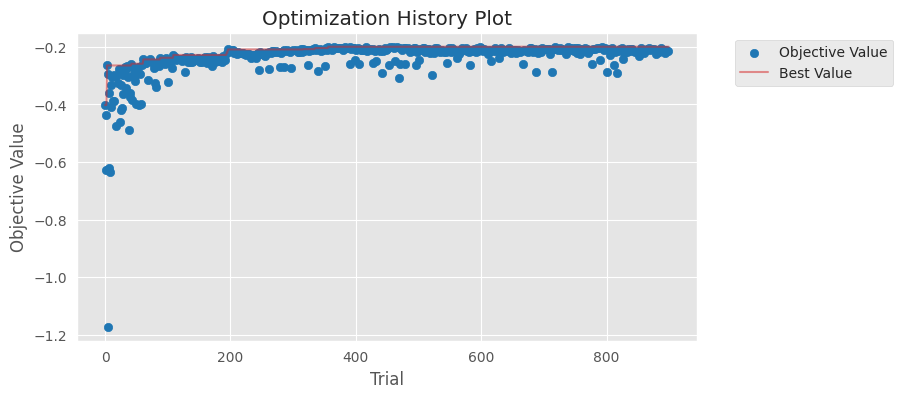

Best Parameters       : {'sign_smoothwin': 180, 'sellmin_idx': None, 'sess_start': '14:30:00', 'trailstop_pct': 0.2998489569411201}
Best Average Daily P&L: -0.19984886363636362

Hyperparameter importances (higher ⇒ more impact):
  trailstop_pct       : 0.832
  sign_smoothwin      : 0.107
  sellmin_idx         : 0.056
  sess_start          : 0.005

Optuna results (and importances) saved to: optuna_results/AAPL_-0.1998_predicted.json


In [6]:
# Final plots & JSON dump 
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

print("Best Parameters       :", study.best_params)
print("Best Average Daily P&L:", study.best_value)

importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s}: {score:.3f}")

first_day = df_trainval.index.normalize().min().strftime("%Y%m%d")
last_day  = df_trainval.index.normalize().max().strftime("%Y%m%d")
file_name = f"{params.ticker}_{round(study.best_value,4)}_predicted.json"
file_path = os.path.join(params.optuna_folder, file_name)

with open(file_path, "w") as f:
    json.dump({
        "best_params": study.best_params,
        "best_value" : study.best_value,
        "importances": importances,
        "trials": [
            {"number": t.number, "value": t.value, "params": t.params, "state": t.state.name}
            for t in study.trials
        ],
    }, f, indent=4)

print(f"\nOptuna results (and importances) saved to: {file_path}")